In [1]:
import ROOT                                                                                                             
import uproot                                                                                                           
import uproot.behaviors.TGraph                                                                                          
import uproot3                                                                                                          
import os                                                                                                               
import csv                                                                                                              
import pandas as pd                                                                                                     
import numpy as np                                                                                                      
import multiprocessing as mp                                                                                            
import awkward as ak                                                                                                    
import matplotlib.pyplot as plt  
import matplotlib 
import seaborn as sns           
from tools.studybeta import minuitfit_LL, cdf_gaussian, calc_signal_fraction, cdf_double_gaus, double_gaus, minuitfit_Chi
from tools.binnings_collection import get_nbins_in_range, get_sub_binning, get_bin_center, compute_dayfromtime          
from tools.binnings_collection import mass_binning, fbinning_energy, LithiumRigidityBinningFullRange, Rigidity_Analysis_Binning_FullRange                                                                                                      
from tools.plottools import plot1dhist, plot2dhist, plot1d_errorbar_v2, savefig_tofile, setplot_defaultstyle, FIGSIZE_BIG, FIGSIZE_SQUARE, FIGSIZE_MID, FIGSIZE_WID, FONTSIZE_BIG, FONTSIZE_MID, plot1d_errorbar, plot1d_step, set_plot_defaultstyle                                                                                                                  
from tools.calculator import calc_rig_from_ekin, calc_ratio_err, calc_ekin_from_beta, calc_mass                         
from tools.constants import ISOTOPES_MASS, NUCLEI_CHARGE, NUCLEIS ,  ISOTOPES_COLOR, ISO_LABELS, DETECTOR_LABEL, DETECTOR_COLOR                                              
from tools.histograms import Histogram, plot_histogram_2d                                                               
from tools.binnings import Binning                                                                                      
from tools.roottree import read_tree                                                                                    
from tools.selections import *                                                                                          
import pickle                                                                                                           
from tools.graphs import MGraph, slice_graph, plot_graph, slice_graph_by_value
from scipy.optimize import curve_fit
from tools.massfit_tools import get_fitpdf_witherr, get_fitpdferrorband
from tools.functions import poly, upoly
from tools.histograms import Histogram, WeightedHistogram, plot_histogram_1d, plot_histogram_2d 
import os
from tools.functions import cumulative_norm_gaus, normalized_gaussian, poly, upoly
from tools.jupytertools import *

Welcome to JupyROOT 6.26/10


/home/manbing/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
figsize1 = (21, 25)
fontsize1 = 45
fontsize2 = 55
mksize = 20

In [3]:
tick_length = 14                                                                                         
tick_width=1.5                                                                                           
tick_labelsize = 40                                                                                      
legendfontsize = 45   
def set_plot_style(plot):                                                                         
    plt.rcParams["font.weight"] = "bold"                                                                 
    plt.rcParams["axes.labelweight"] = "bold"                                                            
    plt.rcParams['font.size']= 45                                                                 
    plt.rcParams['xtick.top'] = False                                                                    
    plt.rcParams['ytick.right'] = False                                                                  
    plot.tick_params(axis='both', which="major",direction='in', length=tick_length, width=tick_width, labelsize=tick_labelsize)                                                                                  
    plot.tick_params(axis='both', which="minor",direction='in', length=tick_length/2.0, width=tick_width, labelsize=tick_labelsize)                                                                              
    for axis in ['top','bottom','left','right']:                                                    
        plot.spines[axis].set_linewidth(2)                                                               
    plt.minorticks_on()          

In [4]:
nuclei = 'Be'                                                                                               
detectors = ["Tof", "NaF", "Agl"]        
#detectors = ["Tof", "NaF", "Agl"]                                                                                   
detectors_alias = {"Tof": "tof", "Agl":"agl", "NaF": "naf"}                                                         
variable = 'Ekin'                                                                                          
massbinning = Binning(mass_binning())                                                                               
inverse_mass_binning = Binning(np.linspace(0.05, 0.3, 100))     
plotfile = '/home/manbing/Documents/lithiumanalysis/slides/plots/GetTemplateParsRange_ModifyRig'
 
os.makedirs(plotfile, exist_ok=True)

In [14]:
polyfitp0 = {dec: {} for dec in detectors}    
parnames = ["mean",  "sigma", "fraccore", "sigma_ratio", "asy_factor"]      
polyfitp0["Agl"] = {"mean": [0.15, 0.0, 0.0], "sigma":[0.016, 0.0, 0.0, 0.001], 'sigma_ratio': [1.5, 0.1, 0.1], 'asy_factor':[1.1, 0.1, 0.001], 'fraccore': [0.8, 0.01 , 0.01]}                                                 
polyfitp0["NaF"] = {"mean": [0.15, 0.0, 0.0], "sigma":[0.016, 0.0, 0.0], 'sigma_ratio': [1.5], 'asy_factor':[1.1], 'fraccore': [0.75]}                                                                             
polyfitp0["Tof"] = {"mean": [0.15, 0.0, 0.0], "sigma":[0.016, 0.001, 0.001], 'sigma_ratio': [1.2, 0.001, 0.001], 'asy_factor':[1.4, 0.01, 0.001], 'fraccore': [0.823]}  
ylim_range_be7 = {'mean'  :     [0.145, 0.16], 'sigma' : [0.012, 0.022], 'sigma_ratio':[1.6, 2.0], 'asy_factor': [0.8, 1.6], 'fraccore':   [0.7, 1.0], "norm":       [0, 40]} 

par_names_axes = {'mean': '$\mathrm{\mu}$',                                                                                                                                                                        
                  'sigma': '$\mathrm{\sigma}$',                                                                                                                                                                
                  "sigma_ratio": '$\mathrm{ \epsilon(\sigma ratio)}$',                                                                                                                                             
                  "asy_factor":'asy_factor (a)',                                                                                                                                                                            
                  "fraccore":'$\mathrm{f_{core}}$',                                                                                                                                                                
                  'norm':'Norm'}       

def plot_parswitherr(fig, ax1, graph1, col, p0_mean, labelname=None):
    plot_graph(fig, ax1, graph1, color=col, style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label=labelname)
    popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, p0 = p0_mean)  
    ax1.plot(graph1.xvalues, poly(np.log(graph1.xvalues), *popt), "-", color=col)
    polypars = uncertainties.correlated_values(popt, np.array(pcov)) 
    mufit_lower, mufit_upper = get_fitpdferrorband(np.log(graph1.xvalues), polypars, upoly)  
    ax1.fill_between(graph1.xvalues, mufit_lower, mufit_upper, color=col, alpha=0.2)   

In [15]:
isGBL = True
FONTSIZE = 35

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


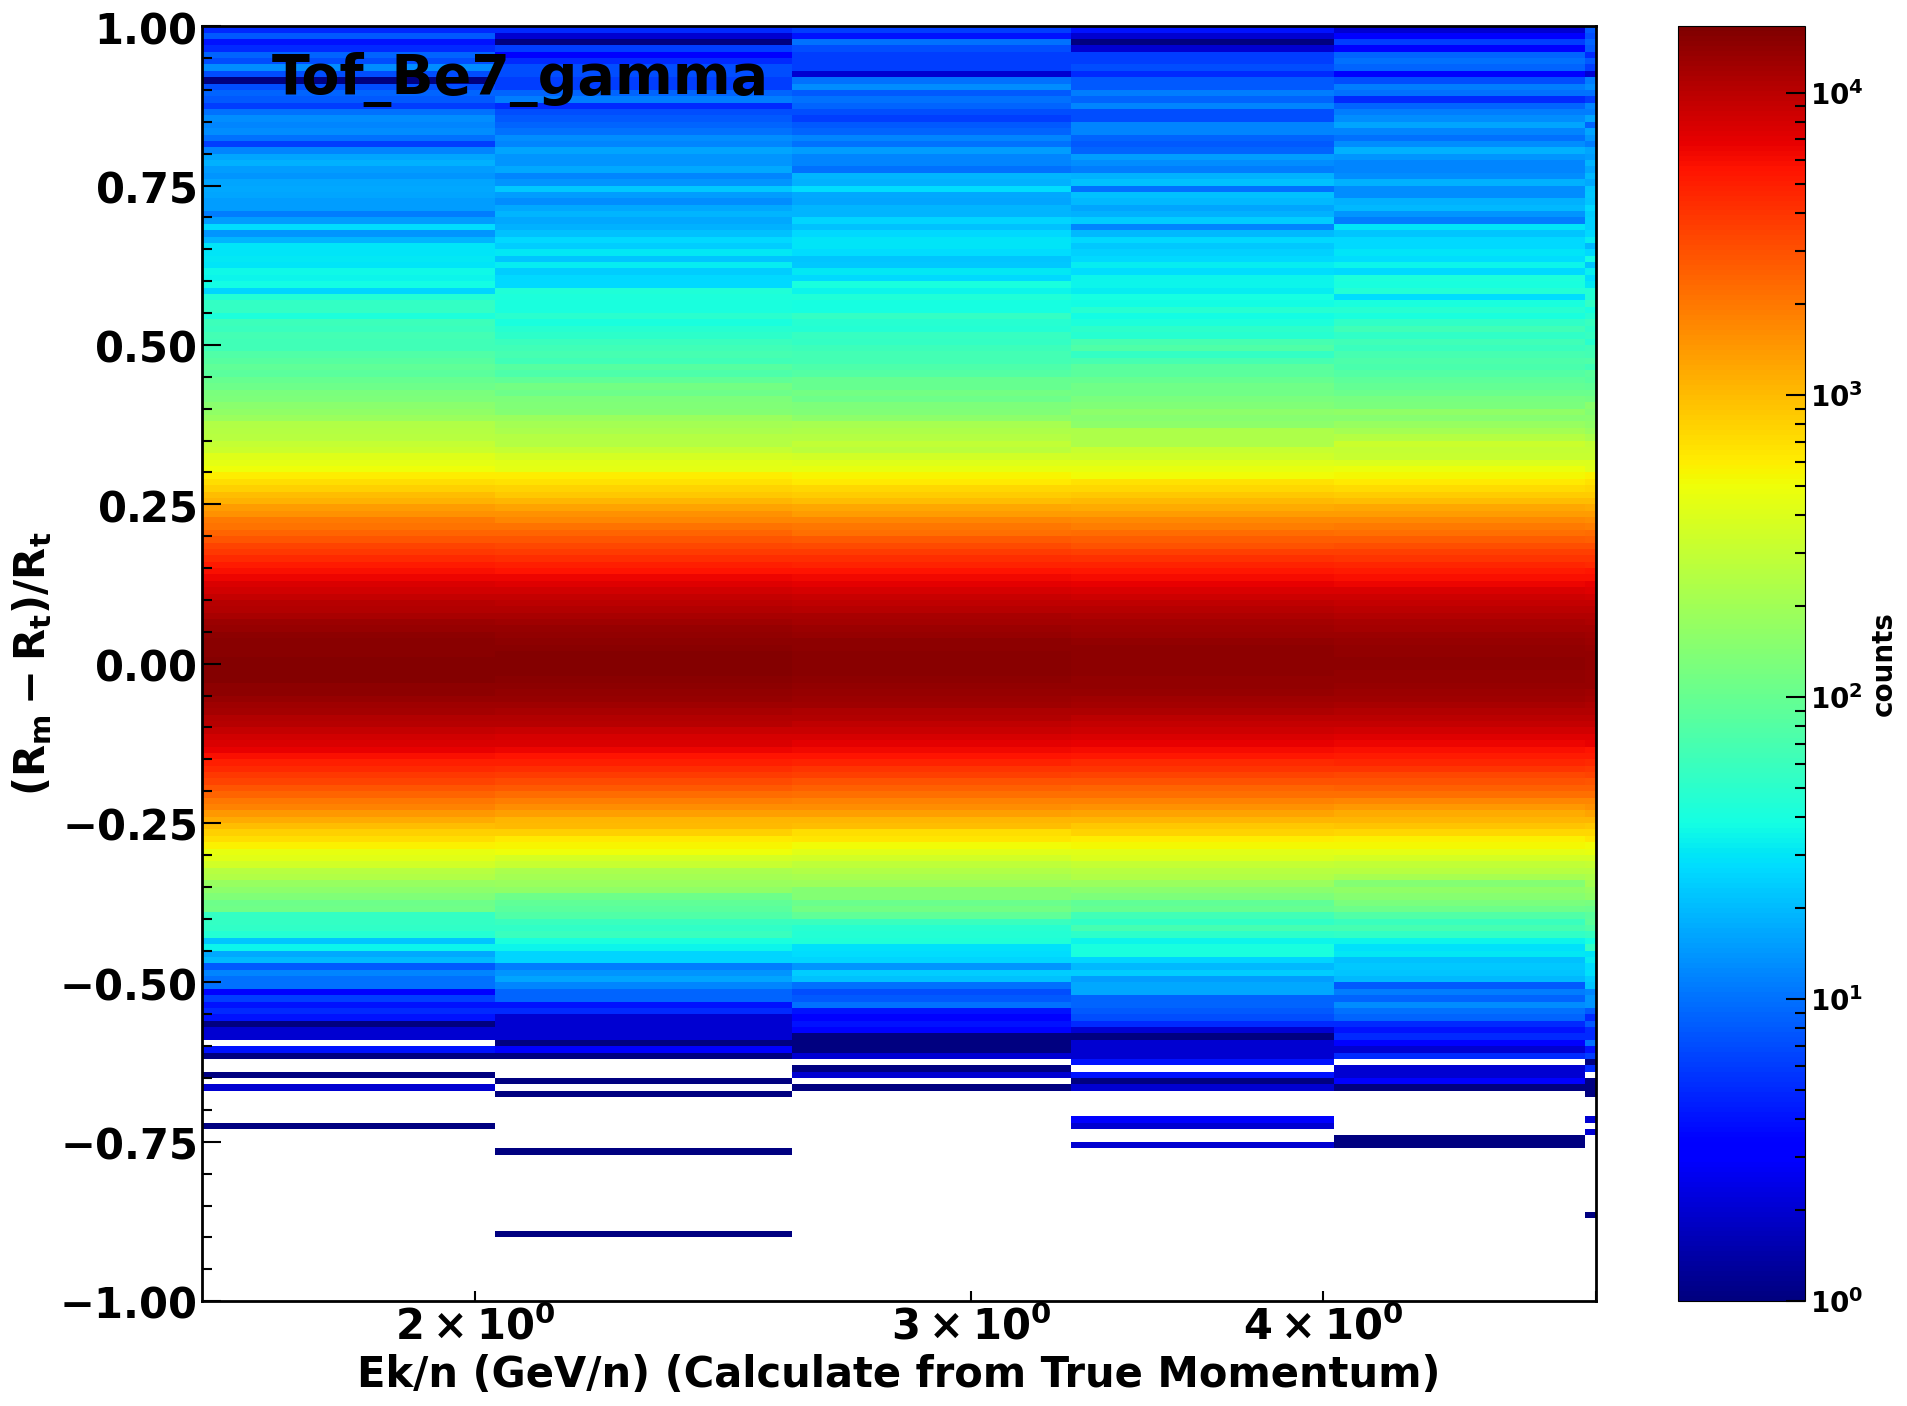

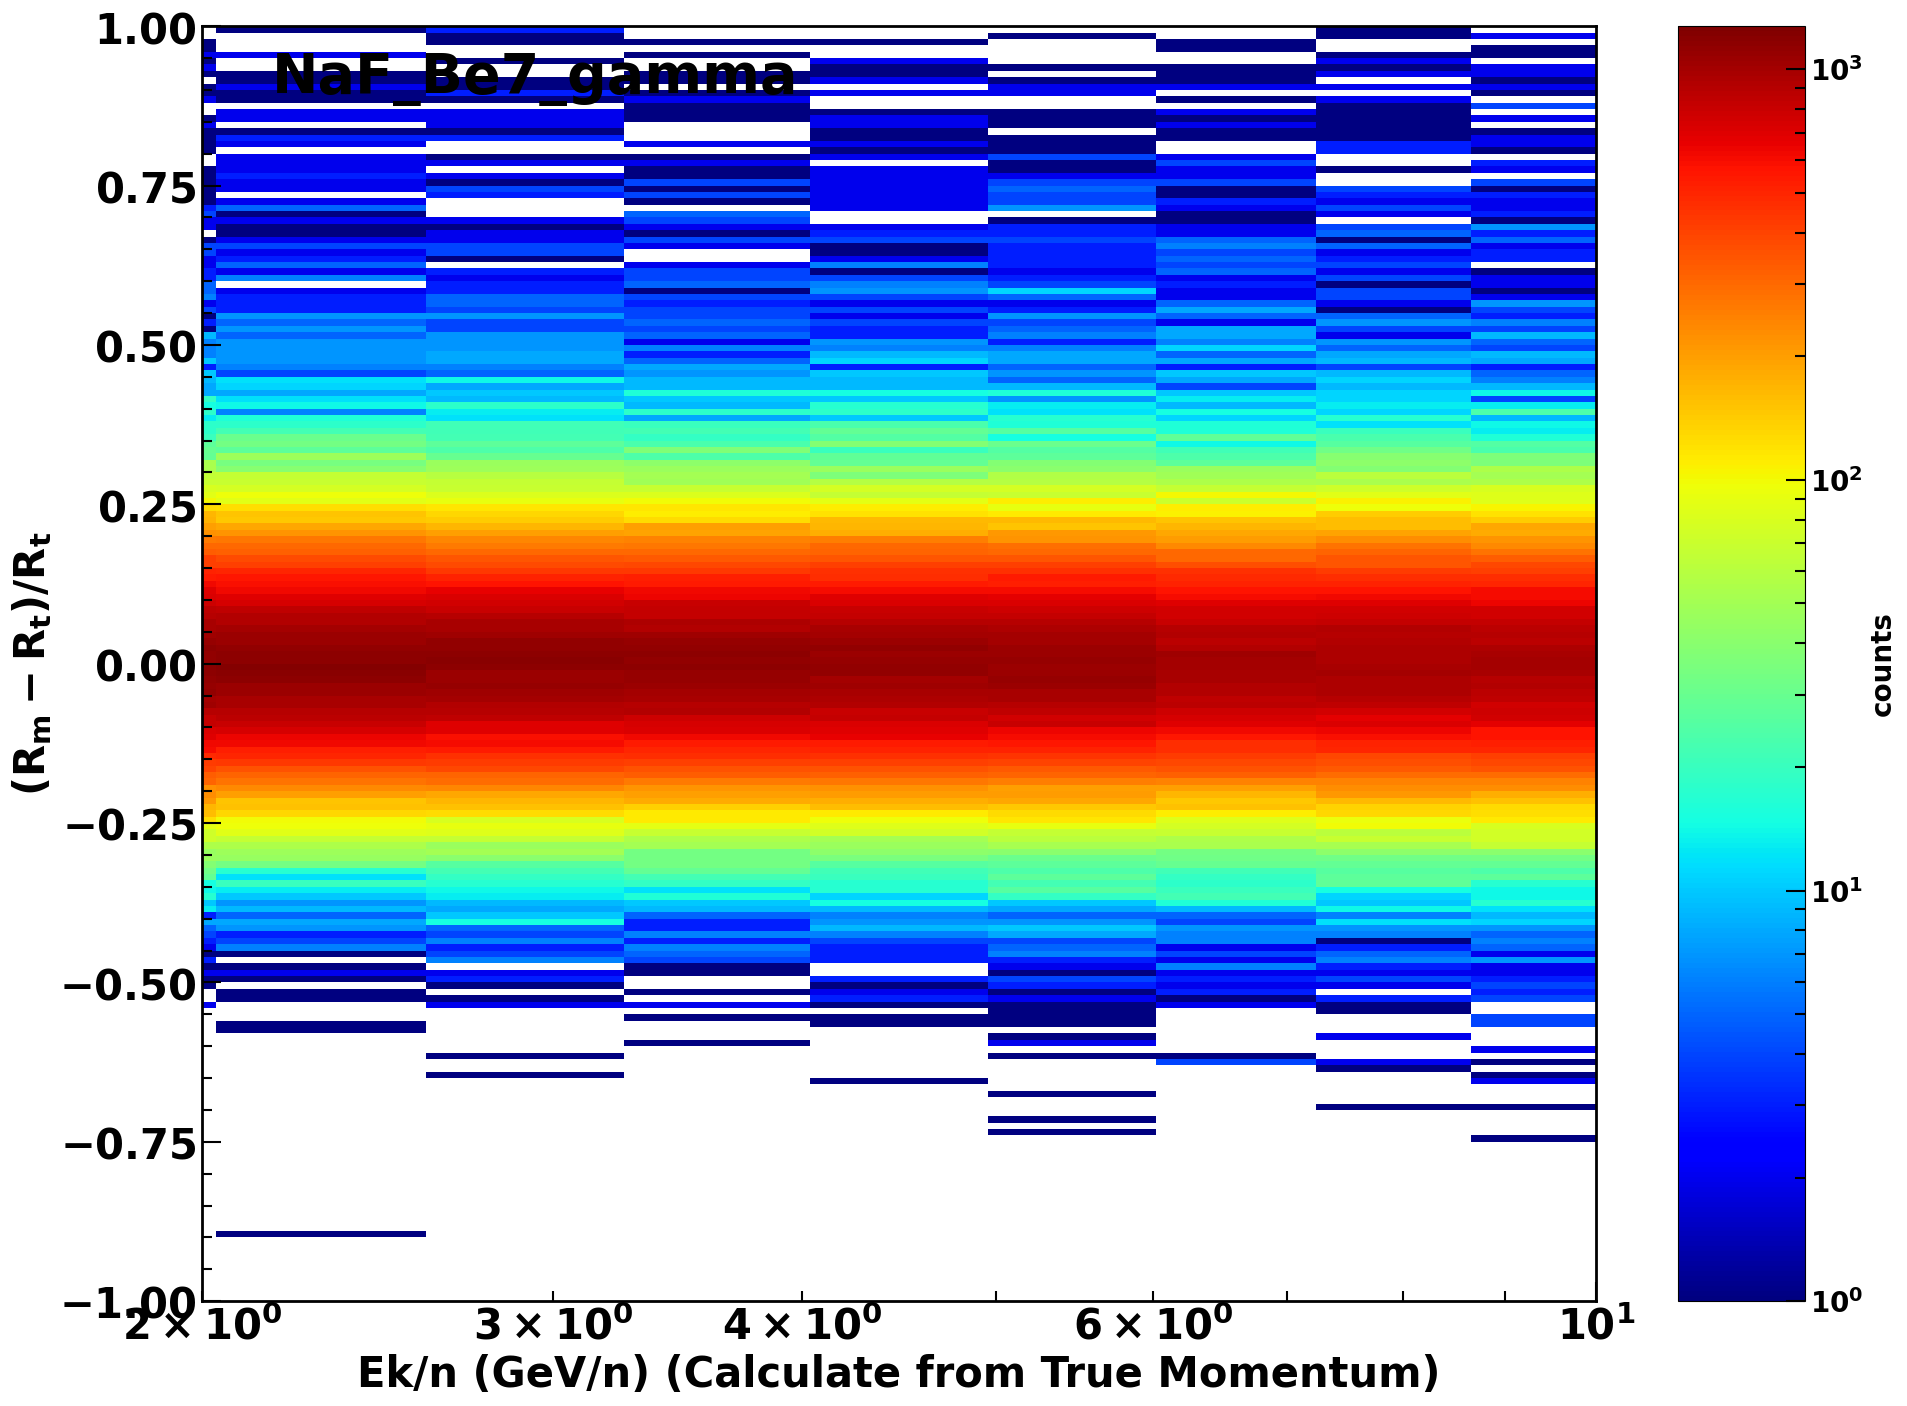

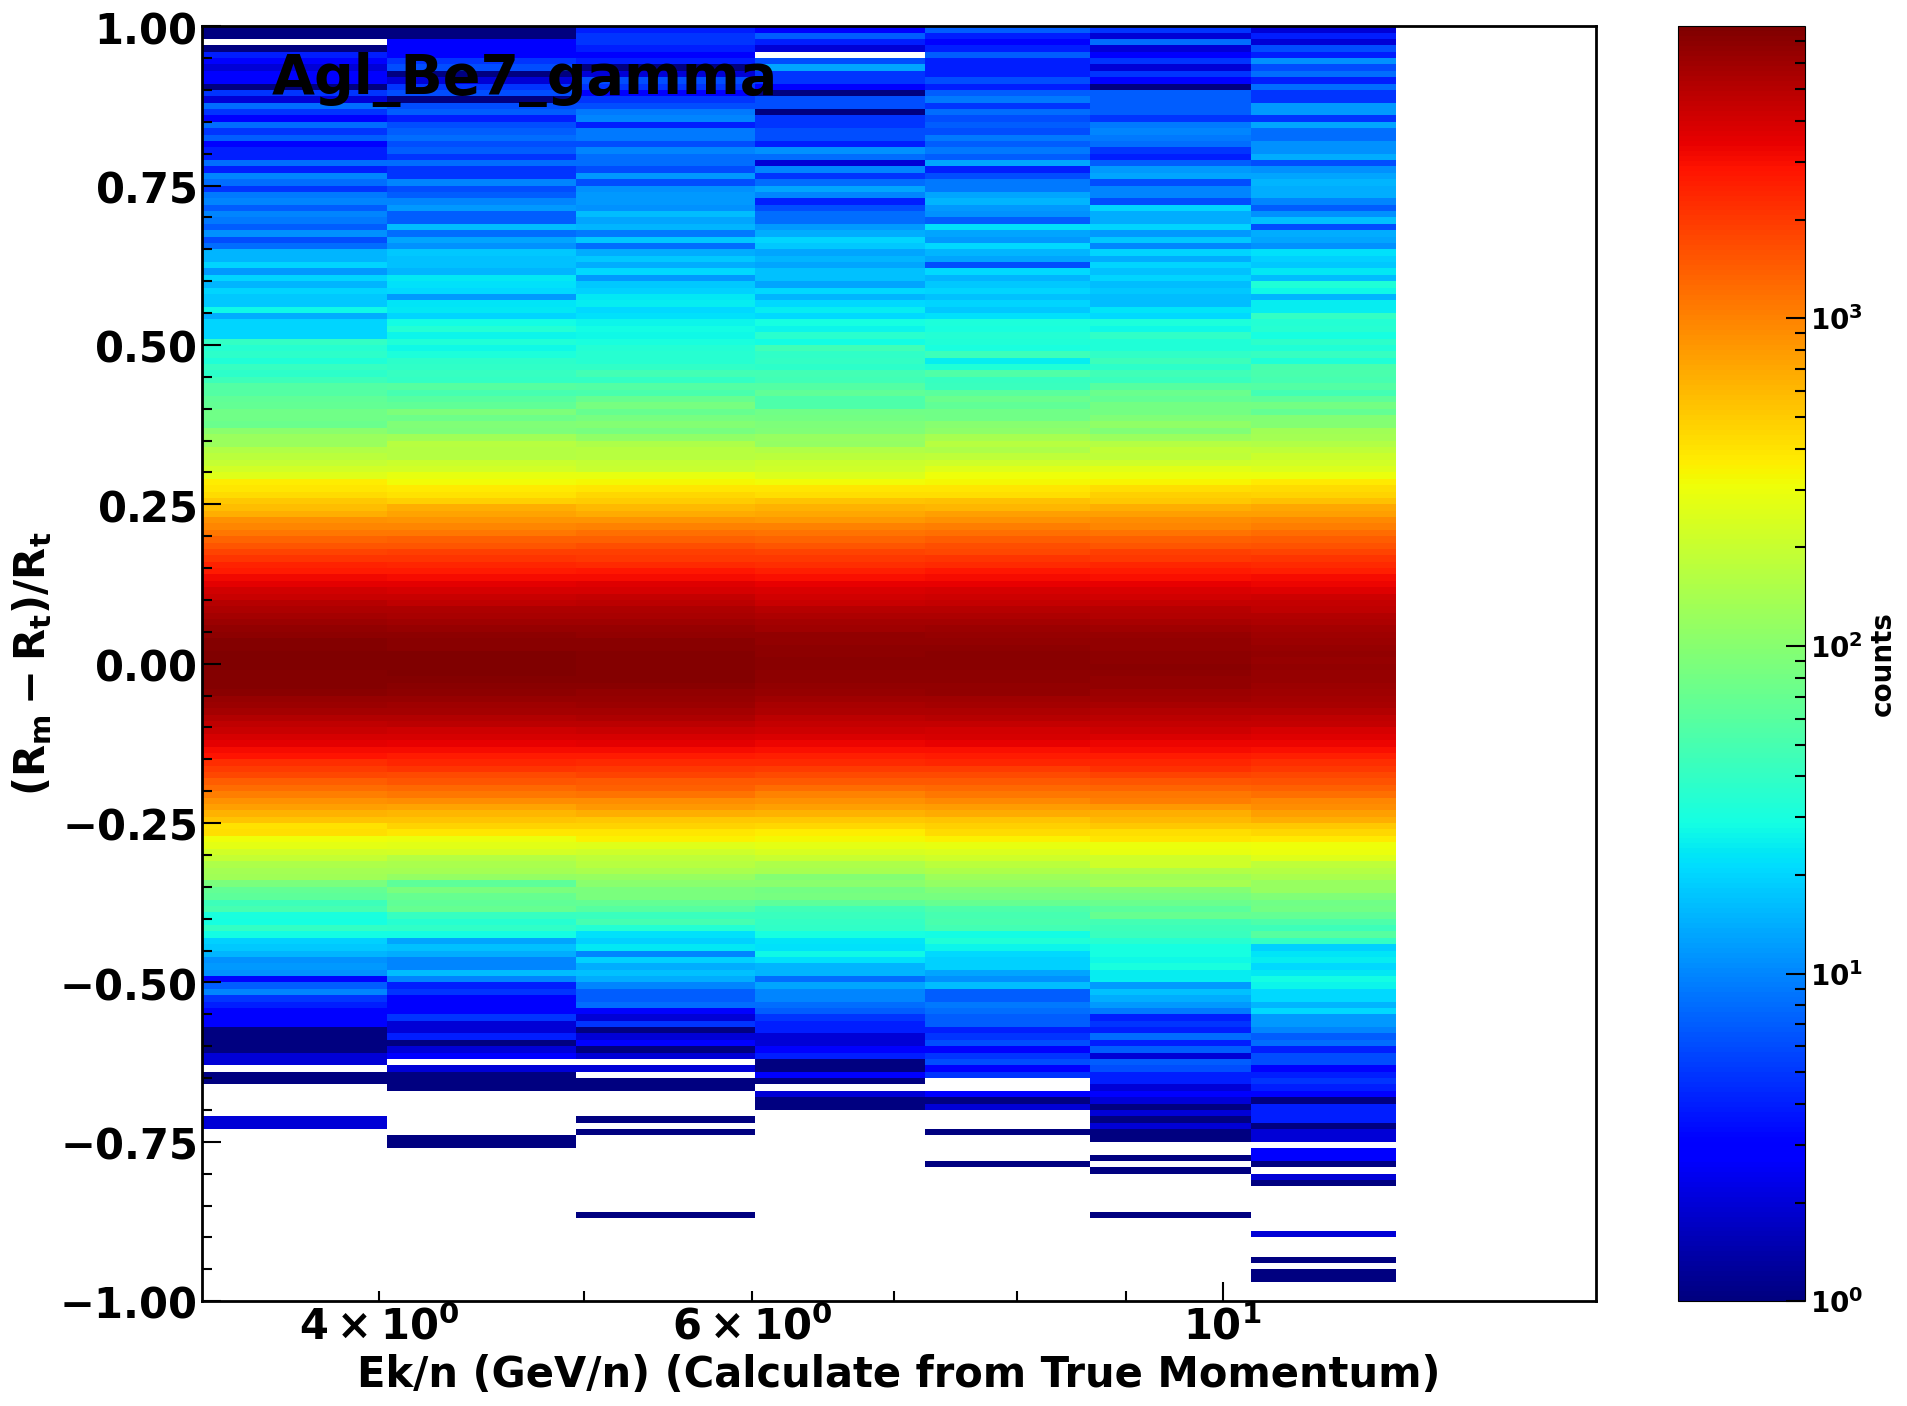

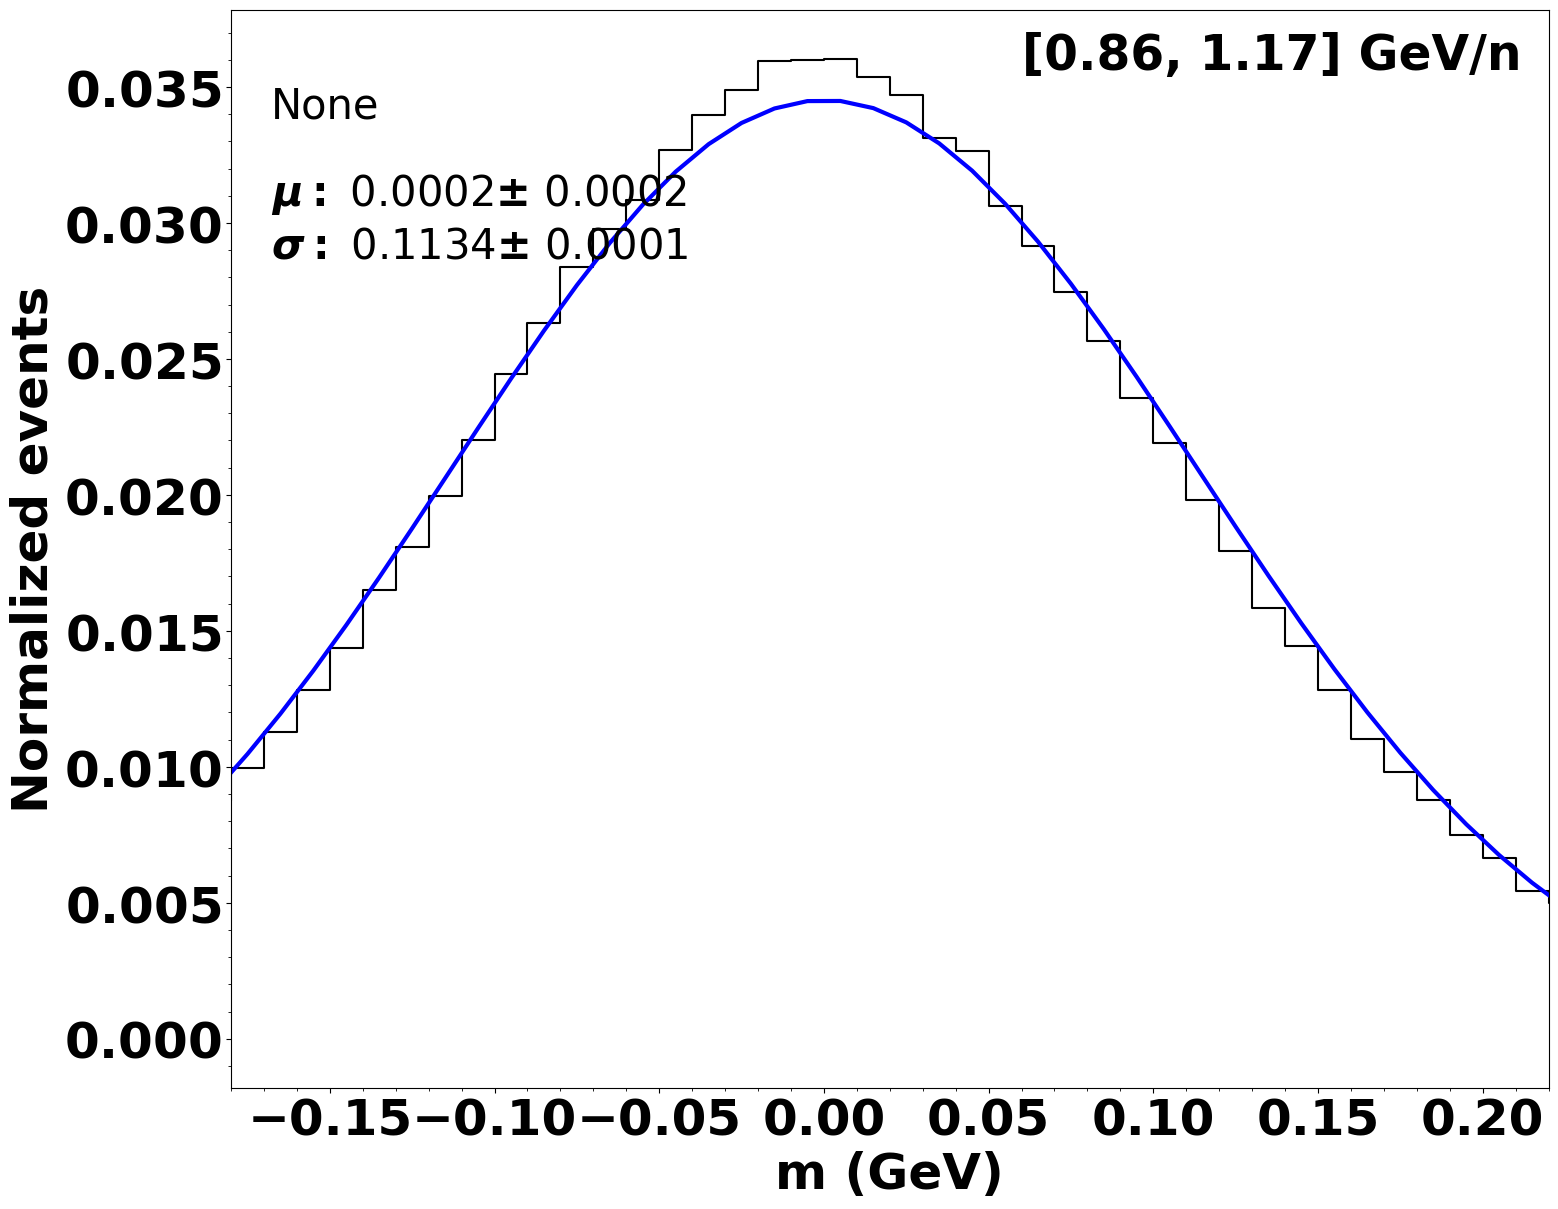

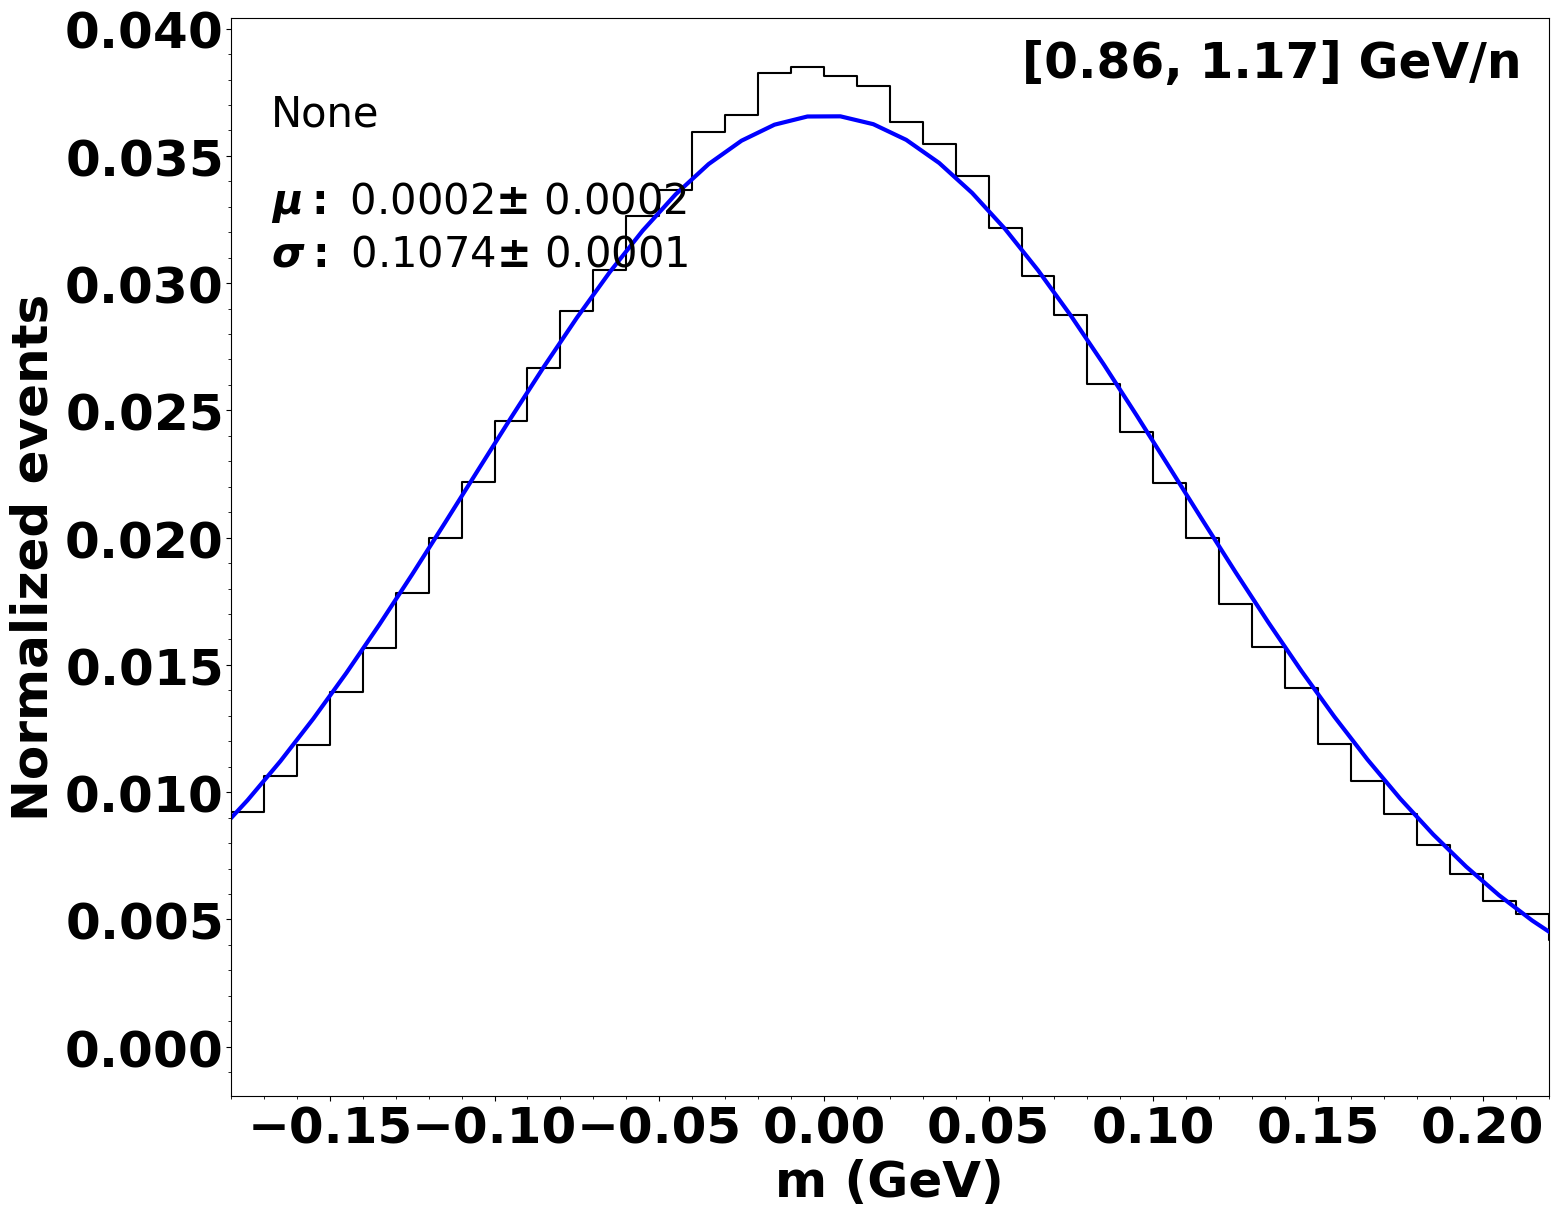

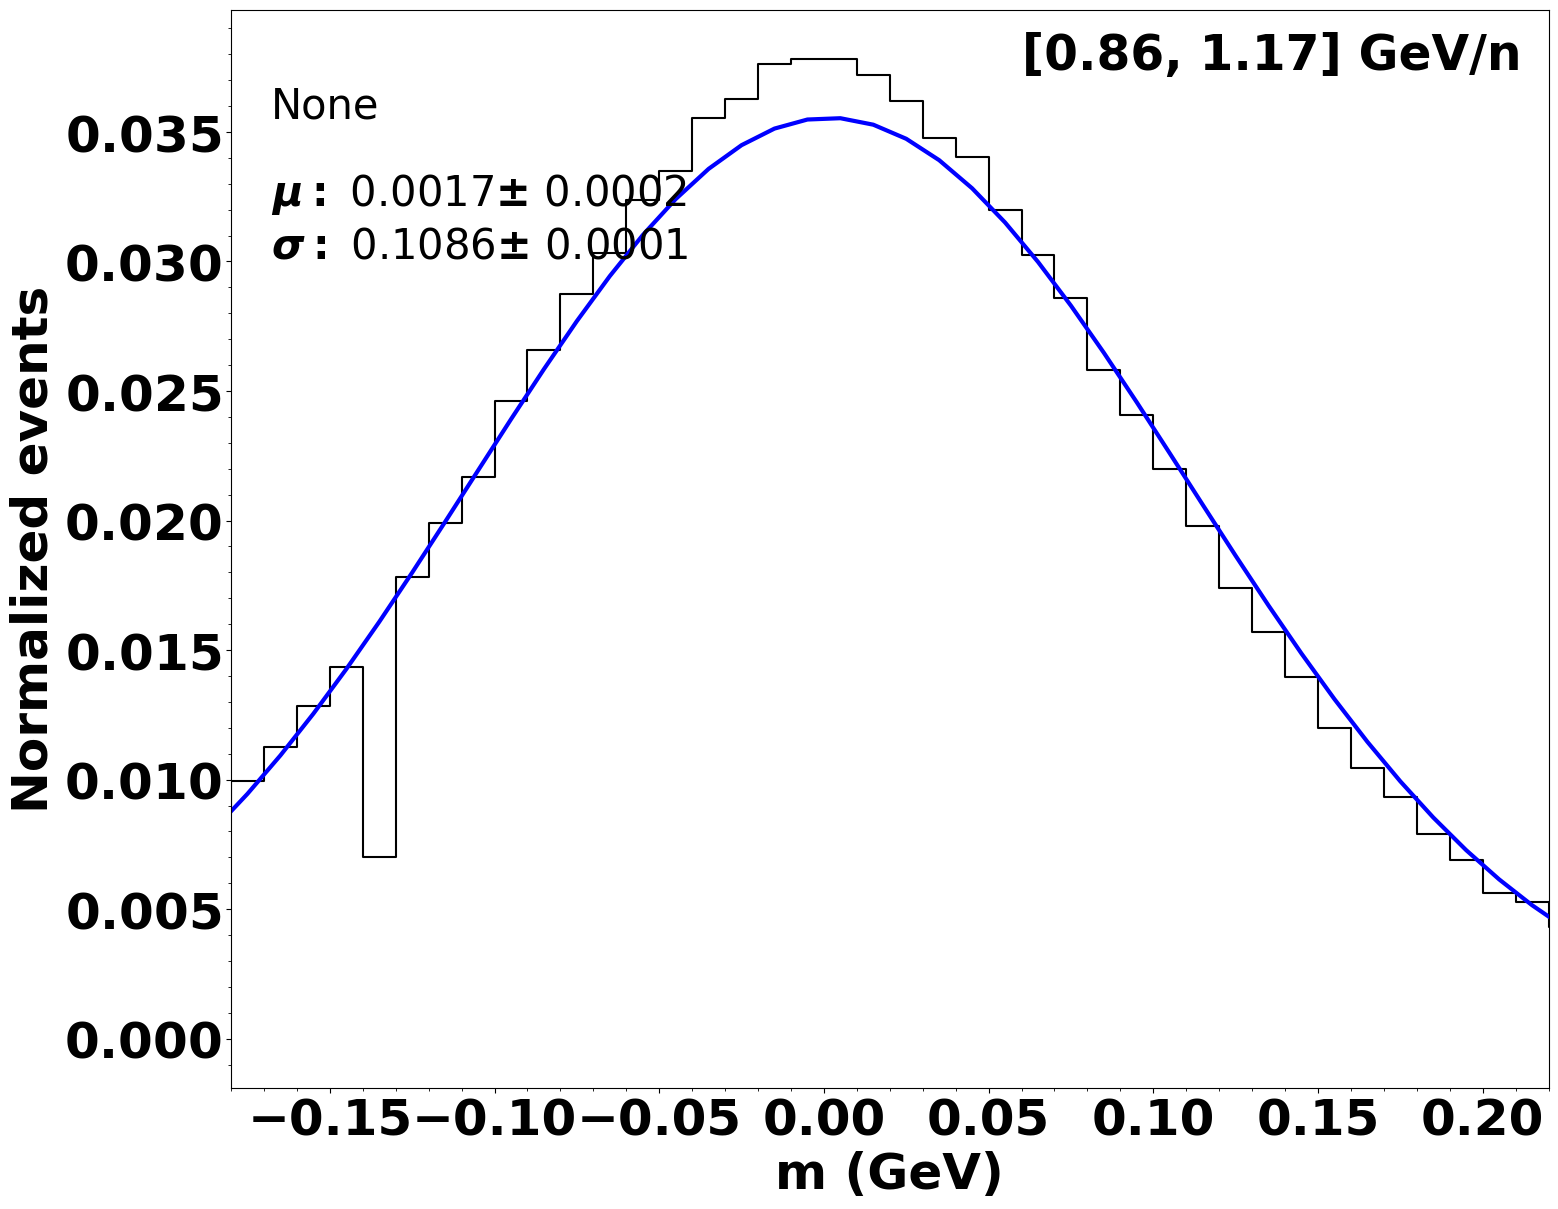

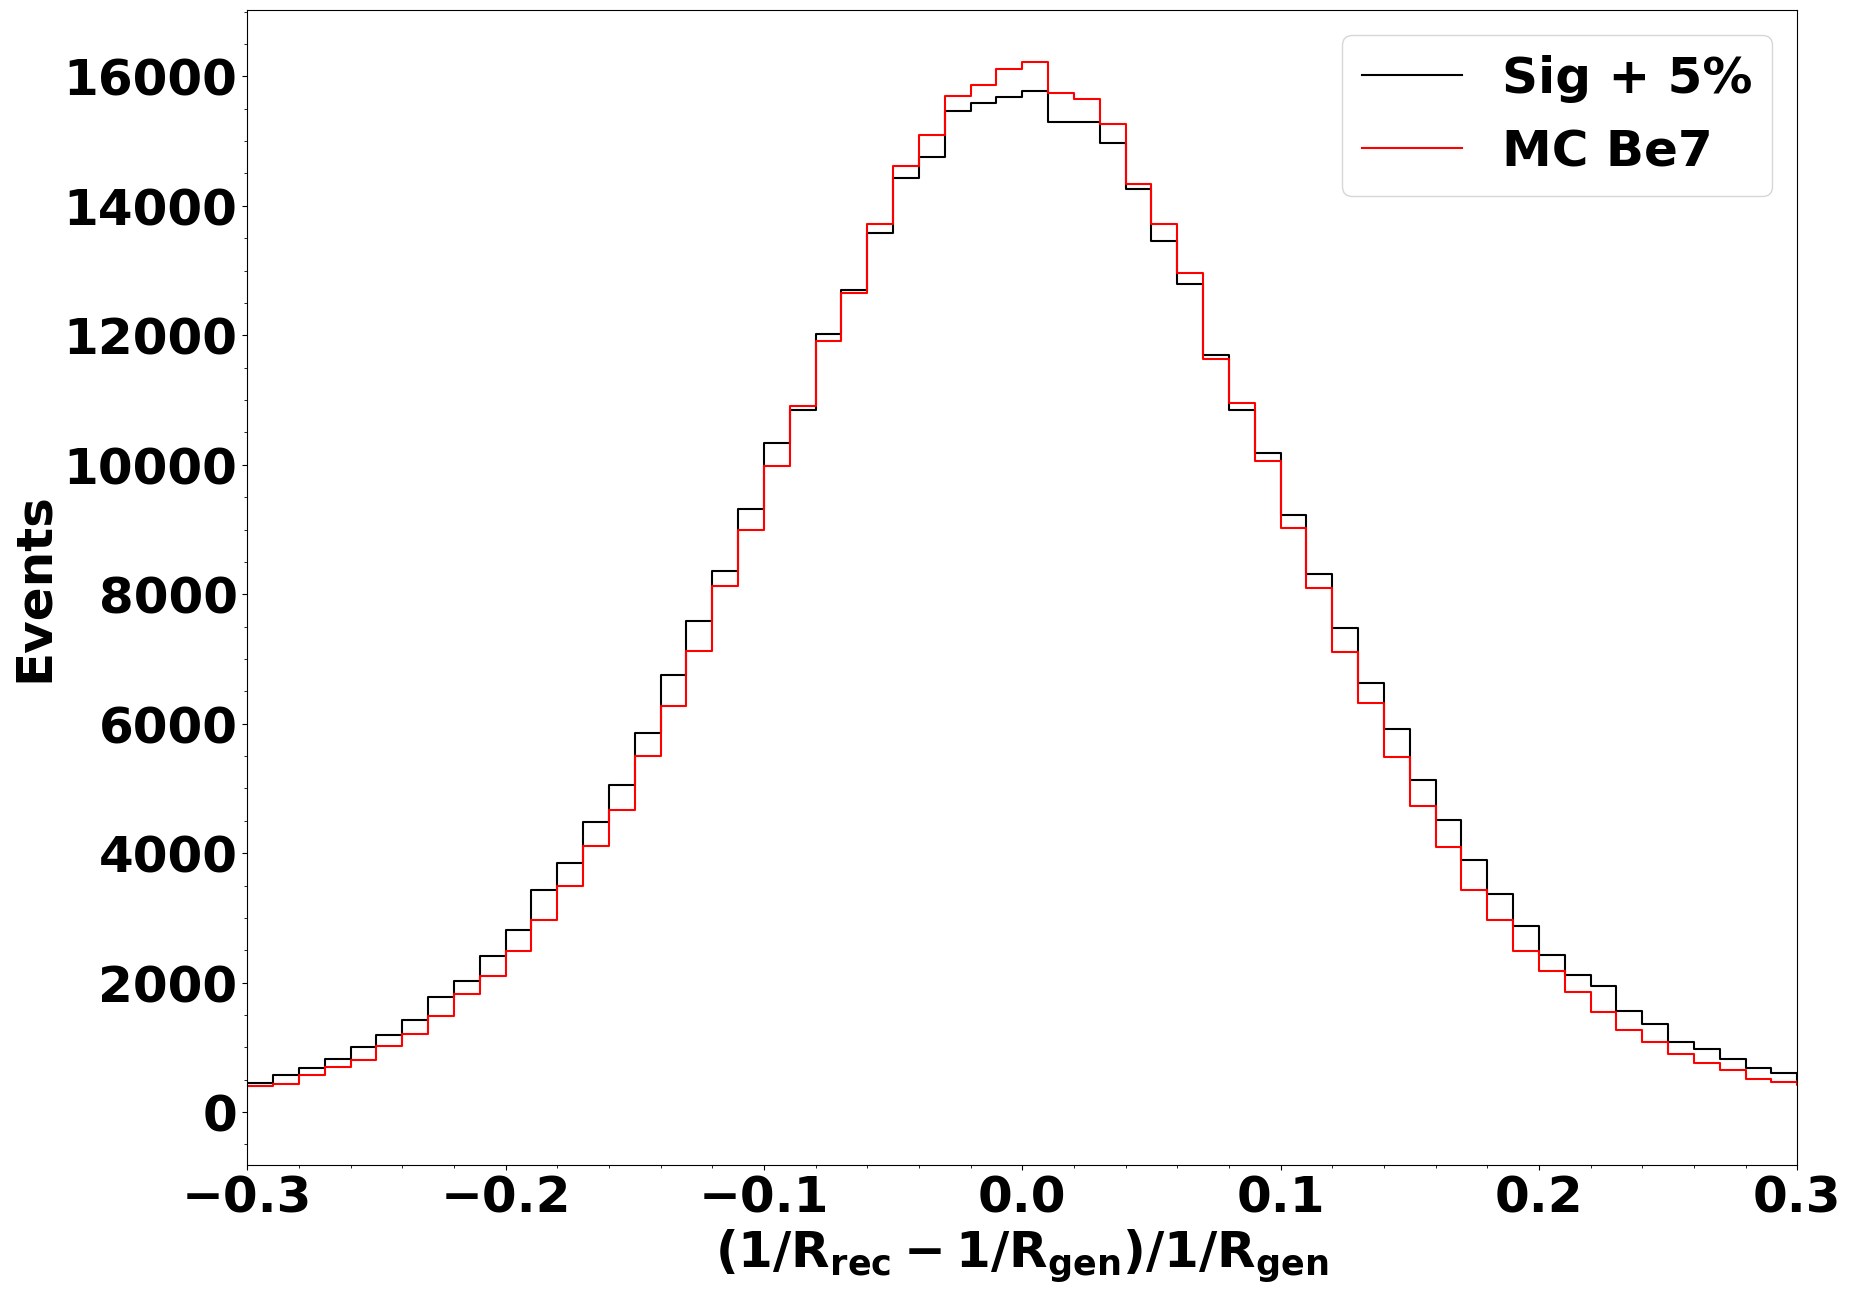

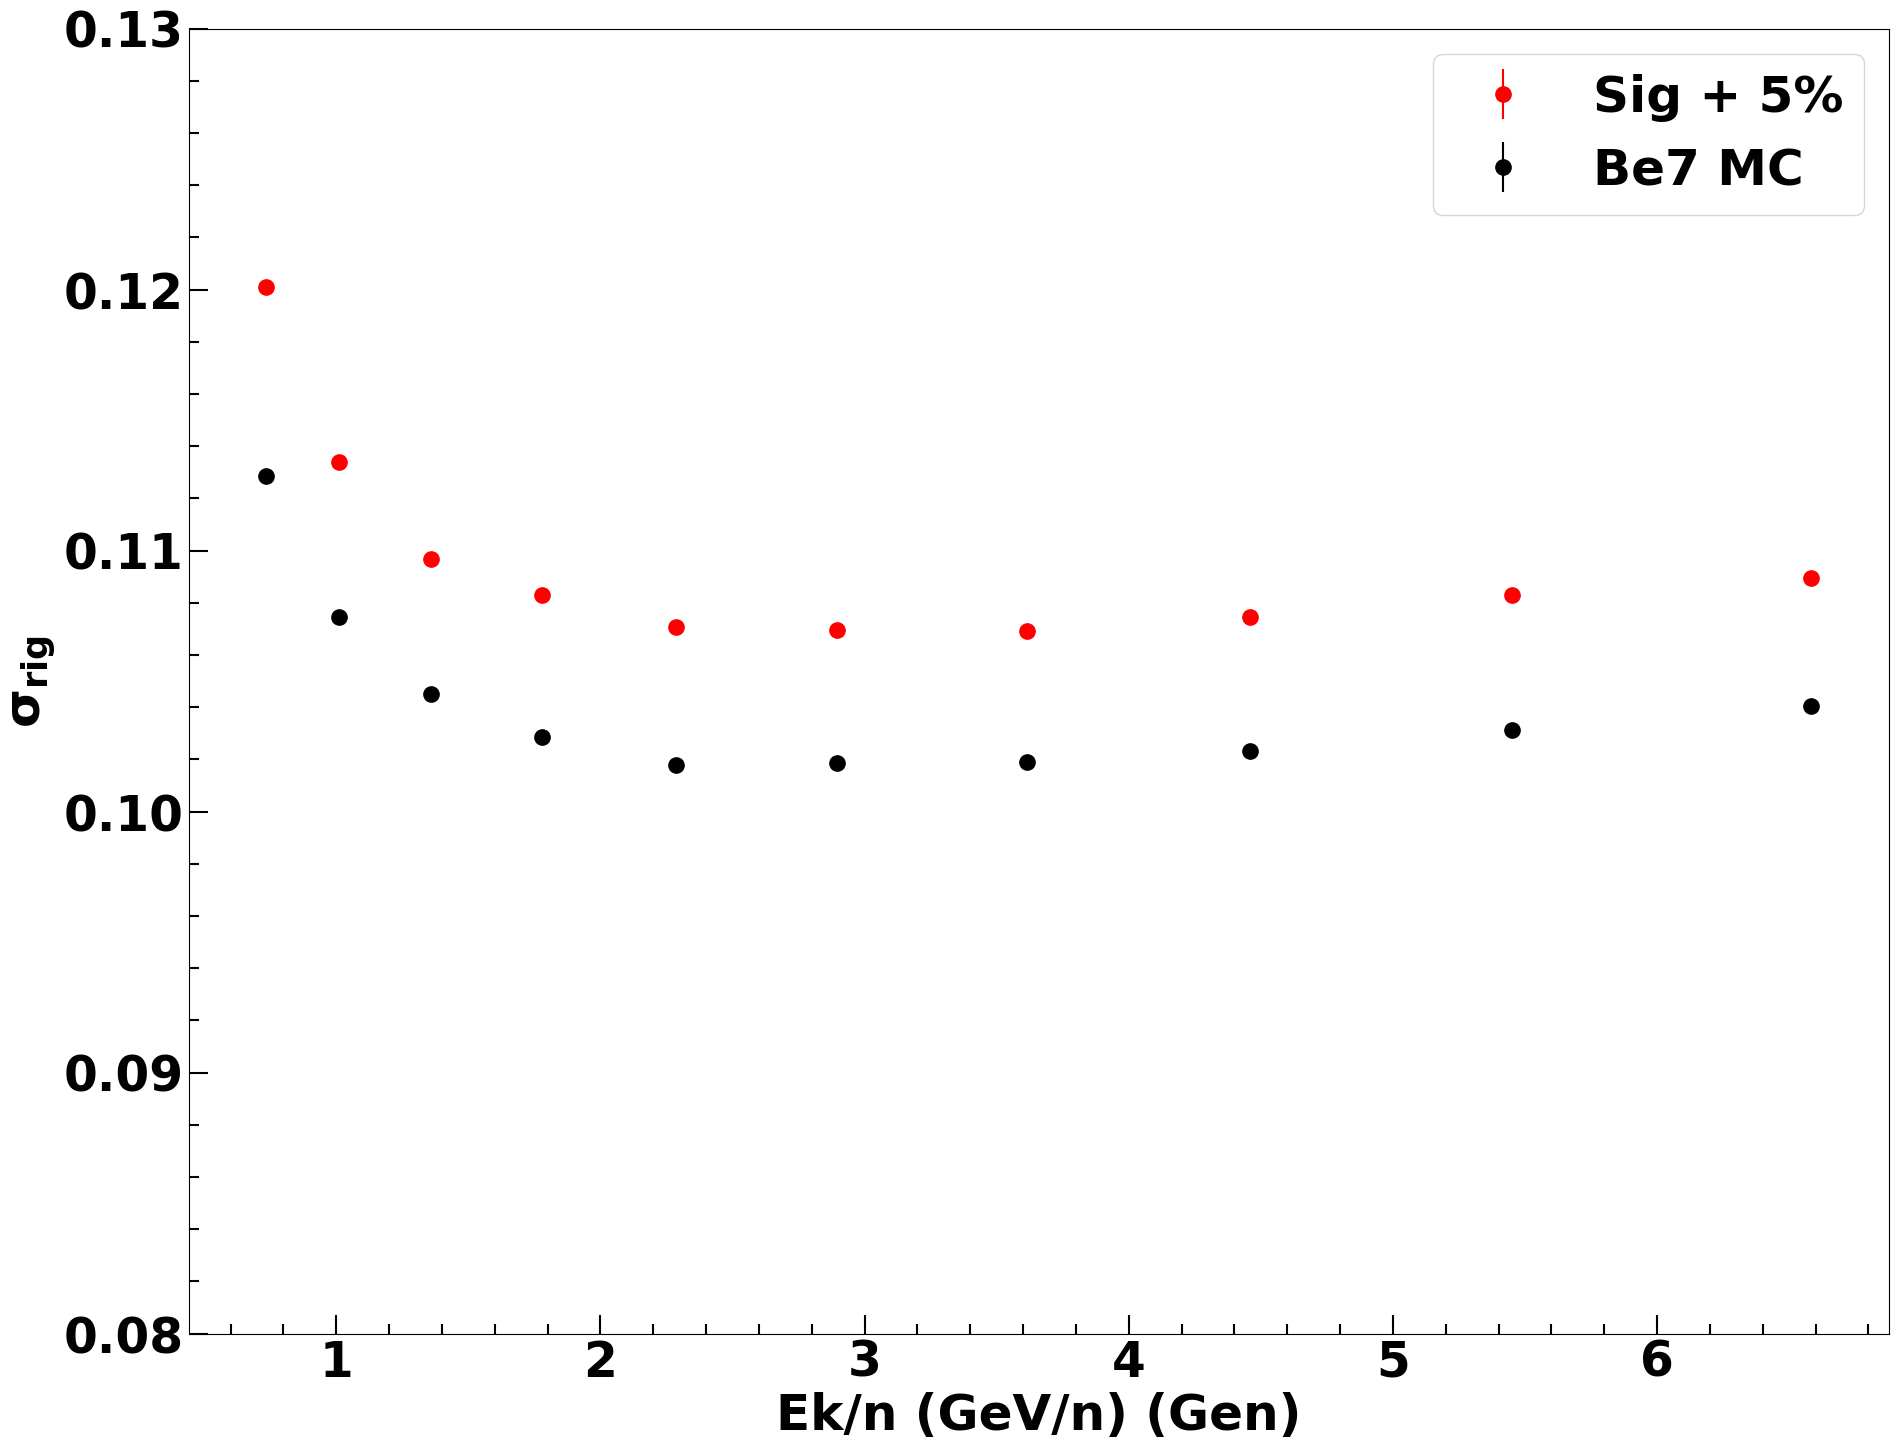

In [16]:
#################################################################################################################
#read the file npz with rigreso +5%, rig tail 5%, plots the comparsion, just for showing the rigidity certainties
###################################################################################################################

file_rigsigp5 = '/home/manbing/Documents/Data/data_BeP8/Be2DHist/BeMC_hist_RigReso_RigSigPlus5Precent.npz'
file_rigtailp5 = '/home/manbing/Documents/Data/data_BeP8/BeMassHist/BeMC_hist_RigMasss_RigTailPlus5Precent.npz'
file_rig = '/home/manbing/Documents/Data/data_BeP8/Be2DHist/BeMC_hist_RigReso.npz'

fnp_rigsigp5 = np.load(f'{file_rigsigp5}')
fnp_rigtailp5 = np.load(f'{file_rigtailp5}')
fnp_rig = np.load(f'{file_rig}')

hist2d_rigsigp5 = {dec: {} for dec in detectors}
hist2d_rigtailp5 = {dec: {} for dec in detectors}
hist2d_rig = {dec: {} for dec in detectors}

gammalim = {'Tof':[1.6, 5.0], "NaF":[2.0, 10.0], "Agl":[3.3, 15.0]}

for dec in detectors:
    for iso in ['Be7']:
        hist2d_rigsigp5[dec][iso] = WeightedHistogram.from_file(fnp_rigsigp5, f"hist_rig_resolution_{dec}{iso}")  
        hist2d_rigtailp5[dec][iso] = WeightedHistogram.from_file(fnp_rigtailp5, f"hist_rig_resolution_{dec}{iso}")  
        hist2d_rig[dec][iso] = WeightedHistogram.from_file(fnp_rig, f"hist_rig_resolution_{dec}{iso}_vsEkn")  
        fig = plt.figure(figsize=(20, 15))
        plot = fig.subplots(1, 1) 
        plot2dhist(fig, plot, xbinning=hist2d_rigsigp5[dec][iso].binnings[0].edges[1:-1],
                   ybinning=hist2d_rigsigp5[dec][iso].binnings[1].edges[1:-1],
                   counts=hist2d_rigsigp5[dec][iso].values[1:-1, 1:-1], 
                   xlabel=None, ylabel=None, zlabel="counts", zmin=None, zmax=None, 
                   setlogx=False, setlogy=False, setscilabelx=True, setscilabely=True,  setlogz=True)  
        plot.text(0.05, 0.98, f"{dec}_{iso}_gamma", fontsize=TEXTSIZE, verticalalignment='top', horizontalalignment='left', transform=plot.transAxes, color="black", fontweight="bold")          
        plot.set_xlabel(r"Ek/n (GeV/n) (Calculate from True Momentum)", fontsize=30)                                                                                                                                                     
        plot.set_ylabel(r'$\mathrm{(R_{m}-R_{t})/R_{t}}$', fontsize=30)
        plot.set_xscale('log')
        plot.set_xlim(gammalim[dec])
        savefig_tofile(fig, plotfile, f"hist2d_rigreso_{dec}_{iso}", show=True)                                                                                                                 


ibin = 5
minbin = 2
maxbin =12
guess0 = dict(norm=100, mu=0.001, sigma=0.102)
xfitrange = [-0.2, 0.2]

hist_ibin_rig = hist2d_rig['Tof']['Be7'].project(ibin)
hist_ibin_TailPlus5Percent = hist2d_rigtailp5['Tof']['Be7'].project(ibin)
hist_ibin_SigPlus5Percent = hist2d_rigsigp5['Tof']['Be7'].project(ibin)

graph_mean_rigSigPlus, graph_sigma_rigSigPlus = get_musigma_gausfit(hist2d_rigsigp5['Tof']['Be7'], minbin, maxbin, guess0, xfitrange)
graph_mean_rig, graph_sigma_rig = get_musigma_gausfit(hist2d_rig['Tof']['Be7'], minbin, maxbin, guess0, xfitrange)
graph_mean_rigTailPlus, graph_sigma_rigTailPlus = get_musigma_gausfit(hist2d_rigtailp5['Tof']['Be7'], minbin, maxbin, guess0, xfitrange)

fig = plt.figure(figsize=(20, 15))
plot = fig.subplots(1, 1) 
plot_histogram_1d(plot, hist_ibin_SigPlus5Percent, style="mc", color="black", label="Sig + 5%", scale=None, gamma=None, xlog=False, ylog=False, shade_errors=False)
plot_histogram_1d(plot, hist_ibin_rig, style="mc", color="red", label="MC Be7", scale=None, gamma=None, xlog=False, ylog=False, shade_errors=False)

#plot_histogram_1d(plot, hist_ibin_RigTailPlus5Percent, style="mc", color="blue", label="Tail + 5%", scale=None, gamma=None, xlog=False, ylog=False, shade_errors=False)
plot.legend()
plot.set_xlim([-0.3, 0.3])
savefig_tofile(fig, plotfile, f"Compare_RigReso_5Precent_Onebin", show=True) 

fig, ax1 = plt.subplots(1, 1, figsize=(20, 15))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 
plot_graph(fig, ax1, graph_sigma_rigSigPlus, color='red',  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'Sig + 5%')  
plot_graph(fig, ax1, graph_sigma_rig, color='black',  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'Be7 MC') 
#plot_graph(fig, ax1, graph_sigma_rigTailPlus, color='blue',  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'Be7 MC')  
ax1.set_ylim([0.08, 0.13])
ax1.set_xlabel('Ek/n (GeV/n) (Gen)')
ax1.set_ylabel(r'$\mathrm{\sigma_{rig}}$')
ax1.legend()
savefig_tofile(fig, plotfile, f"Compare_RigSigma_5Precent", show=True) 

In [17]:
##########################################################
#Functions that make it easier to draw the shade errorband
##########################################################

def GetFitValueLim(graph1, p0, withsigma=True):
    if withsigma:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, sigma=graph1.yerrs, p0 = p0)  
    else:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, p0 = p0)  
        
    polypars = uncertainties.correlated_values(popt, np.array(pcov)) 
    fit_lower, fit_upper = get_fitpdferrorband(np.log(graph1.xvalues), polypars, upoly)
    return fit_lower, fit_upper

def get_uncertainty_spline(graphlow, graphup):
    xvector = graphlow.xvalues
    yvector = ((graphup.yvalues - graphlow.yvalues)/2)/((graphup.yvalues + graphlow.yvalues)/2)
    spline_fit = UnivariateSpline(np.log(xvector), yvector, k=3, s=5)
    return spline_fit

def get_spline_from_graph(grapherr):
    spline_fit = UnivariateSpline(np.log(grapherr.xvalues), grapherr.yvalues, k=3, s=5)
    return spline_fit

def GetFitValue(graph1, p0, withsigma=True):
    if withsigma:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, sigma=graph1.yerrs, p0 = p0)  
    else:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, p0 = p0)  
        
    polypars = uncertainties.correlated_values(popt, np.array(pcov)) 
    fity, fityerr = get_fitpdf_witherr(np.log(graph1.xvalues), polypars, upoly)
    graph_fit = MGraph(graph1.xvalues, fity, fityerr)
    return graph_fit

def getgraph_errband(graph1,  parname, par0, withsig=False):
    fit_lower1, fit_upper1 = GetFitValueLim(graph1, par0, withsigma=withsig)
    err1= (fit_upper1 - fit_lower1)/2 
    graph_fitlow = MGraph(graph1.xvalues,fit_lower1, np.zeros_like(fit_lower1))
    graph_fitup = MGraph(graph1.xvalues,fit_upper1, np.zeros_like(fit_upper1))
    return graph_fitlow, graph_fitup

def getgrapherr(graph1,  parname, par0, withsig=False):
    fit_lower1, fit_upper1 = GetFitValueLim(graph1, par0, withsigma=withsig)
    err1= (fit_upper1 - fit_lower1)/2 
    graph_err = MGraph(graph1.xvalues, err1, np.zeros_like(fit_upper1))
    return graph_err

def getgrapherr_fromLowUp(graphlow,  graphup):
    err= (graphup.yvalues - graphlow.yvalues)/2 
    graph_err = MGraph(graphlow.xvalues, err, np.zeros_like(err))
    return graph_err

def plot_errband_constraint(fig, ax1, dffile, graph1, graph2, col, parname, p0_mean, withsig=False):
    fit_lower1, fit_upper1 = GetFitValueLim(graph1, p0_mean, withsigma=withsig)
    err1= (fit_upper1 - fit_lower1)/2 
    fit_lower2, fit_upper2 = GetFitValueLim(graph2, p0_mean, withsigma=withsig)
    err2= (fit_upper2 - fit_lower2)/2
    fitlow = np.minimum(fit_lower1, fit_lower2) 
    fitup = np.maximum(fit_upper1, fit_upper2) 
    
    graph_fitlow = MGraph(graph1.xvalues, fitlow, np.zeros_like(fitlow))
    graph_fitup = MGraph(graph1.xvalues, fitup, np.zeros_like(fitup))
    graph_fitlow.add_to_file(dffile, f'graph_{parname}low_{dec}')
    graph_fitup.add_to_file(dffile, f'graph_{parname}up_{dec}')
    #print('up - low:', fitup - fitlow)
    return graph_fitlow, graph_fitup


    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


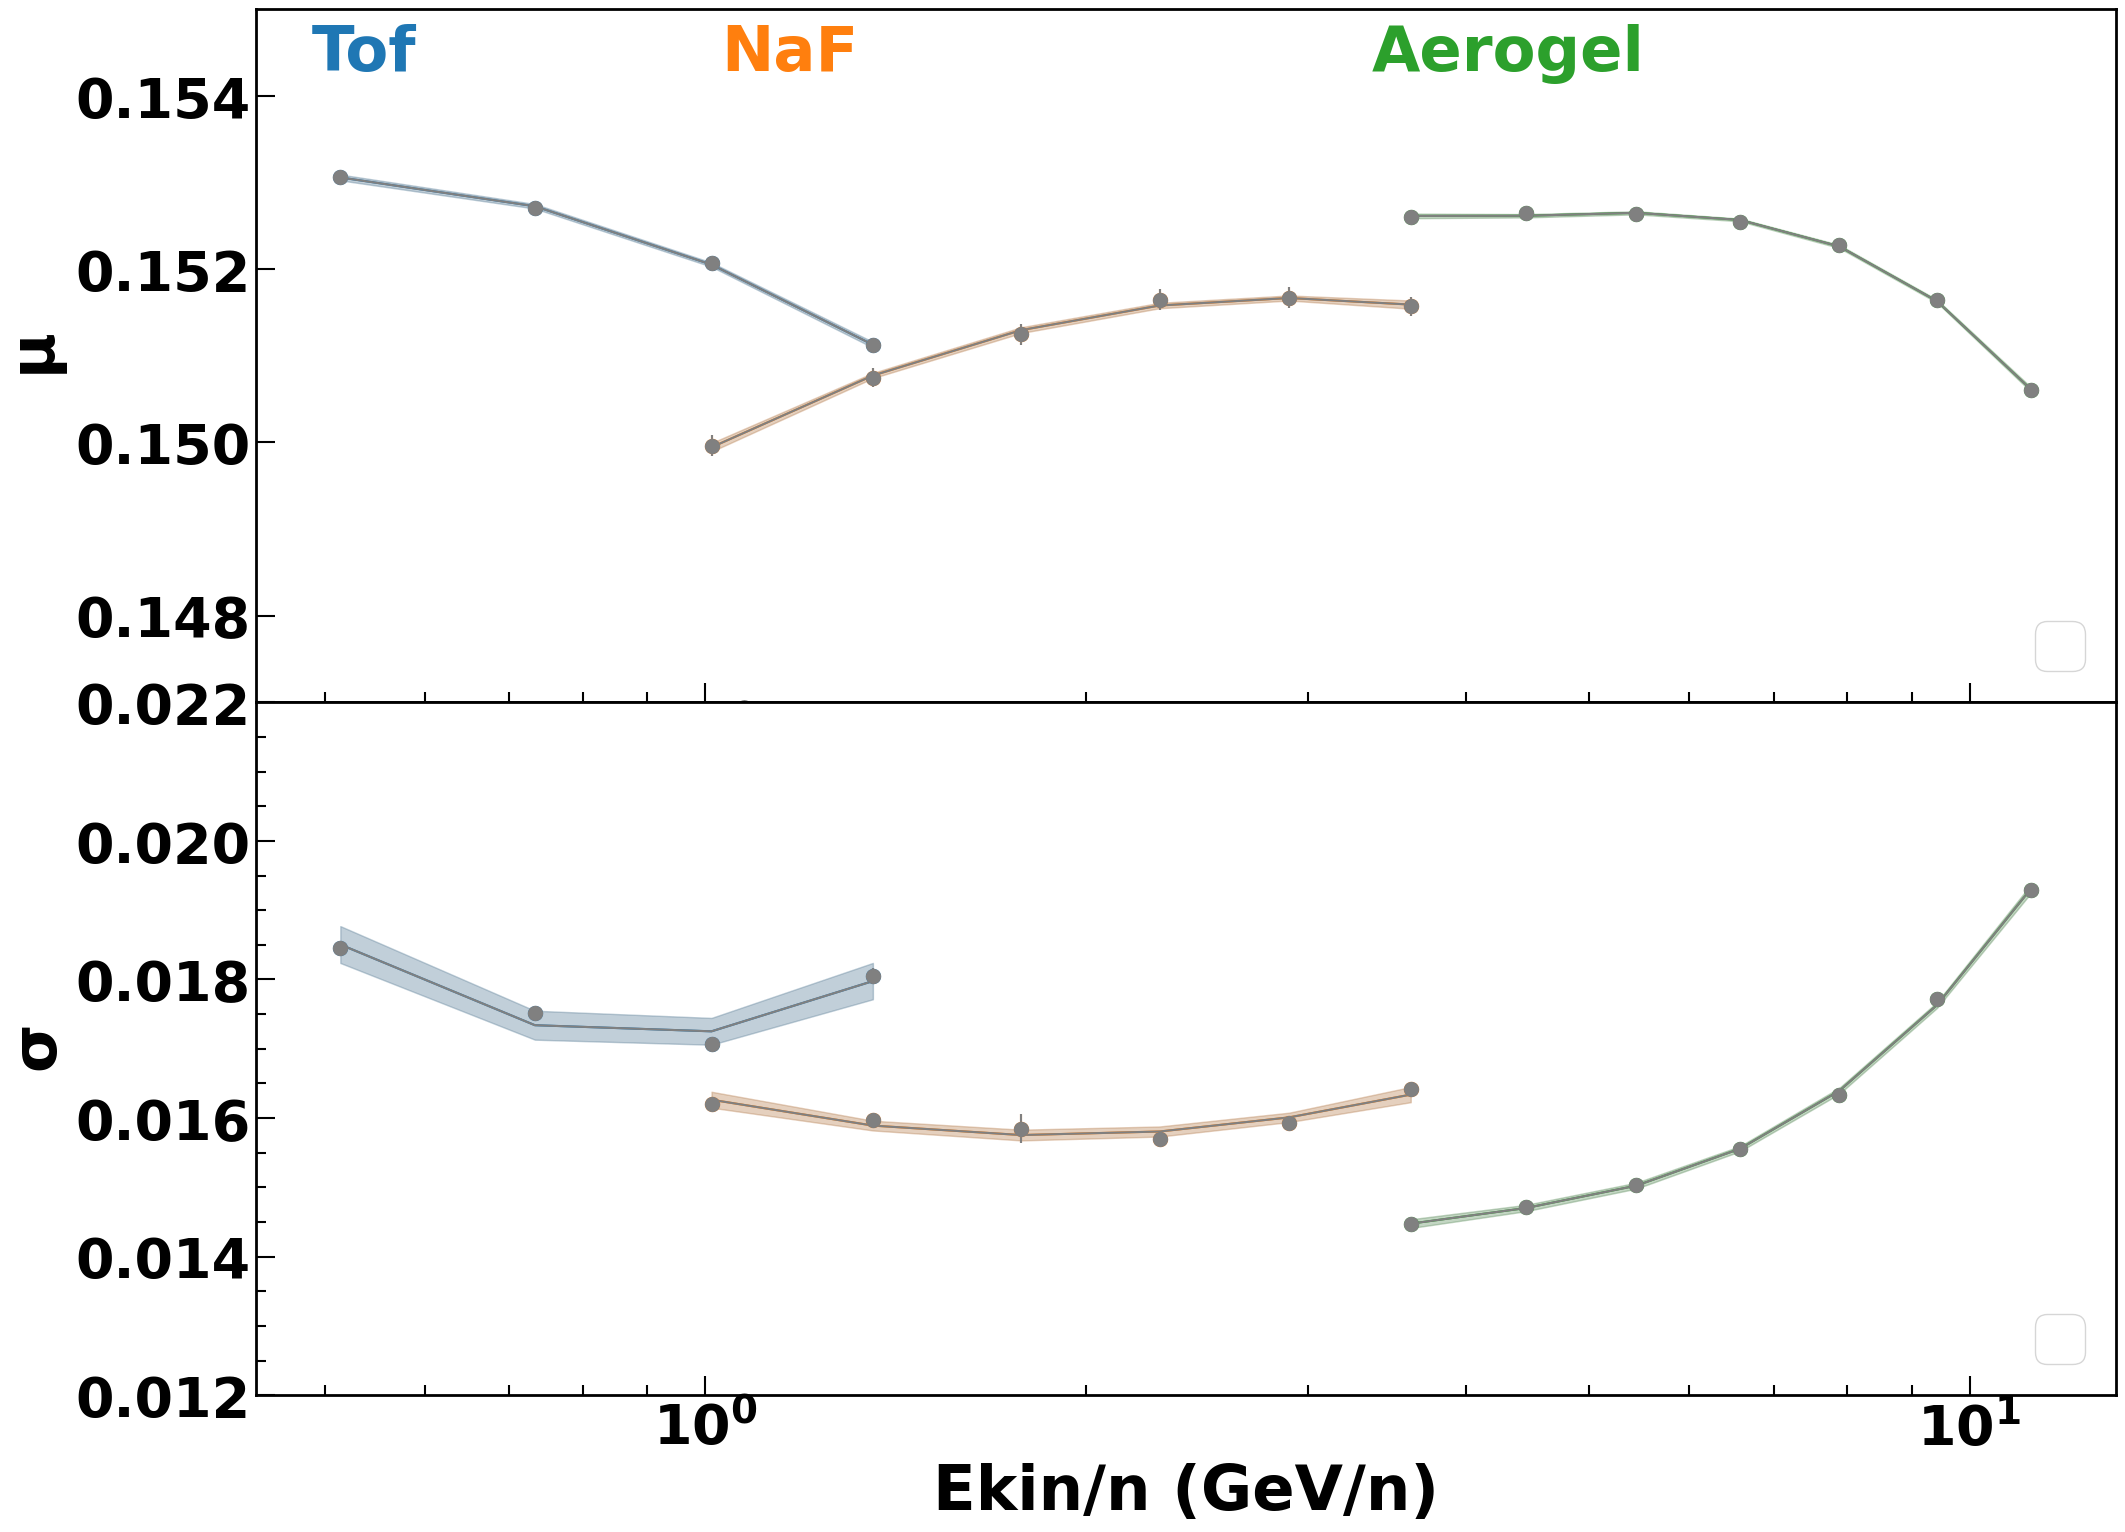

In [18]:
from tools.constants import ISOTOPES_MASS
from tools.massfit_tools import get_fitpdferrorband
import uncertainties                                                                                                                                                                                               
from uncertainties import unumpy                                                                                                                                                                                   
from uncertainties import ufloat   
################################################
#read the tuned and untuned mc and plot the pars
#################################################

def plot_parswitherr(fig, ax1, graph_mean, col, p0_mean, labelname=None):
    plot_graph(fig, ax1, graph_mean, color=col, style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label=labelname)
    popt, pcov = curve_fit(poly, np.log(graph_mean.xvalues), graph_mean.yvalues, p0 = p0_mean)  
    ax1.plot(graph_mean.xvalues, poly(np.log(graph_mean.xvalues), *popt), "-", color=col)
    polypars = uncertainties.correlated_values(popt, np.array(pcov)) 
    mufit_lower, mufit_upper = get_fitpdferrorband(np.log(graph_mean.xvalues), polypars, upoly)  
    ax1.fill_between(graph_mean.xvalues, mufit_lower, mufit_upper, color=col, alpha=0.2)   
    
filepathU = {'Tof':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBeta_Rebin/',
             'NaF': '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBeta_Rebin/',
             'Agl':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBeta_Rebin/'}
filepathT = {'Tof':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBeta_Rebin/',
             'NaF': '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBeta_Rebin/',
             'Agl':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBeta_Rebin/'}

#filepathT = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBetaExtLow_Rebin/'
#filepathU = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBetaExtUp_Rebin/'
itername = 'iter0'

graph_meanU = {}
graph_sigmaU = {}

graph_meanT = {}
graph_sigmaT = {}
graph_parsUntuned = {dec: {} for dec in detectors}
graph_parsTuned = {dec: {} for dec in detectors}

decs = {'Tof', 'NaF', 'Agl'}
for dec in decs:
    file_mean = filepathU[dec] + f'df_mean_{itername}.npz'
    file_sigma = filepathU[dec] + f'df_sigma_{itername}.npz'
    file_mean2 = filepathT[dec] + f'df_mean_{itername}.npz'
    file_sigma2 = filepathT[dec] + f'df_sigma_{itername}.npz'

    df_mean = np.load(f'{file_mean}')
    df_sig = np.load(f'{file_sigma}')
    df_mean2 = np.load(f'{file_mean2}')
    df_sig2 = np.load(f'{file_sigma2}')
    
    graph_meanU[dec] = MGraph.from_file(df_mean, f'graph_mean_{dec}')
    graph_sigmaU[dec] = MGraph.from_file(df_sig, f'graph_sigma_{dec}')
    graph_meanT[dec] = MGraph.from_file(df_mean2, f'graph_mean_{dec}')
    graph_sigmaT[dec] = MGraph.from_file(df_sig2, f'graph_sigma_{dec}')
    
    graph_parsUntuned[dec]['mean'] =  graph_meanU[dec]
    graph_parsTuned[dec]['mean'] = graph_meanT[dec]
    graph_parsUntuned[dec]['sigma'] =  graph_sigmaU[dec]
    graph_parsTuned[dec]['sigma'] = graph_sigmaT[dec]
    
slicevalue_trueratio ={'Tof':[0.3, 1.2], 'NaF':[0.9, 6.0], 'Agl':[3.5, 12.0]}


fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=(24, 18))    
xaxistext = {"Tof": 0.03, "NaF": 0.25, "Agl": 0.6}
p0_mean = {'Tof':[0.152, 0.1, 0.1], 'NaF':[0.152, 0.1, 0.1], "Agl":[0.152, 0.1, 0.1, 0.1]}
p0_sigma = {'Tof':[0.01, 0.01, 0.01], 'NaF':[0.01, 0.1, 0.1], "Agl":[0.01, 0.1, 0.1, 0.1]}

for dec in decs: 
    plot_parswitherr(fig, ax1, graph_meanU[dec], DETECTOR_COLOR[dec], p0_mean[dec])
    plot_parswitherr(fig, ax1, graph_meanT[dec], 'grey', p0_mean[dec])
    plot_parswitherr(fig, ax2, graph_sigmaU[dec], DETECTOR_COLOR[dec], p0_sigma[dec])
    plot_parswitherr(fig, ax2, graph_sigmaT[dec], 'grey', p0_sigma[dec])
    ax1.text(xaxistext[dec], 0.98,  f"{DETECTOR_LABEL[dec]}", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=DETECTOR_COLOR[dec], fontweight="bold")      
    
#ax1.text(0.5, 0.5,  f"", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='grey', fontweight="bold")      
set_plot_style(ax1) 
set_plot_style(ax2)  


equation_text = r'$\mathrm{\mu = p_{0} + p_{1} \cdot x + p_{2} \cdot x^{2} , x = \log(E)}$'
#ax1.text(0.03, 0.15, equation_text, fontsize=35, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='black') 
equation_sig = r'$\mathrm{\sigma = p_{0} + p_{1} \cdot x + p_{2} \cdot x^{2} + (p_{3} \cdot x^{3}), x = \log(E)}$'
equation_sig = r'$\mathrm{\sigma = \sum_{i}p_{i}\cdot x^{i}, x = \log(E)}$'
#ax2.text(0.03, 0.18, equation_sig, fontsize=35, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color='black') 
plt.subplots_adjust(hspace=.0)                                                                                                                                                                   
#ax1.set_xticklabels([])                                                                                                                                                                          
ax1.set_xlabel("Ekin/n (GeV/n)") 

ax1.set_ylim([0.147, 0.155])
ax2.set_ylim([0.012, 0.022])
ax2.set_xlabel('Ekin/n (GeV/n)', fontsize=fontsize1)
ax1.set_ylabel(r'$\mathrm{\mu}$', fontsize=fontsize1)
ax2.set_ylabel(r'$\mathrm{\sigma}$', fontsize=fontsize1)
ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=fontsize1)
ax2.legend(loc='lower right', fontsize=fontsize1)
ax2.set_xscale('log')
savefig_tofile(fig, plotfile, 'mean_sigma_iter0_All', 1)




Agl sigma


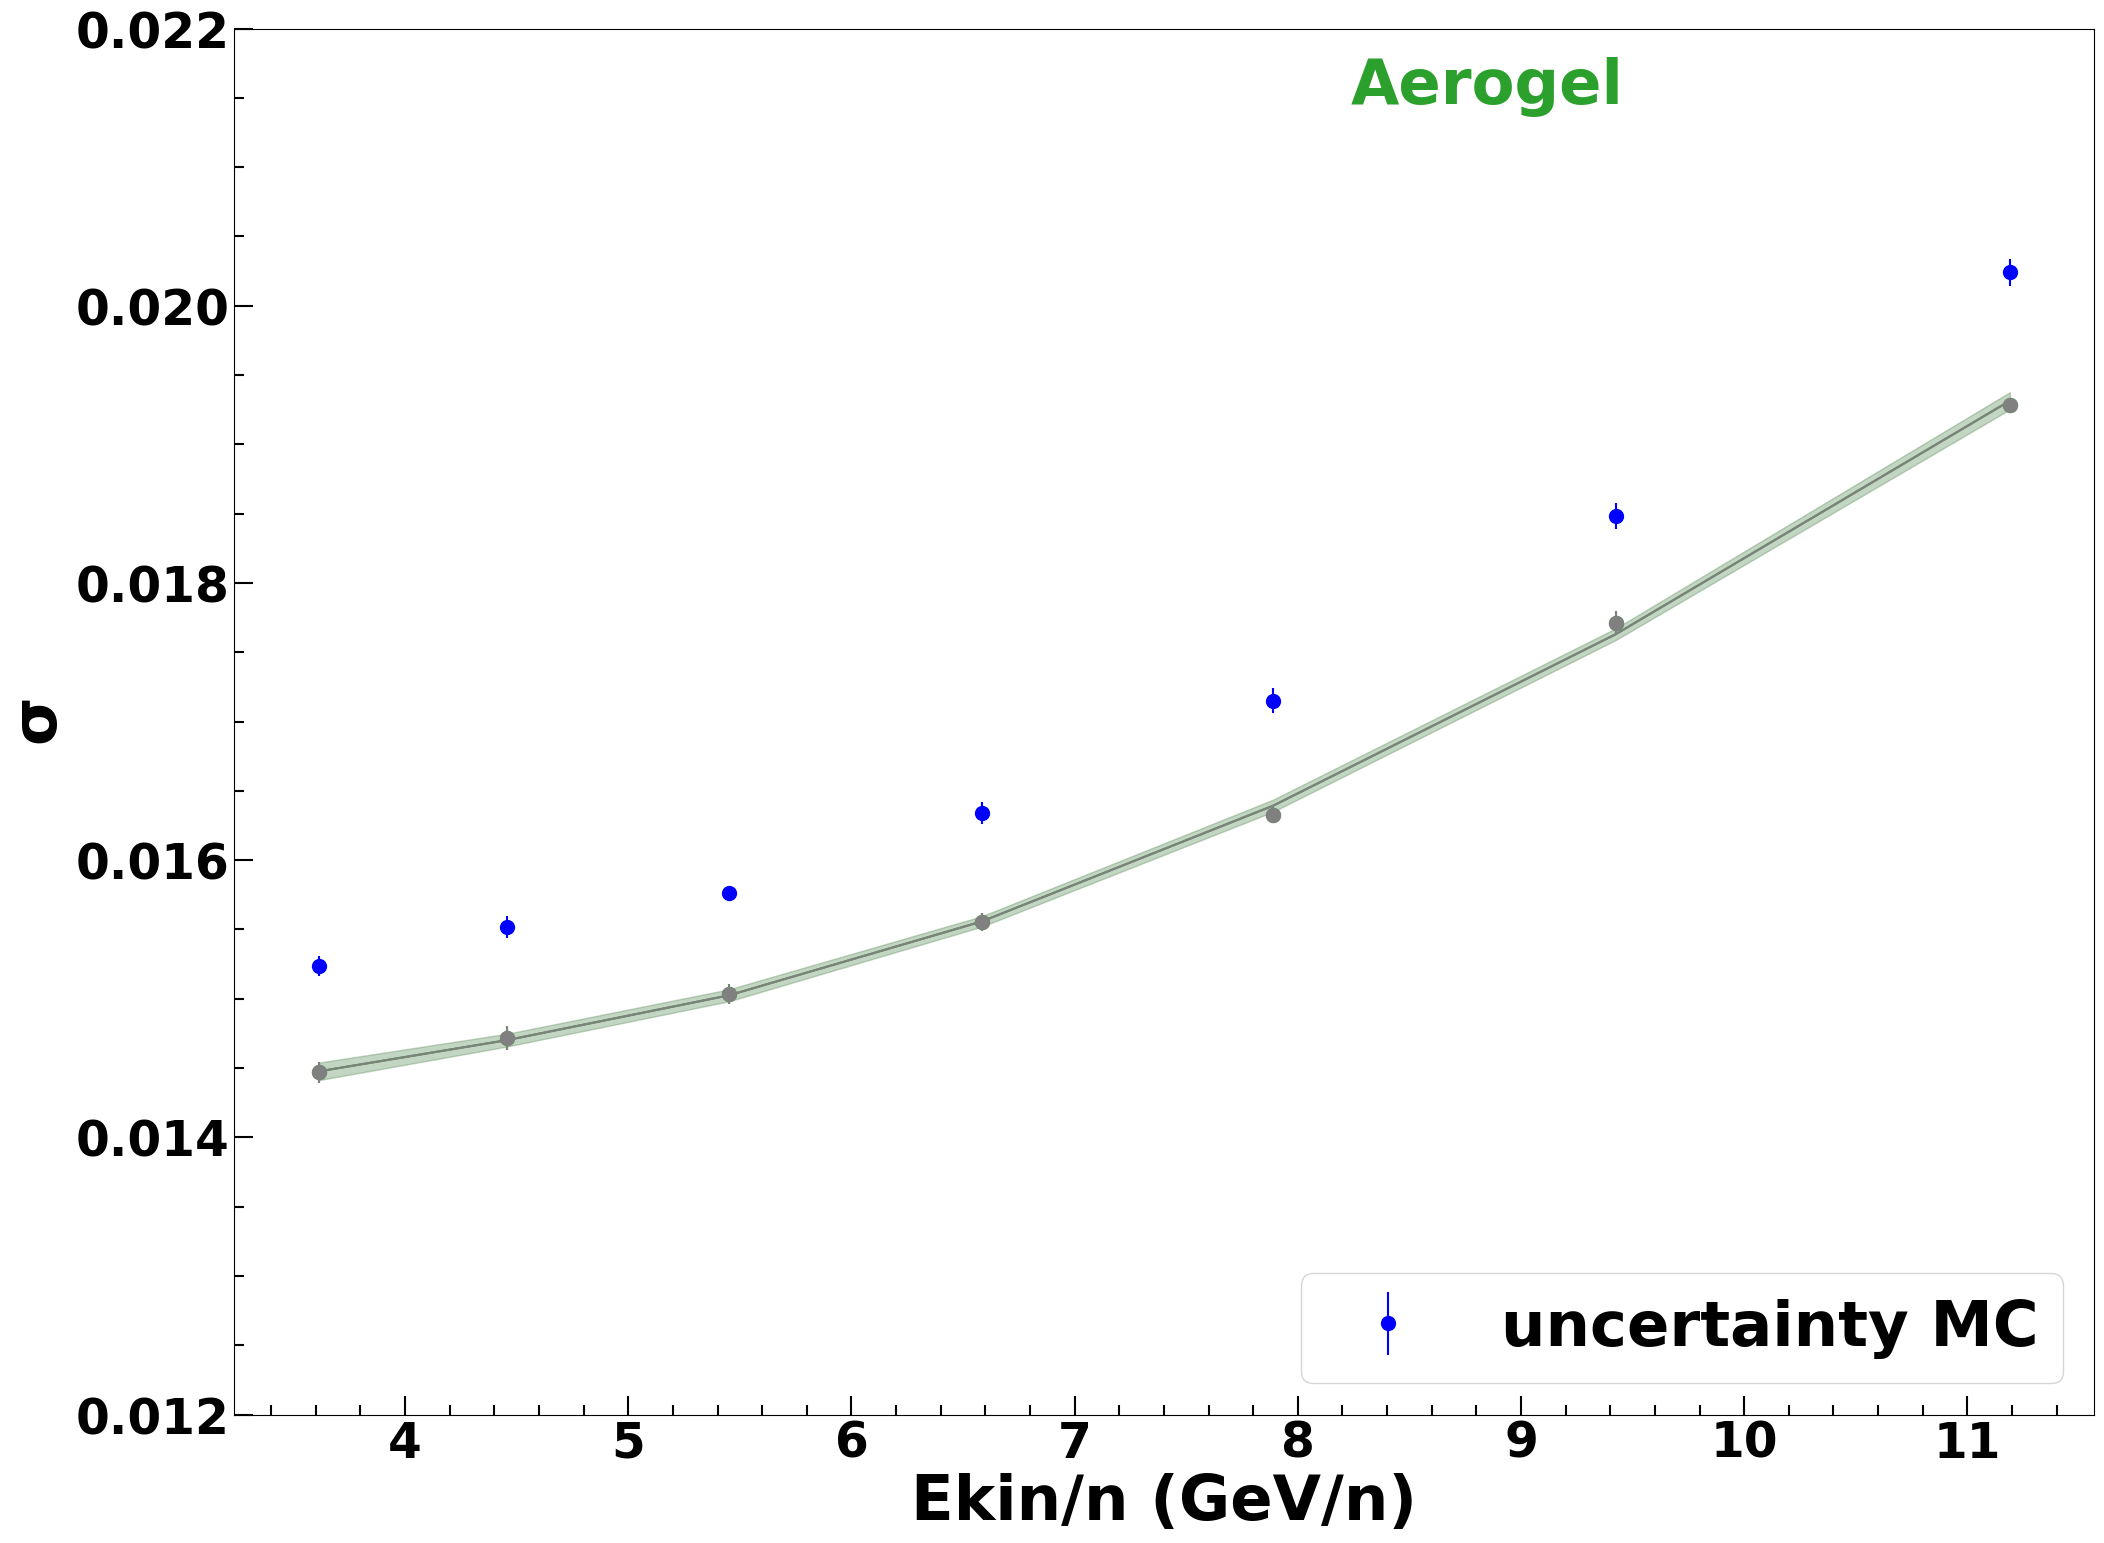

In [19]:
fig, ax1 = plt.subplots(1, 1, figsize=(24, 18))  
dec = 'Agl'
thispar = 'sigma'

filepathTuneMax = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCRigModify5Percent'
df_sigma_maxscale = np.load(os.path.join(filepathTuneMax, f'df_sigma_{itername}.npz'))
graph_sigmaMaxScale = MGraph.from_file(df_sigma_maxscale, f'graph_sigma_{dec}')
plot_graph(fig, ax1, graph_sigmaMaxScale, color='blue', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label='uncertainty MC')


plot_parswitherr(fig, ax1, graph_sigmaU[dec], DETECTOR_COLOR[dec], p0_sigma[dec])
plot_parswitherr(fig, ax1, graph_sigmaT[dec], 'grey', p0_sigma[dec])
ax1.text(xaxistext[dec], 0.98,  f"{DETECTOR_LABEL[dec]}", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=DETECTOR_COLOR[dec], fontweight="bold")      
ax1.set_ylim([0.012, 0.022])
#graph_fitlow[dec][par], graph_fitup[dec][par] = plot_errband_constraint(fig, ax1, df_graph_parslim, graph_parsUntuned[dec][par], graph_parsTuned[dec][par],  DETECTOR_COLOR[dec], par, polyfitp0[dec][par])
#ax1.fill_between(graph_fitlow[dec][par].xvalues, graph_fitlow[dec][par].yvalues, graph_fitup[dec][par].yvalues , color=DETECTOR_COLOR[dec], alpha=0.3) 
#plt.subplots_adjust(hspace=.0)                                                                                                                                                                                                                                                                                                                                            
ax1.set_xlabel("Ekin/n (GeV/n)")     
ax1.set_ylim(ylim_range_be7[thispar])
ax1.set_ylabel(r'$\mathrm{\mu}$', fontsize=fontsize1)
#ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=fontsize1)
ax1.set_ylabel(f'{par_names_axes[thispar]}', fontsize=fontsize1)
print(dec, thispar)
savefig_tofile(fig, plotfile, f'{dec}_sigma_uplowband', 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


dict_items([('Tof', {'mean': <tools.graphs.MGraph object at 0x7f9317889ff0>, 'sigma': <tools.graphs.MGraph object at 0x7f93173d7cd0>, 'fraccore': <tools.graphs.MGraph object at 0x7f9314b85840>, 'sigma_ratio': <tools.graphs.MGraph object at 0x7f9314b84c70>, 'asy_factor': <tools.graphs.MGraph object at 0x7f9314b87970>}), ('NaF', {'mean': <tools.graphs.MGraph object at 0x7f9317849570>, 'sigma': <tools.graphs.MGraph object at 0x7f93146b9ba0>, 'fraccore': <tools.graphs.MGraph object at 0x7f9314b87820>, 'sigma_ratio': <tools.graphs.MGraph object at 0x7f9314d40fa0>, 'asy_factor': <tools.graphs.MGraph object at 0x7f9314d413f0>}), ('Agl', {'mean': <tools.graphs.MGraph object at 0x7f93147d5240>, 'sigma': <tools.graphs.MGraph object at 0x7f9314a42bf0>, 'fraccore': <tools.graphs.MGraph object at 0x7f9314b86e60>, 'sigma_ratio': <tools.graphs.MGraph object at 0x7f9314d42a10>, 'asy_factor': <tools.graphs.MGraph object at 0x7f9314d432b0>})])


Text(0.5, 0, 'Ekin/n (GeV/n)')

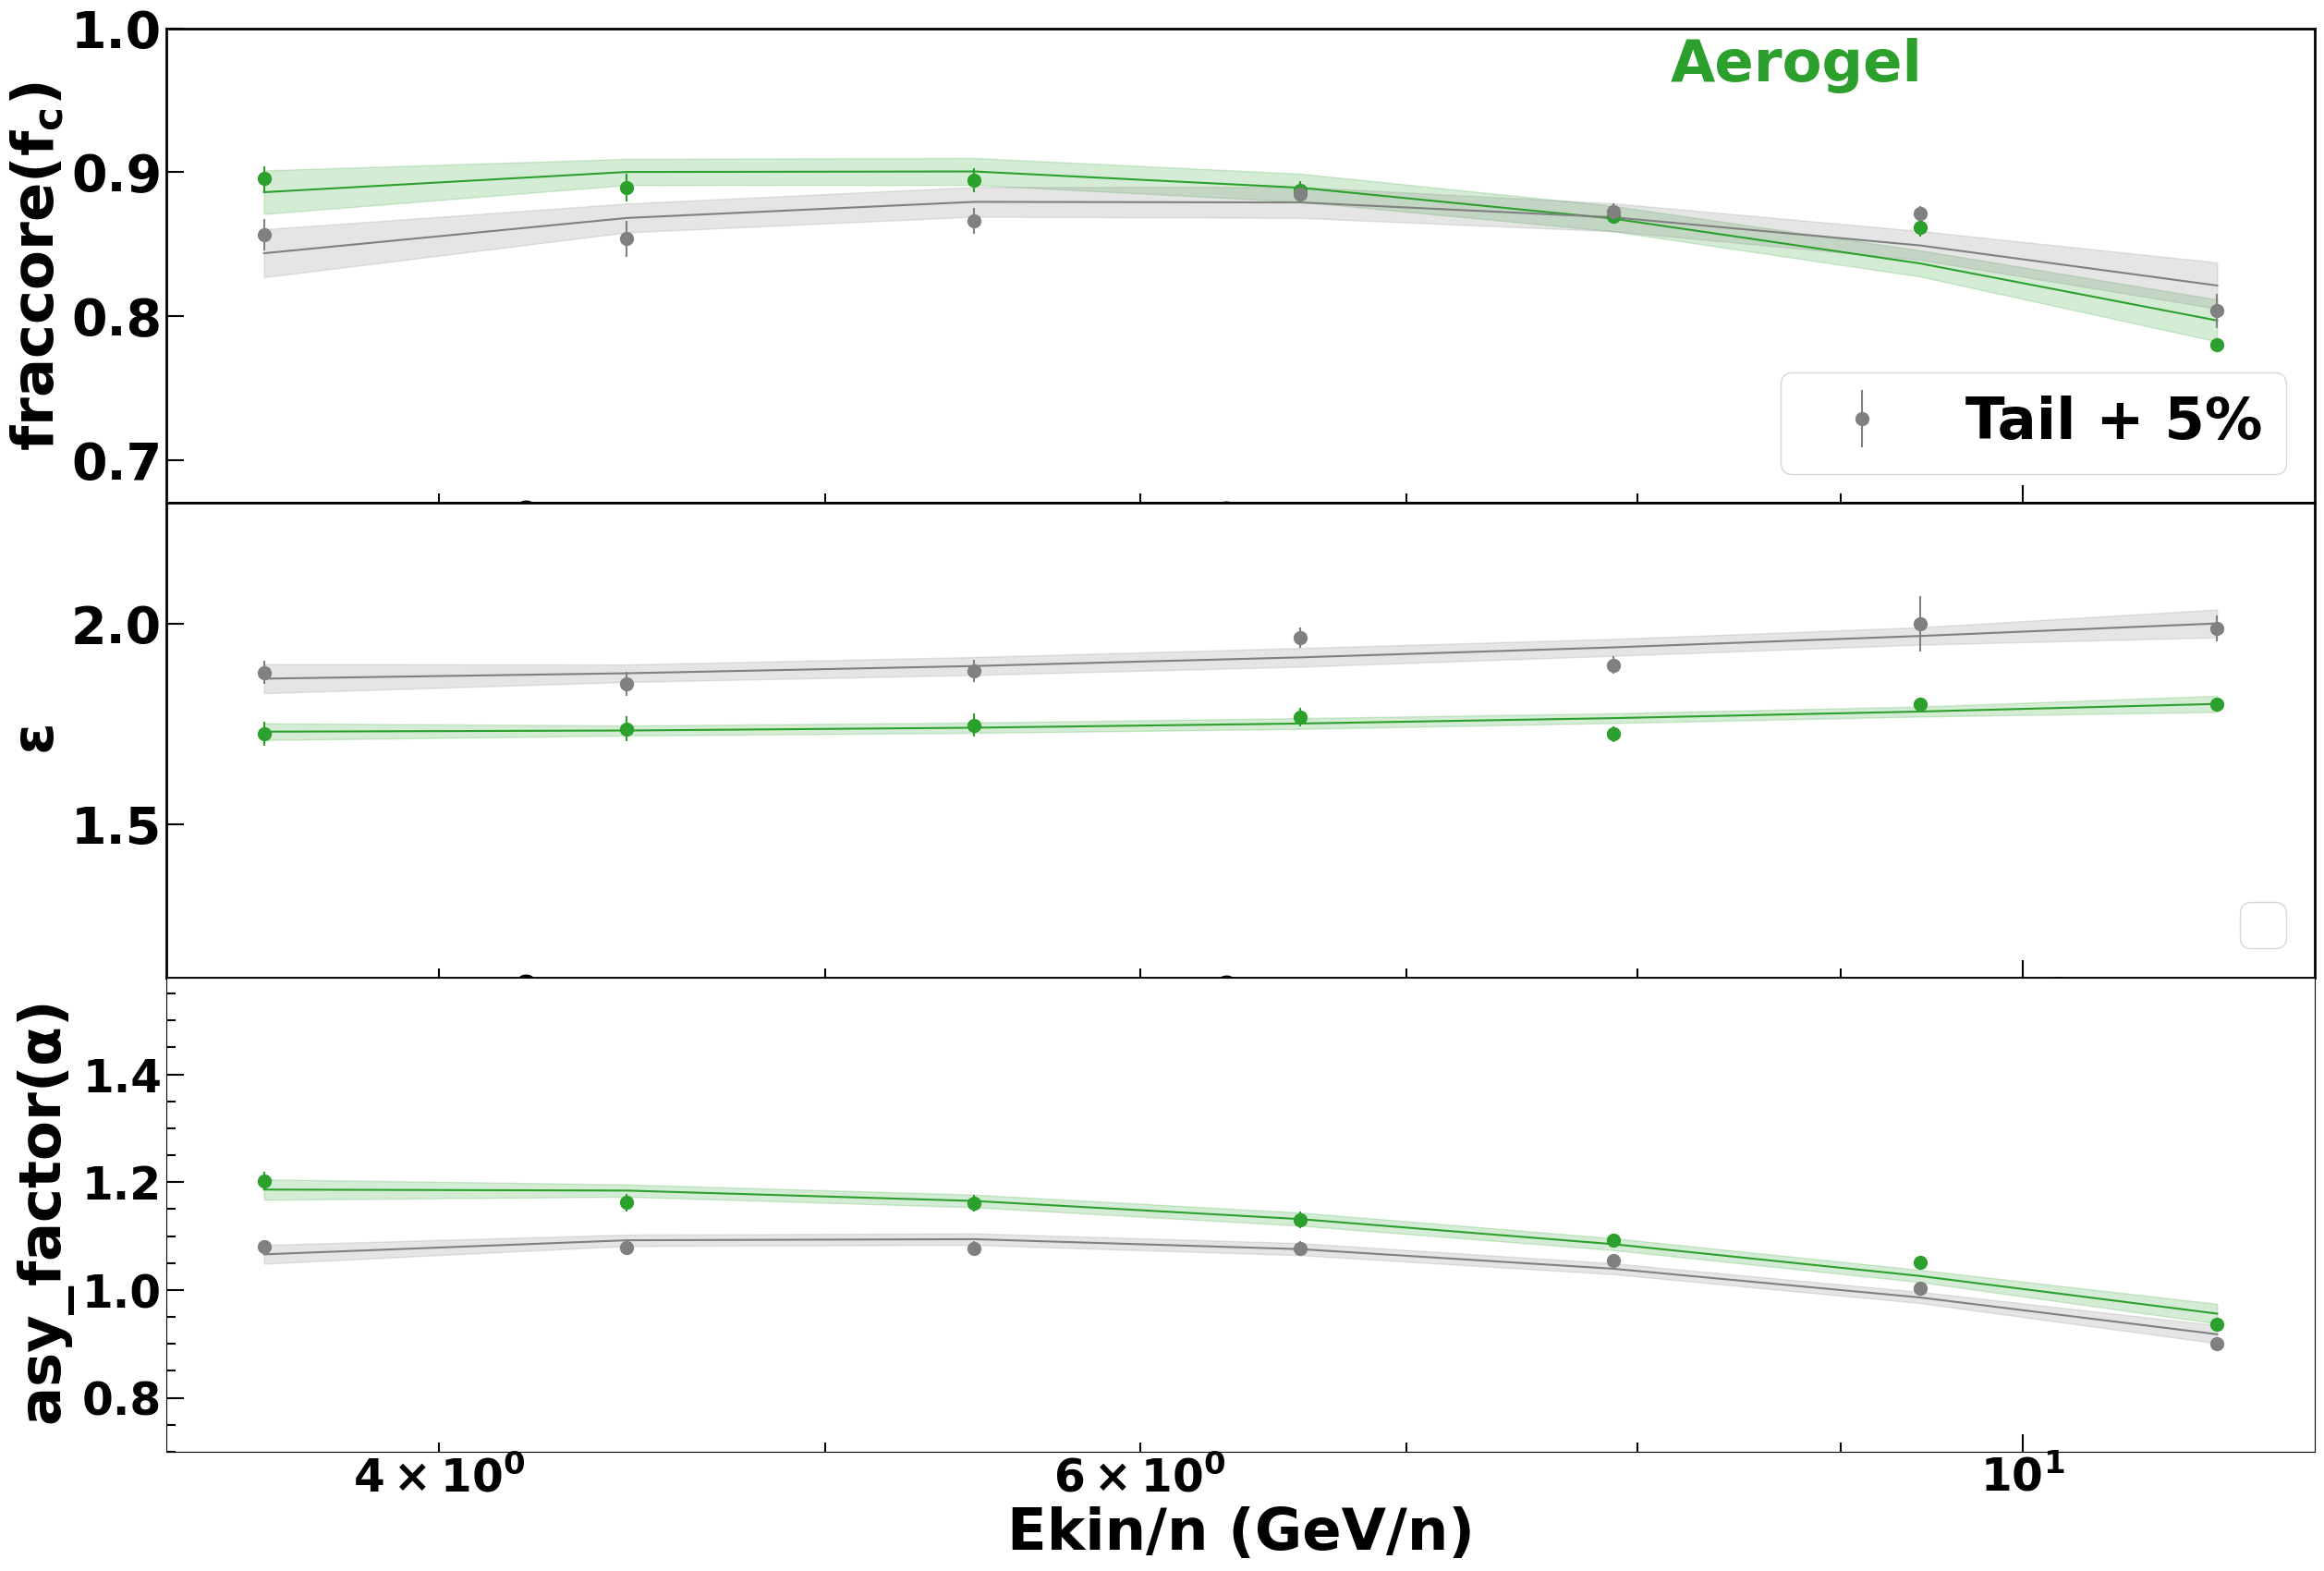

In [21]:
from tools.constants import ISOTOPES_MASS
from tools.massfit_tools import get_fitpdferrorband
import uncertainties                                                                                                                                                                                               
from uncertainties import unumpy                                                                                                                                                                                   
from uncertainties import ufloat  

n_iter = 'iter0'

#filepathU = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBetaExtUp_Rebin'
#filepathT0 = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMassTunedBetaHighR_Rebin/fitBe7/'
#filepathT = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBetaExtLow_Rebin'

#filepathT = {'Tof':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBeta_Rebin/',
#             'NaF': '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBeta_Rebin/',
#             'Agl':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBeta_Rebin/'}

filepathT = {'Tof':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCRigTailModify5Percent/',
             'NaF': '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCRigTailModify5Percent/',
             'Agl':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCRigTailModify5Percent/'}

filepathU = {'Tof':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBeta_Rebin/',
             'NaF': '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBeta_Rebin/',
             'Agl':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBeta_Rebin/'}



graph_fraccoreU = {}
graph_fraccoreT = {}

graph_sigmaratioU = {}
graph_sigmaratioT = {}

graph_alphaU = {}
graph_alphaT = {}
ylim_range_be7 = {'mean'  :     [0.145, 0.16], 'sigma' : [0.012, 0.022], 'sigma_ratio':[1.2, 2.5], 'asy_factor': [0.8, 1.6], 'fraccore':   [0.7, 1.0], "norm":       [0, 40]} 
decs = ['Tof', 'NaF','Agl']
for dec in decs:
    df_fraccoreU = np.load(os.path.join(filepathU[dec], f'df_fraccore_{n_iter}.npz'))
    df_fraccoreT = np.load(os.path.join(filepathT[dec], f'df_fraccore_{n_iter}.npz'))
    df_sigmaratioU = np.load(os.path.join(filepathU[dec], f'df_sigma_ratio_{n_iter}.npz'))
    df_sigmaratioT = np.load(os.path.join(filepathT[dec], f'df_sigma_ratio_{n_iter}.npz'))
    df_alphaU = np.load(os.path.join(filepathU[dec], f'df_asy_factor_{n_iter}.npz'))
    df_alphaT = np.load(os.path.join(filepathT[dec], f'df_asy_factor_{n_iter}.npz'))
    
    graph_fraccoreU[dec] = MGraph.from_file(df_fraccoreU, f'graph_fraccore_{dec}')
    graph_fraccoreT[dec] = MGraph.from_file(df_fraccoreT, f'graph_fraccore_{dec}')
    graph_sigmaratioU[dec] = MGraph.from_file(df_sigmaratioU, f'graph_sigma_ratio_{dec}')
    graph_sigmaratioT[dec] = MGraph.from_file(df_sigmaratioT, f'graph_sigma_ratio_{dec}')
    graph_alphaU[dec] = MGraph.from_file(df_alphaU, f'graph_asy_factor_{dec}')
    graph_alphaT[dec] = MGraph.from_file(df_alphaT, f'graph_asy_factor_{dec}')
    graph_parsUntuned[dec]['fraccore'] =  graph_fraccoreU[dec]
    graph_parsTuned[dec]['fraccore'] = graph_fraccoreT[dec]
    graph_parsUntuned[dec]['sigma_ratio'] =  graph_sigmaratioU[dec]
    graph_parsTuned[dec]['sigma_ratio'] = graph_sigmaratioT[dec]
    graph_parsUntuned[dec]['asy_factor'] =  graph_alphaU[dec]
    graph_parsTuned[dec]['asy_factor'] = graph_alphaT[dec]

print(graph_parsUntuned.items())
slicevalue_trueratio ={'Tof':[0.3, 1.2], 'NaF':[0.9, 6.0], 'Agl':[3.5, 12.0]}
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios':[0.33, 0.33, 0.33]}, figsize=(30, 20))                                                                     
xaxistext = {"Tof": 0.03, "NaF": 0.25, "Agl": 0.7}
p0_mean = {'Tof':[0.9], 'NaF':[0.8], "Agl":[0.8]}
p0_sigma = {'Tof':[1.0, 0.1, 0.1], 'NaF':[1.0], "Agl":[1.0, 0.1, 0.1]}

for dec in ['Agl']: 
    plot_parswitherr(fig, ax1, graph_fraccoreU[dec], DETECTOR_COLOR[dec], p0_sigma[dec])
    plot_parswitherr(fig, ax1, graph_fraccoreT[dec], 'grey', p0_sigma[dec], labelname = 'Tail + 5%' if dec == 'Agl' else None)
    plot_parswitherr(fig, ax2, graph_sigmaratioU[dec], DETECTOR_COLOR[dec], p0_sigma[dec])
    plot_parswitherr(fig, ax2, graph_sigmaratioT[dec], 'grey', p0_sigma[dec])
    plot_parswitherr(fig, ax3, graph_alphaU[dec], DETECTOR_COLOR[dec], p0_sigma[dec])
    plot_parswitherr(fig, ax3, graph_alphaT[dec], 'grey', p0_sigma[dec])
    ax1.text(xaxistext[dec], 0.98,  f"{DETECTOR_LABEL[dec]}", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=DETECTOR_COLOR[dec], fontweight="bold")      
            
#ax1.text(0.3, 0.5,  f"Untuned MC", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='grey', fontweight="bold")      
set_plot_style(ax1) 
set_plot_style(ax2)  
equation_text = r'$\mathrm{\mu = p_{0} + p_{1} \cdot x + p_{2} \cdot x^{2} , x = \log(E)}$'
#ax1.text(0.03, 0.15, equation_text, fontsize=35, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='black') 
equation_sig = r'$\mathrm{\sigma = p_{0} + p_{1} \cdot x + p_{2} \cdot x^{2} + (p_{3} \cdot x^{3}), x = \log(E)}$'
equation_sig = r'$\mathrm{\sigma = \sum_{i}p_{i}\cdot x^{i}, x = \log(E)}$'
#ax2.text(0.03, 0.18, equation_sig, fontsize=35, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color='black') 
plt.subplots_adjust(hspace=.0)                                                                                                                                                                   
#ax1.set_xticklabels([])                                                                                                                                                                          
ax1.set_xlabel("Ekin/n (GeV/n)") 
#ax1.set_xscale('log')
#ax1.fill_betweenx(np.linspace(0.75, 0.8, 100), 1.0, 4.0, alpha=0.1, color="tab:blue") 
#ax1.axhline(y=ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'], color='orange', linestyle='--') 

#ax1.axhline(y=1.0, color='orange', linestyle='--')  
#ax1.axhline(y=0.77869417, color='black', linestyle='--')  

ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=fontsize1)
ax2.legend(loc='lower right', fontsize=fontsize1)
ax2.set_xscale('log')
ax3.set_xscale('log')

ax1.set_ylabel(r'$\mathrm{fraccore (f_{c})}$', fontsize=fontsize1)
ax2.set_ylabel(r'$\mathrm{\epsilon}$', fontsize=fontsize1)
ax3.set_ylabel(r'$\mathrm{asy\_factor (\alpha)}$', fontsize=fontsize1)
ax1.set_ylim([0.67, 1.0])
ax2.set_ylim([1.12, 2.3])
ax3.set_ylim([0.7, 1.58])
ax3.set_xlabel('Ekin/n (GeV/n)', fontsize=fontsize1)
#savefig_tofile(fig, plotfile, 'asygaus_tailpars_iter0_AglTailPlus5', 1)




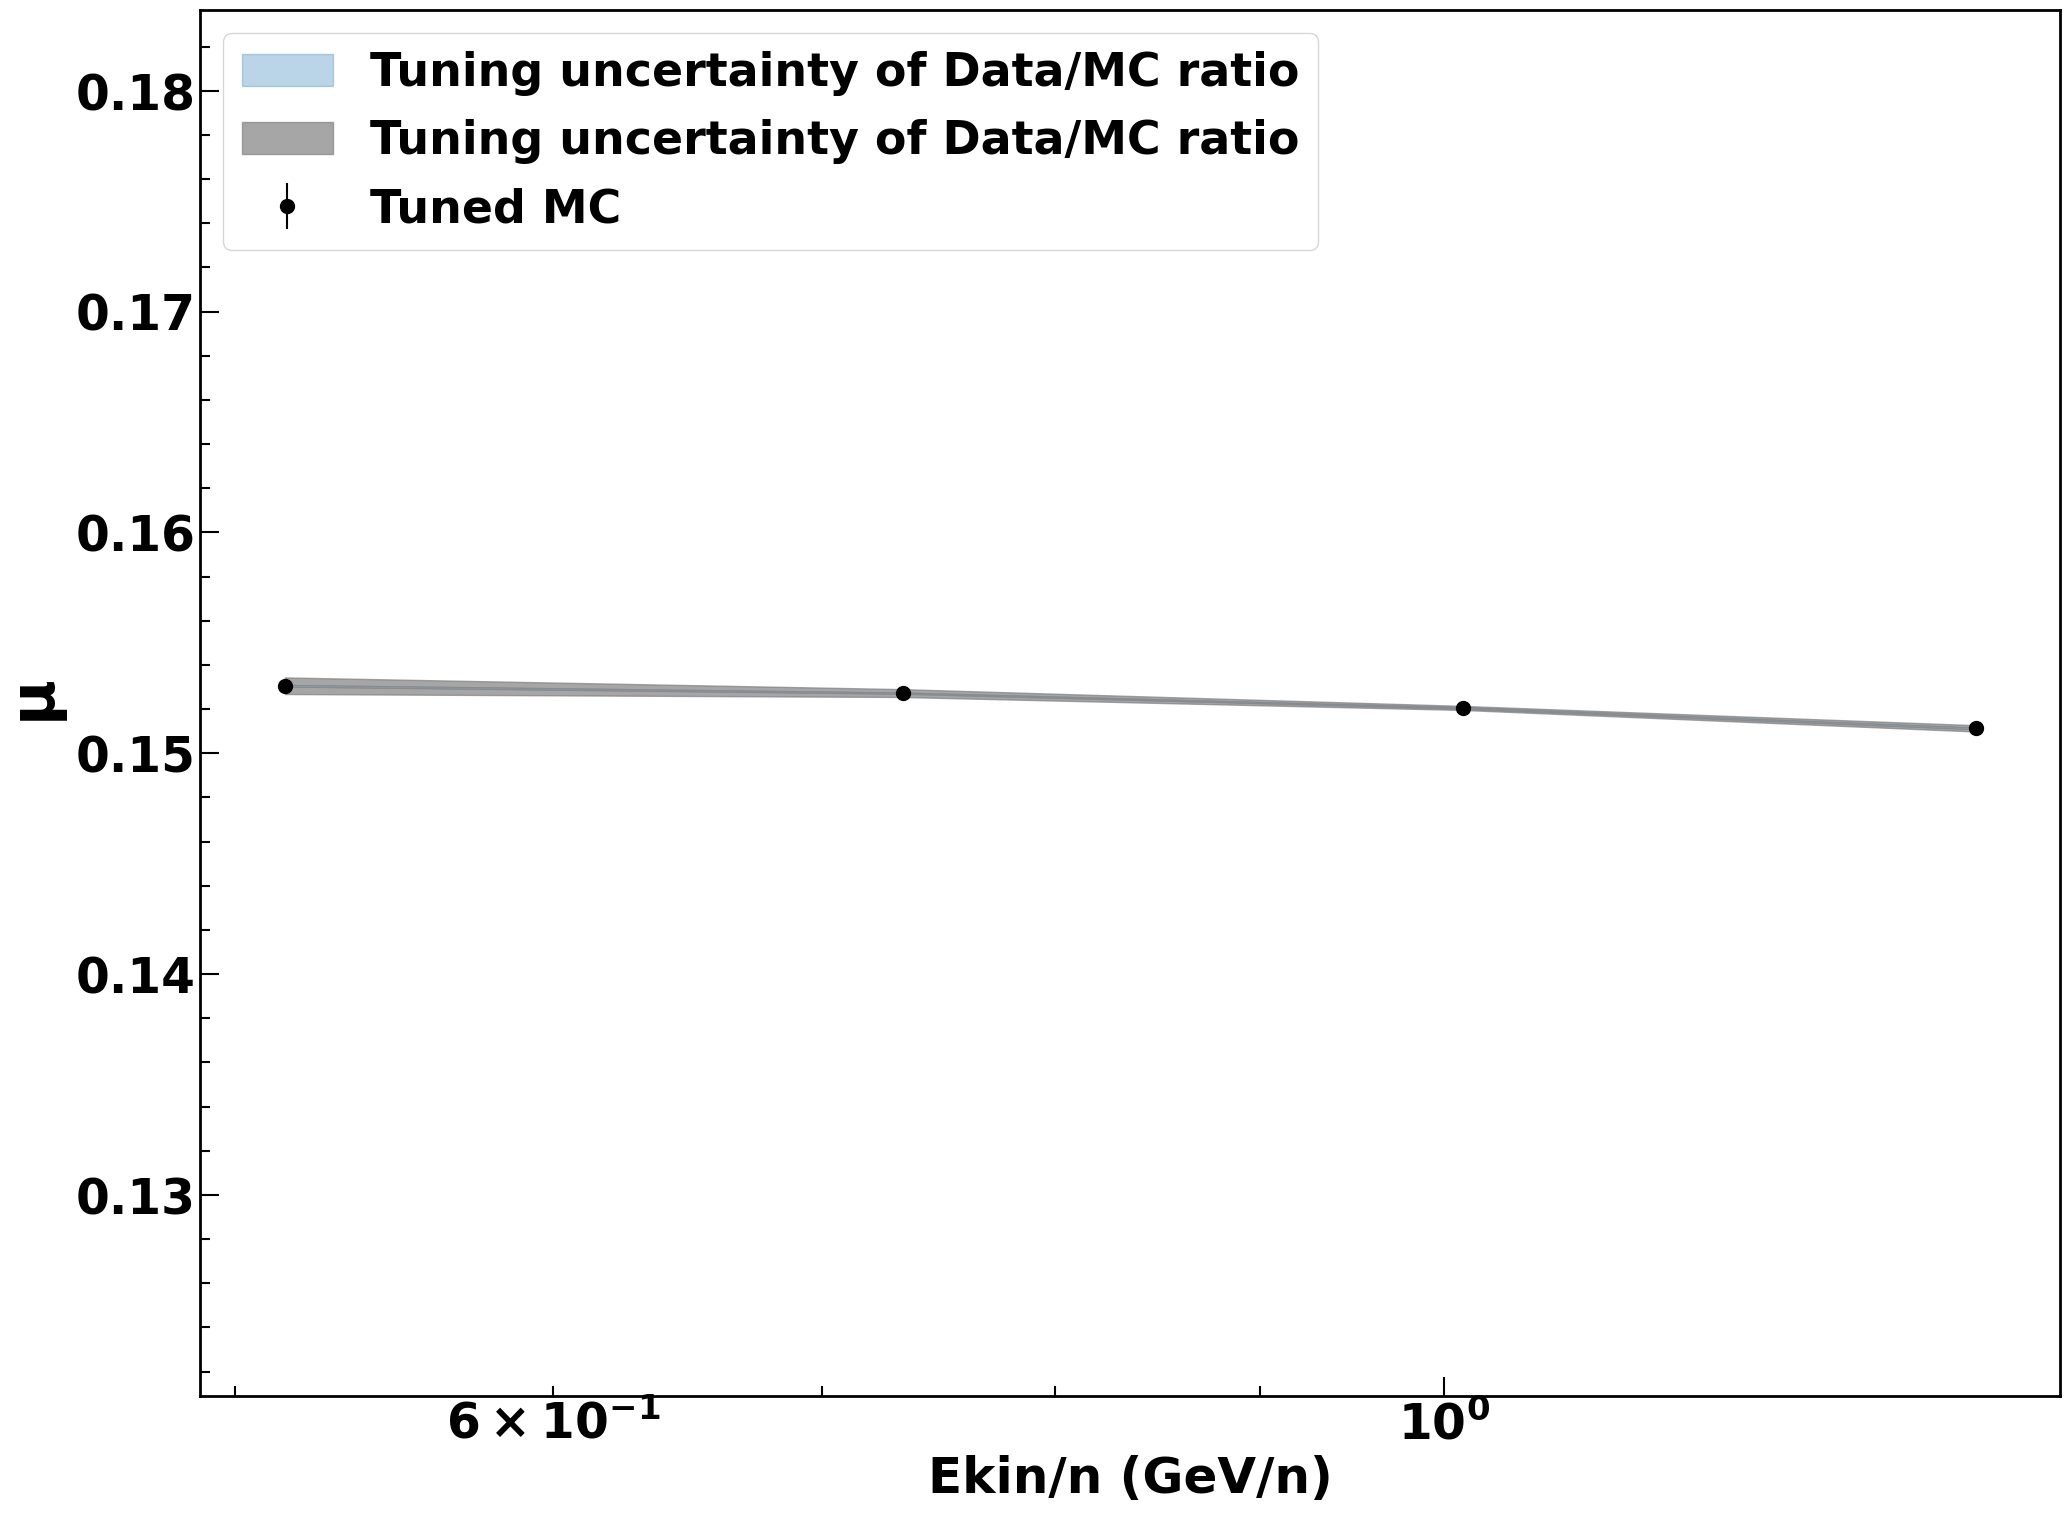

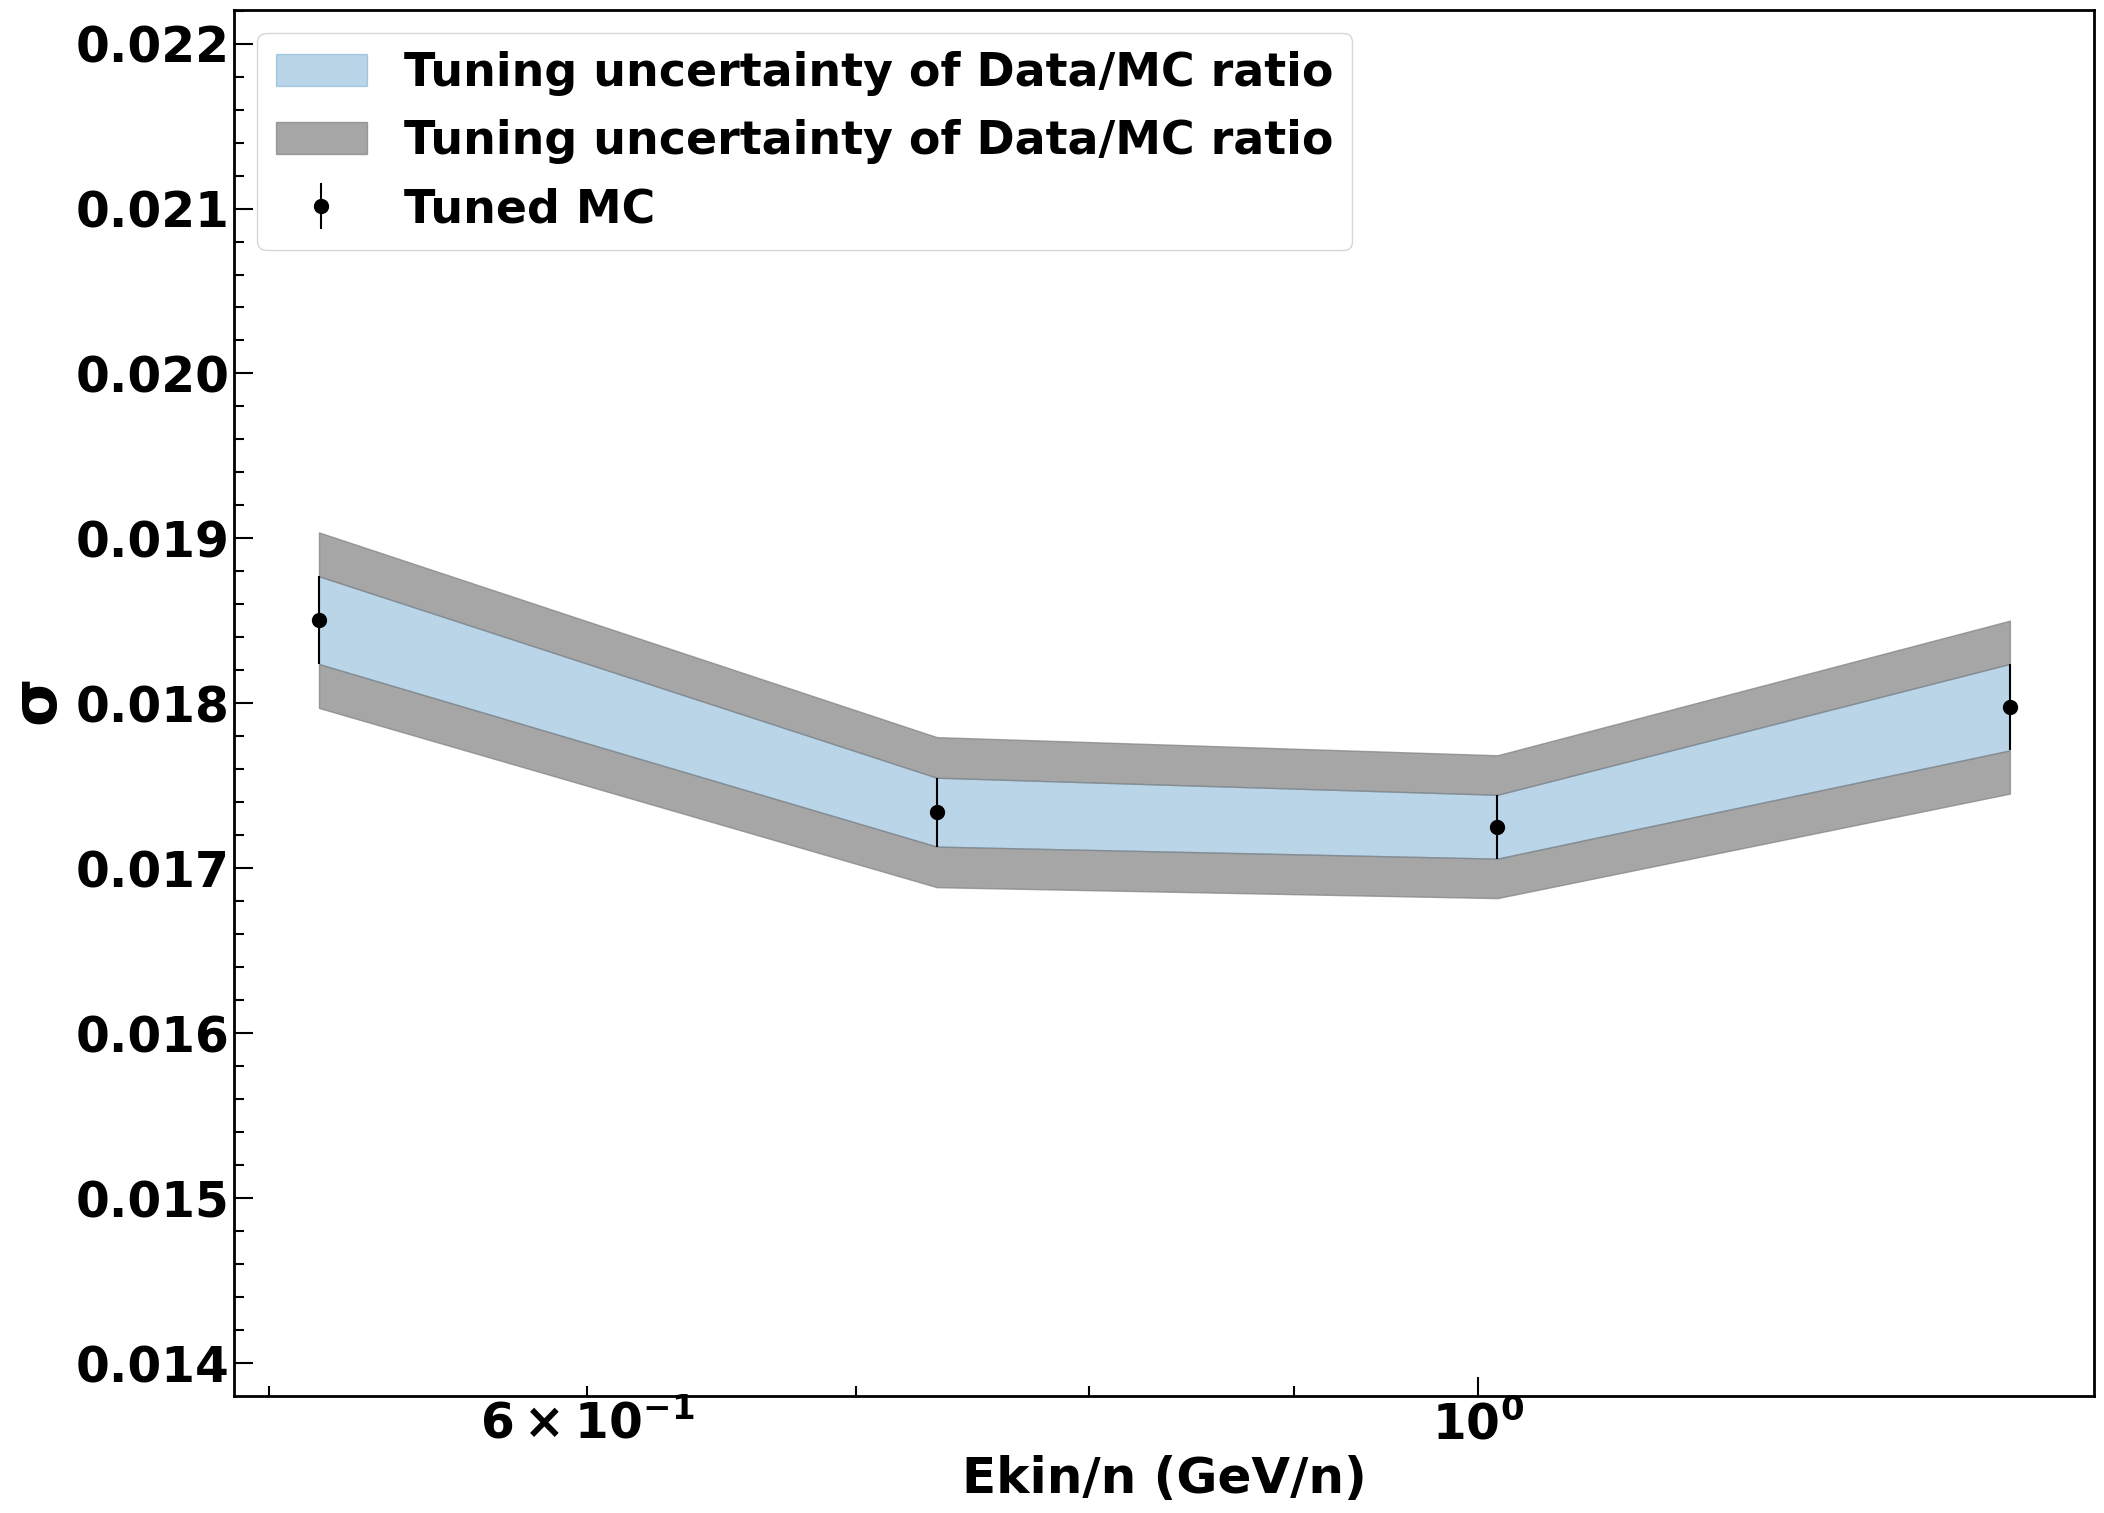

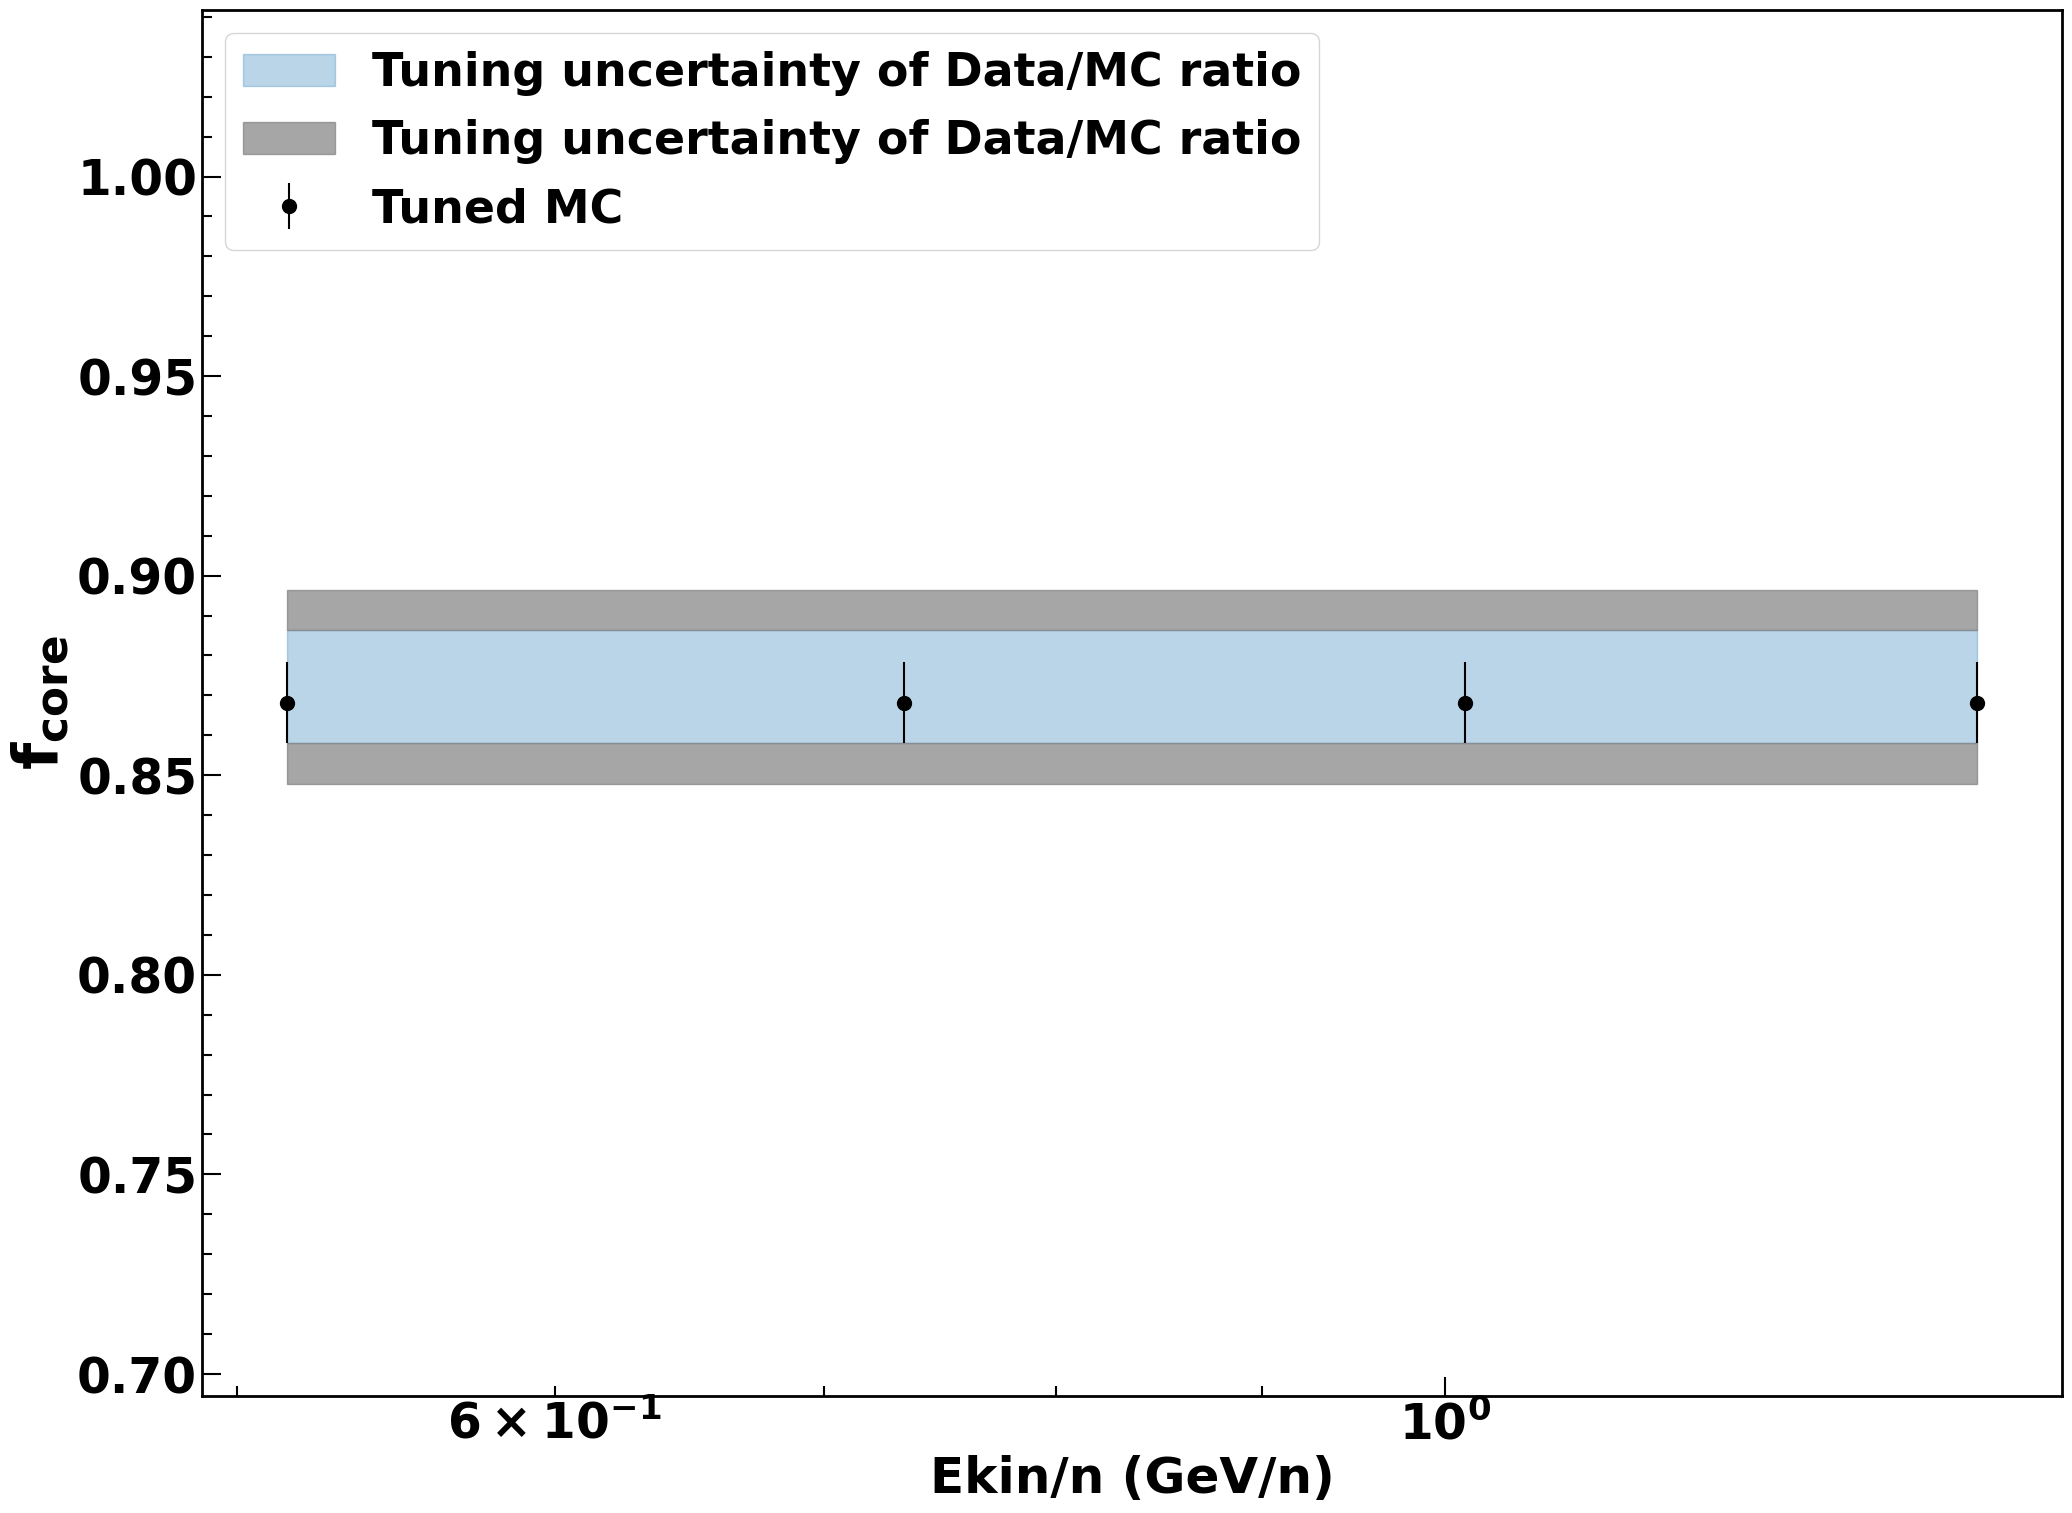

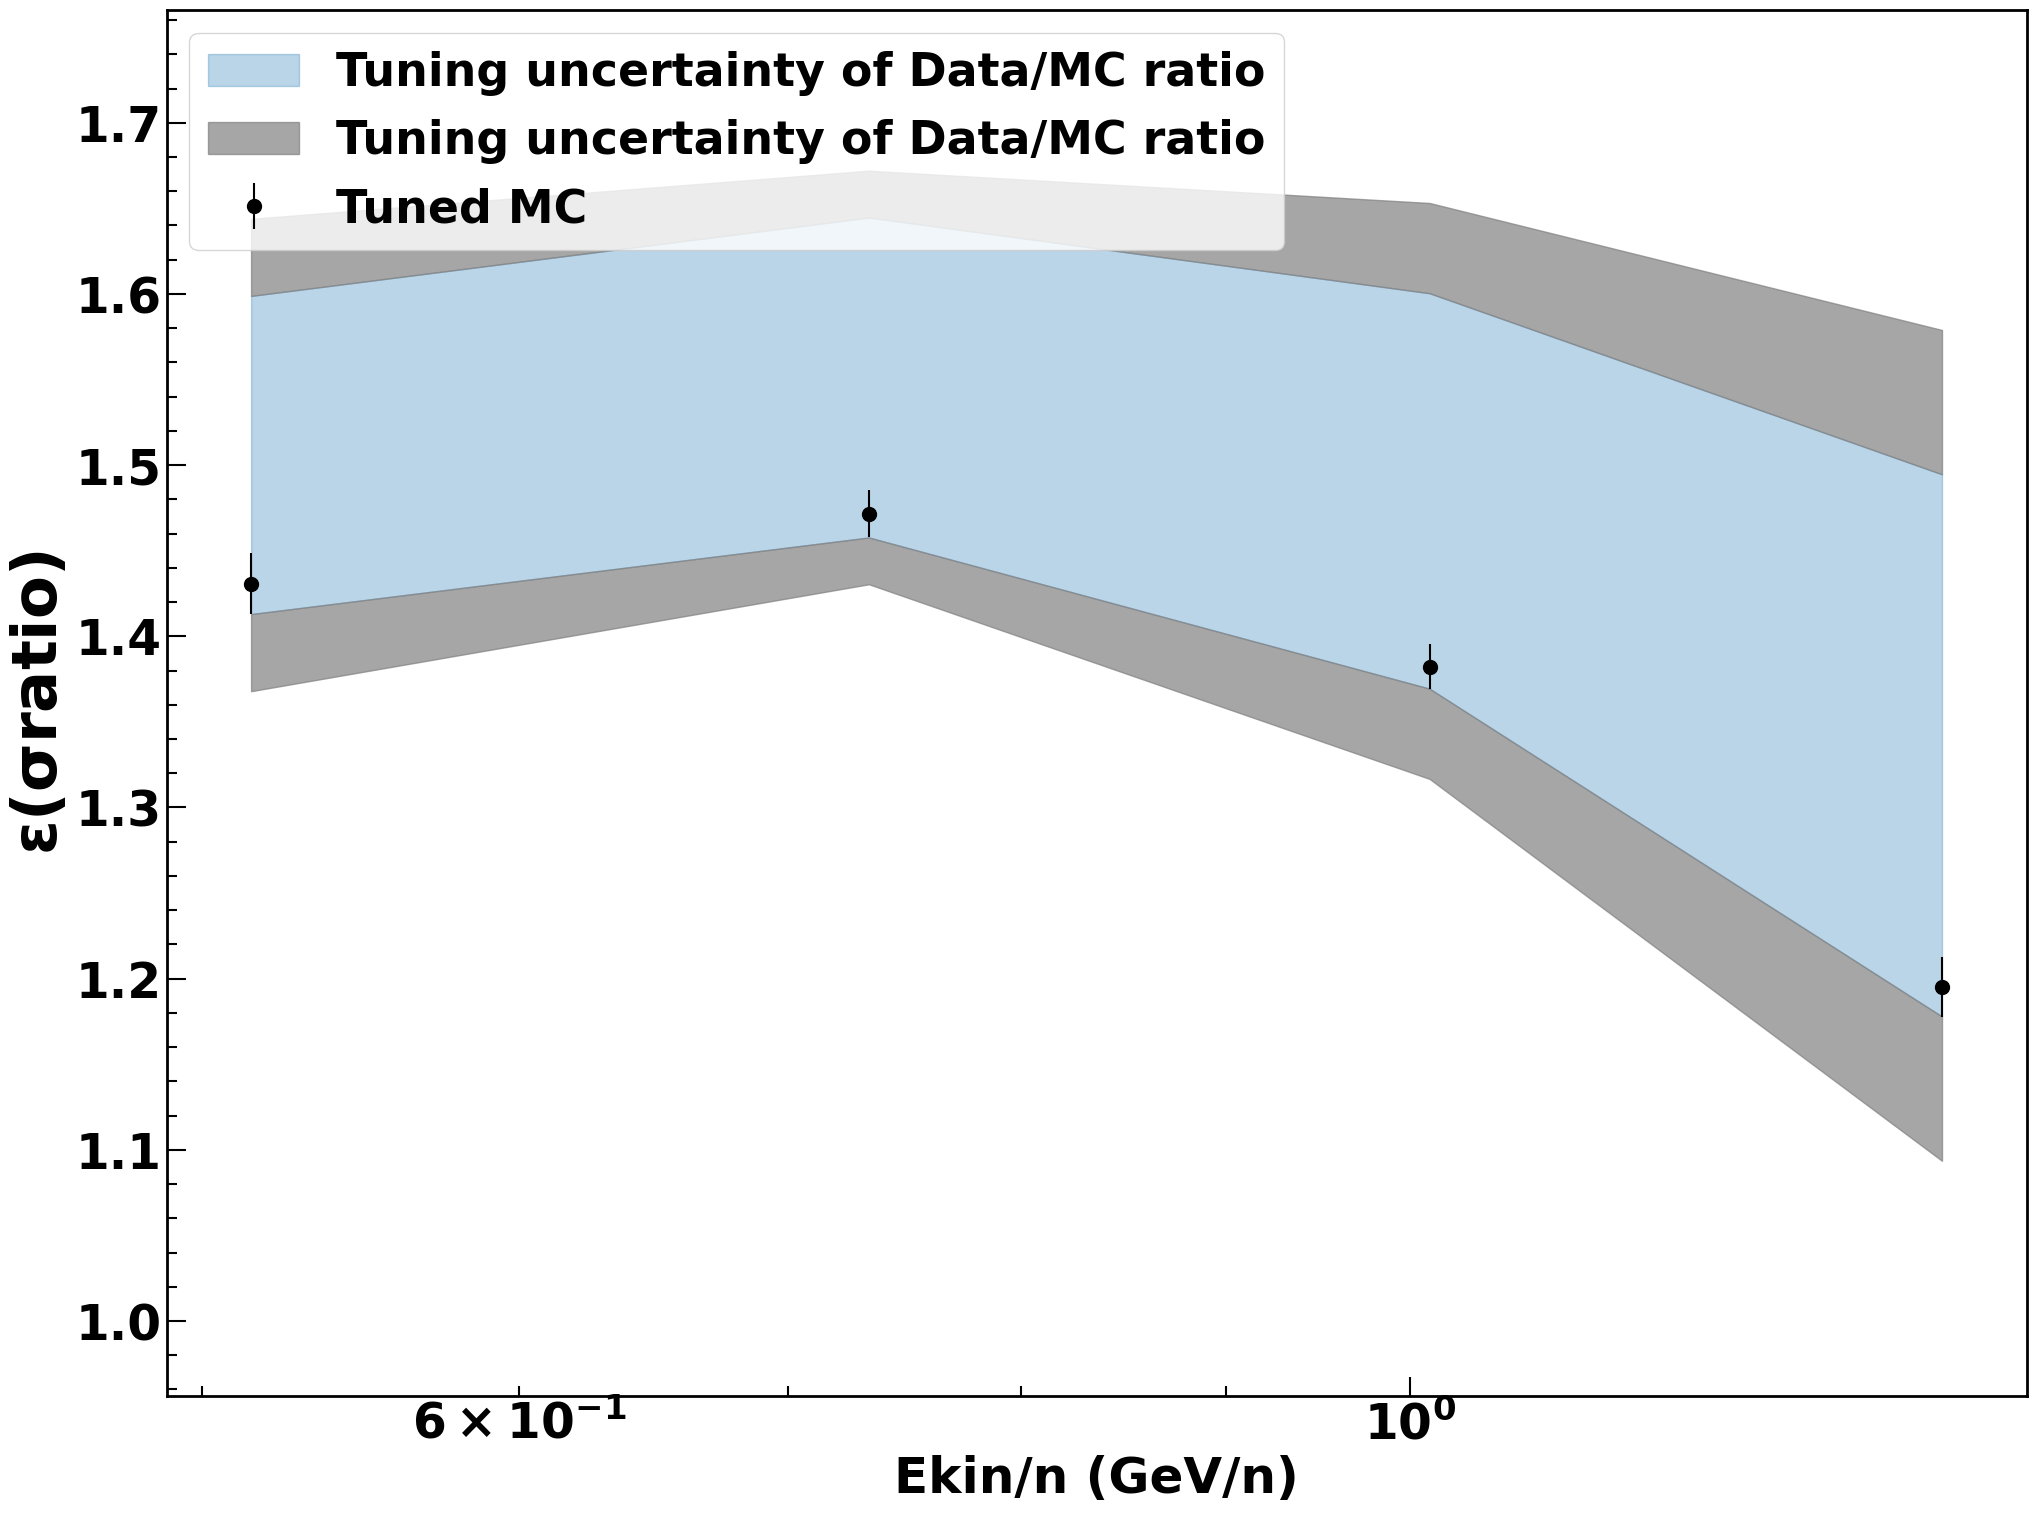

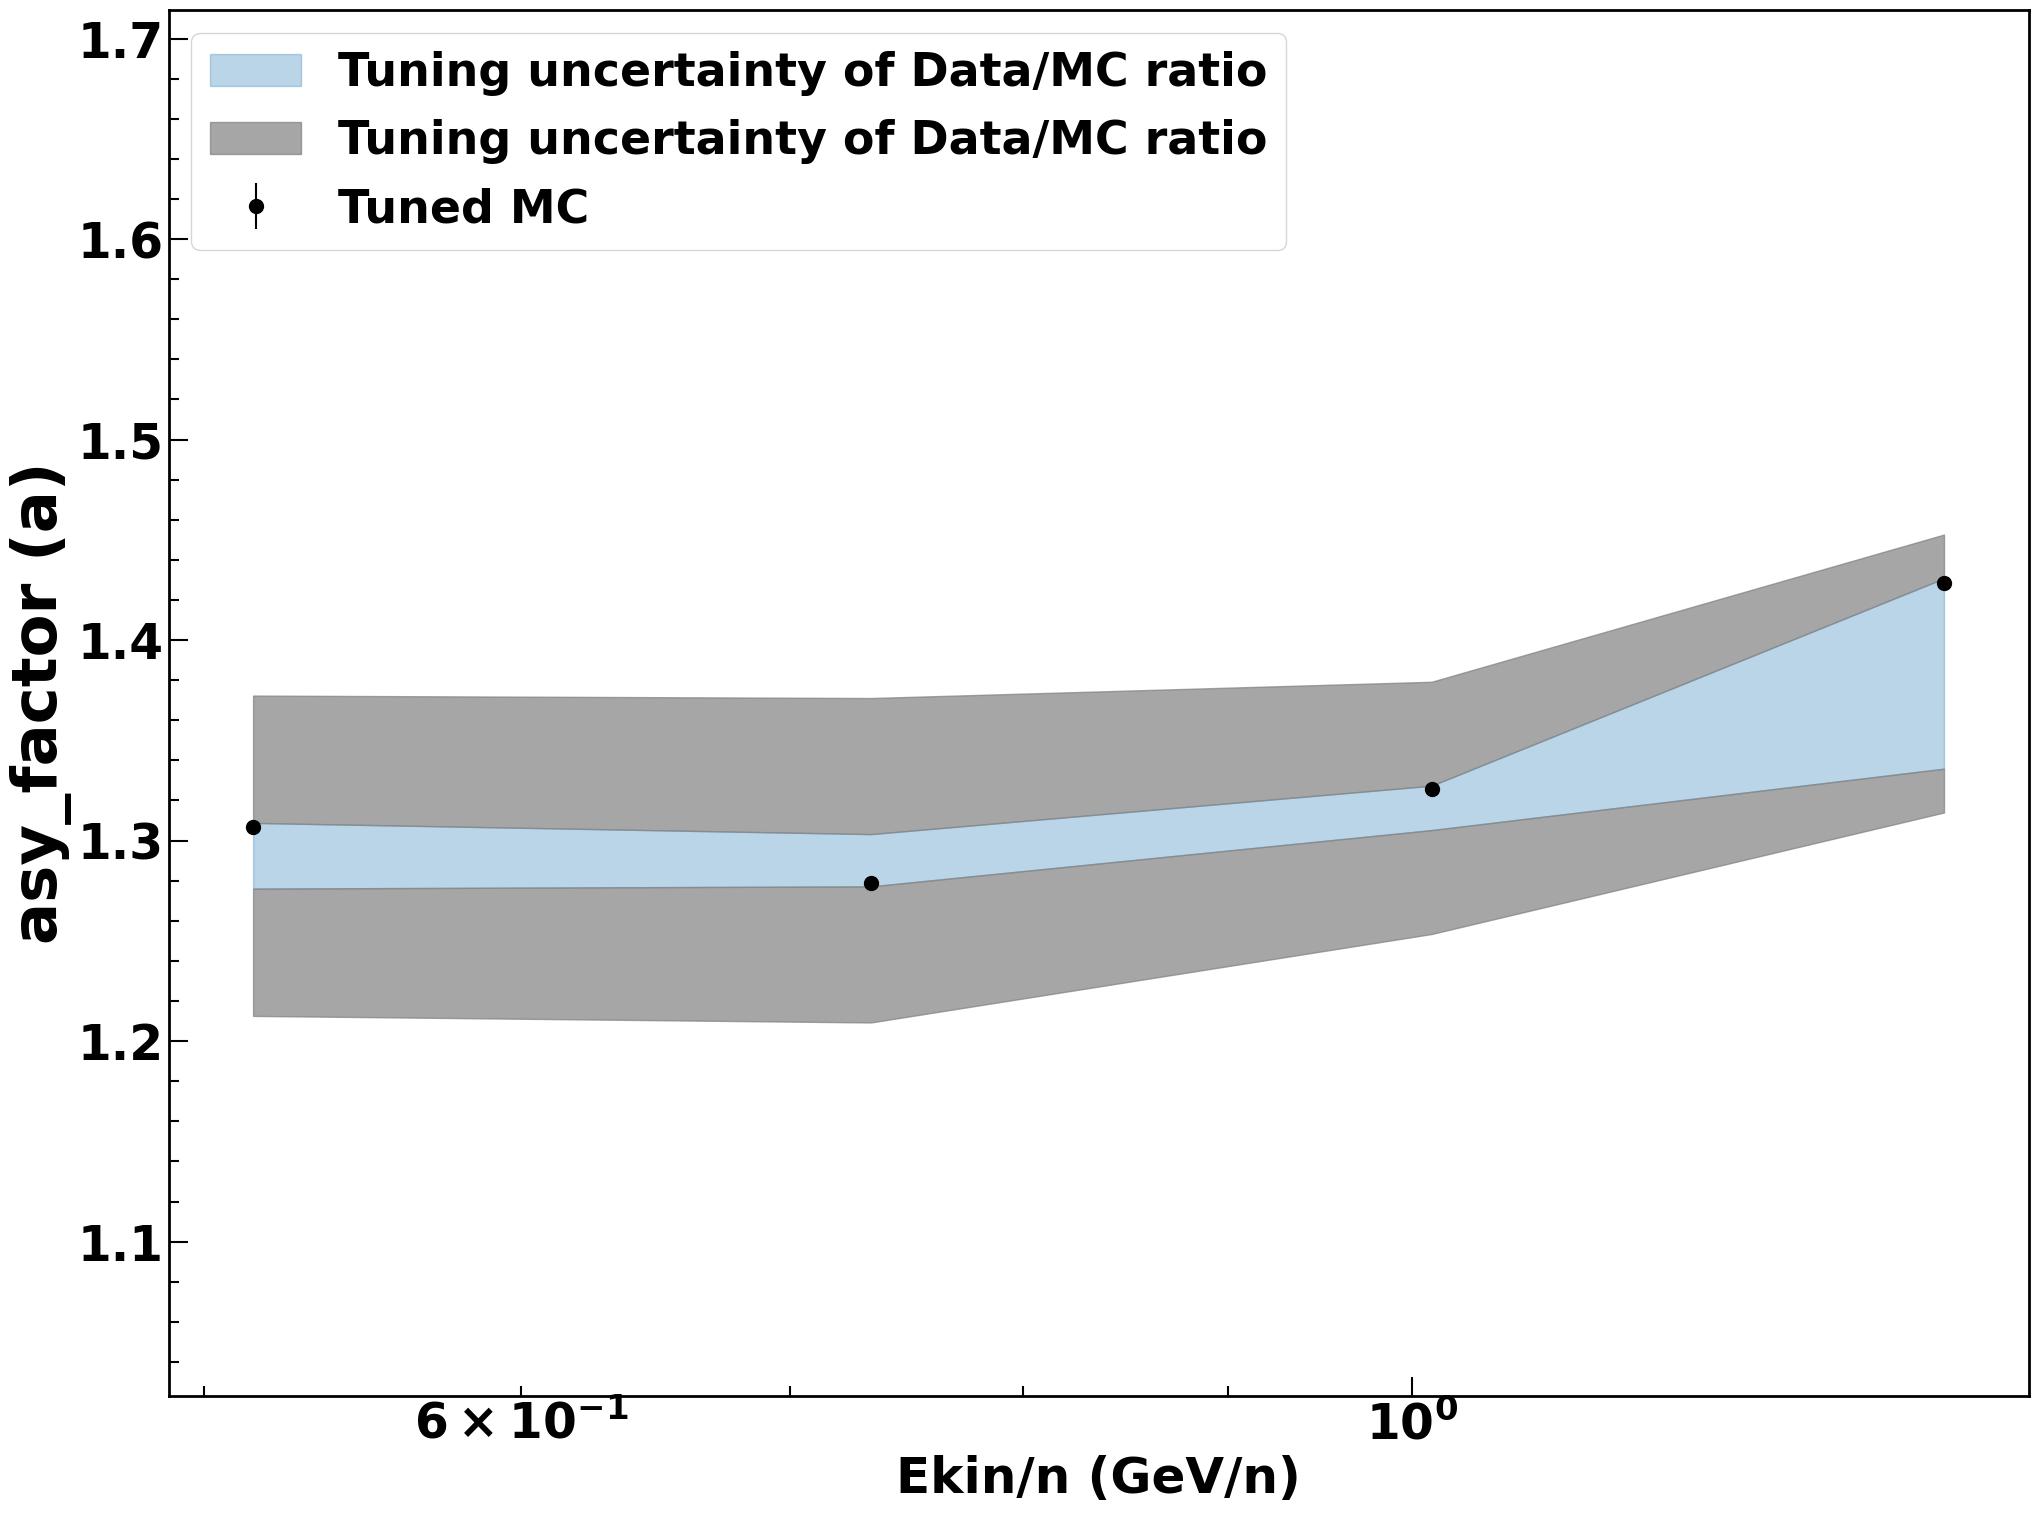

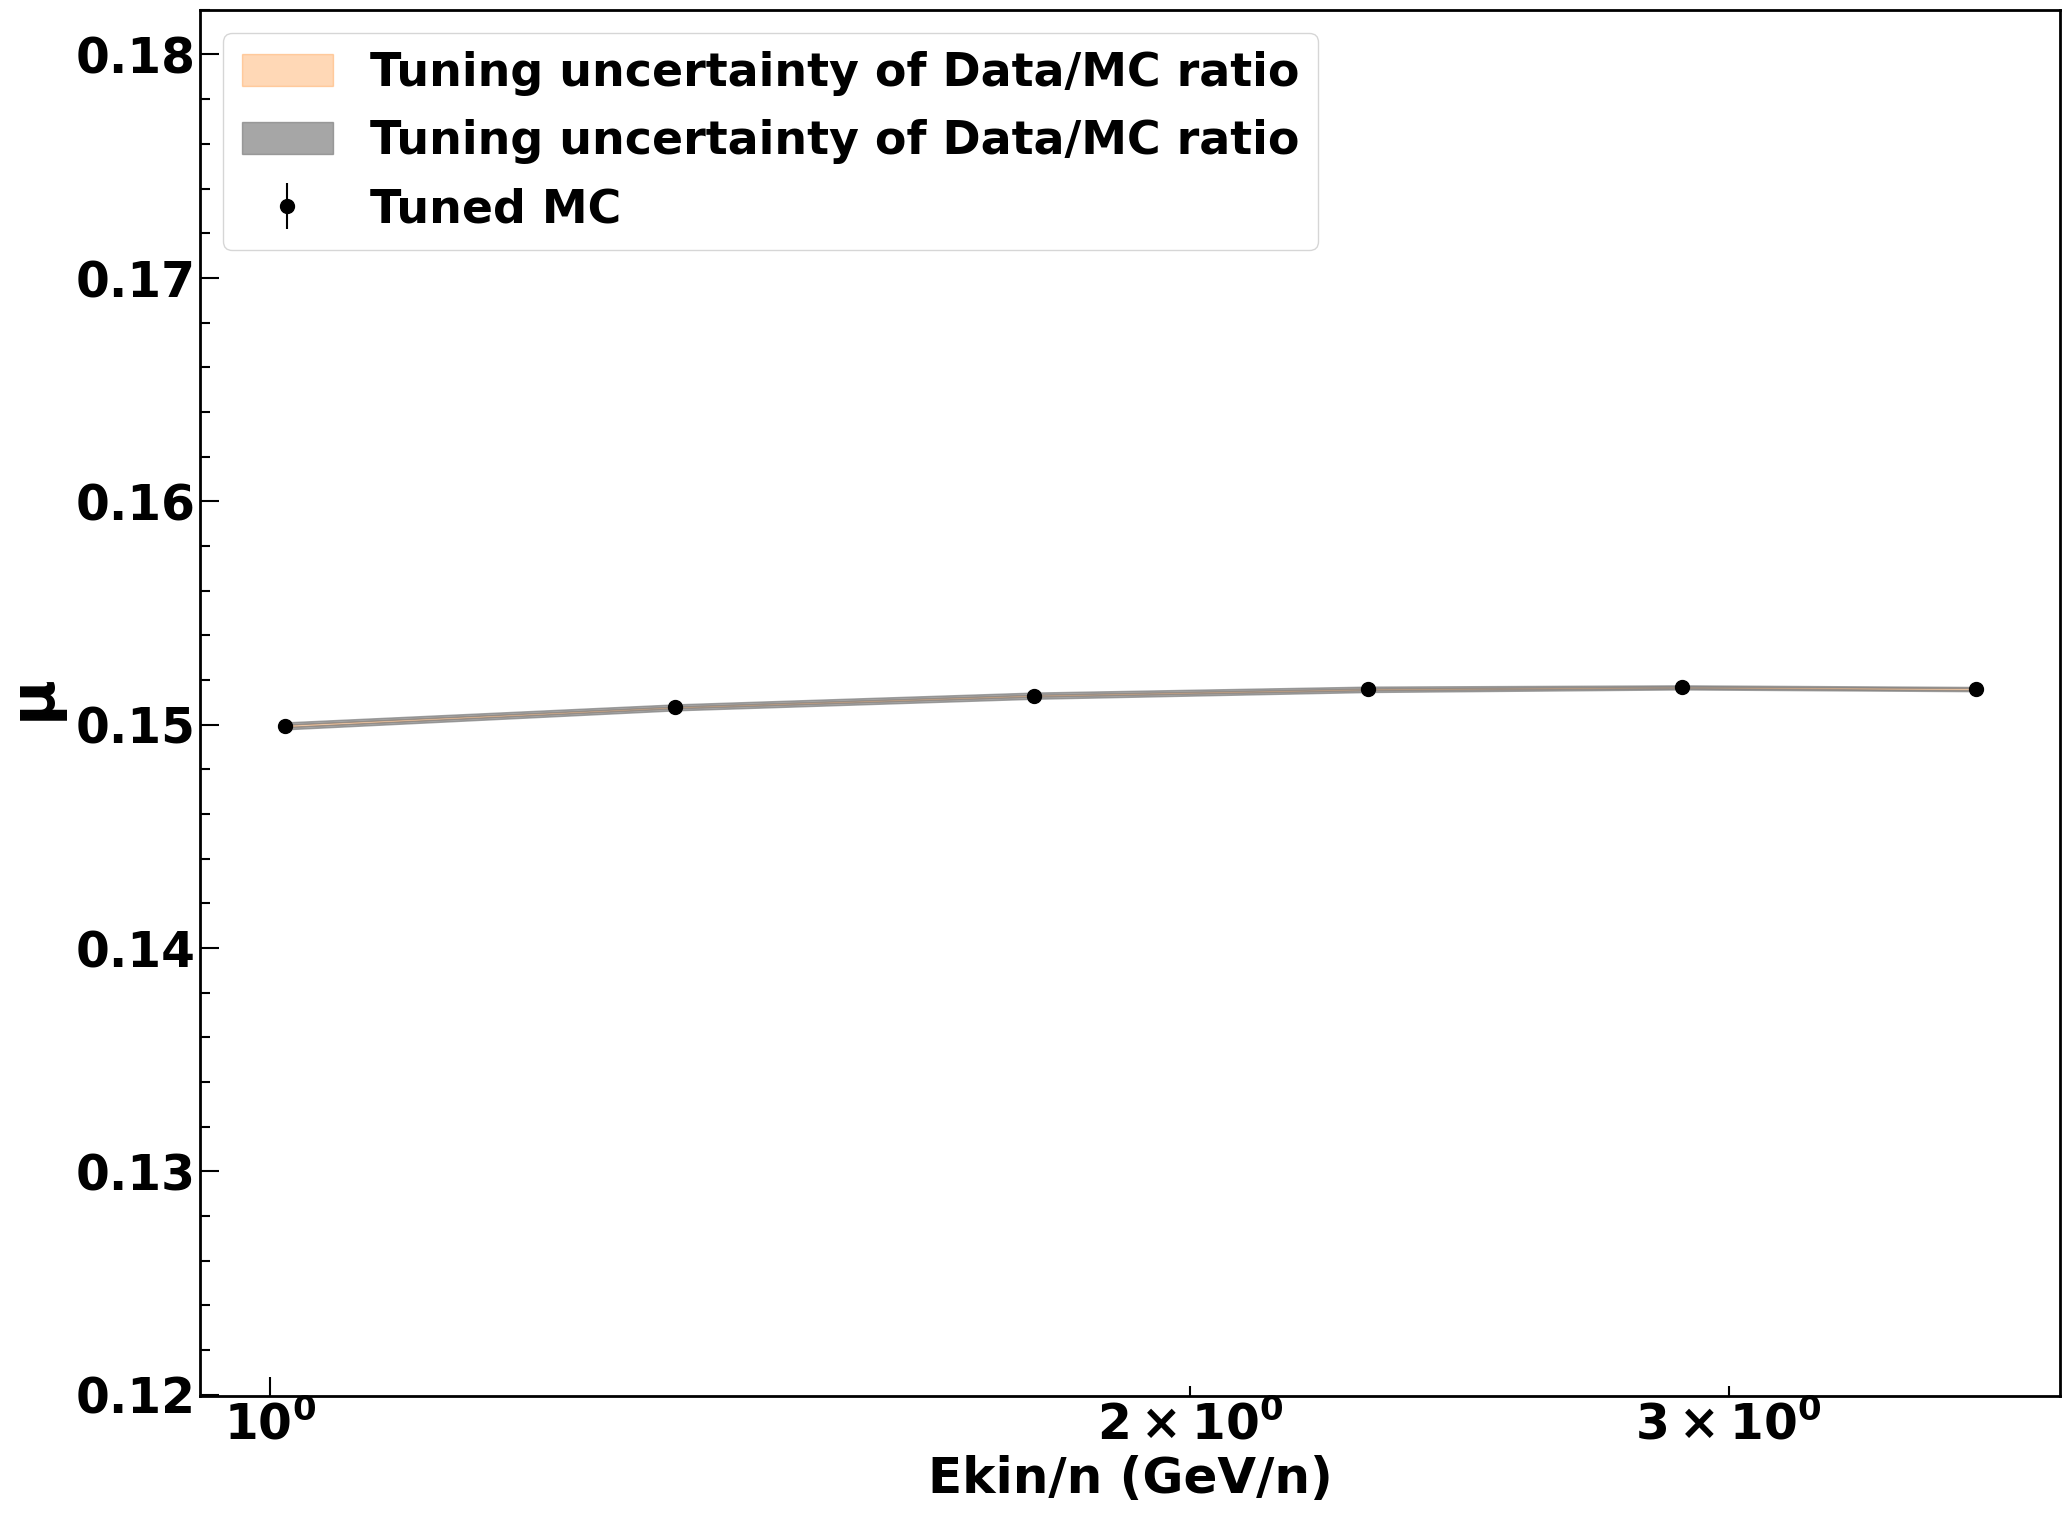

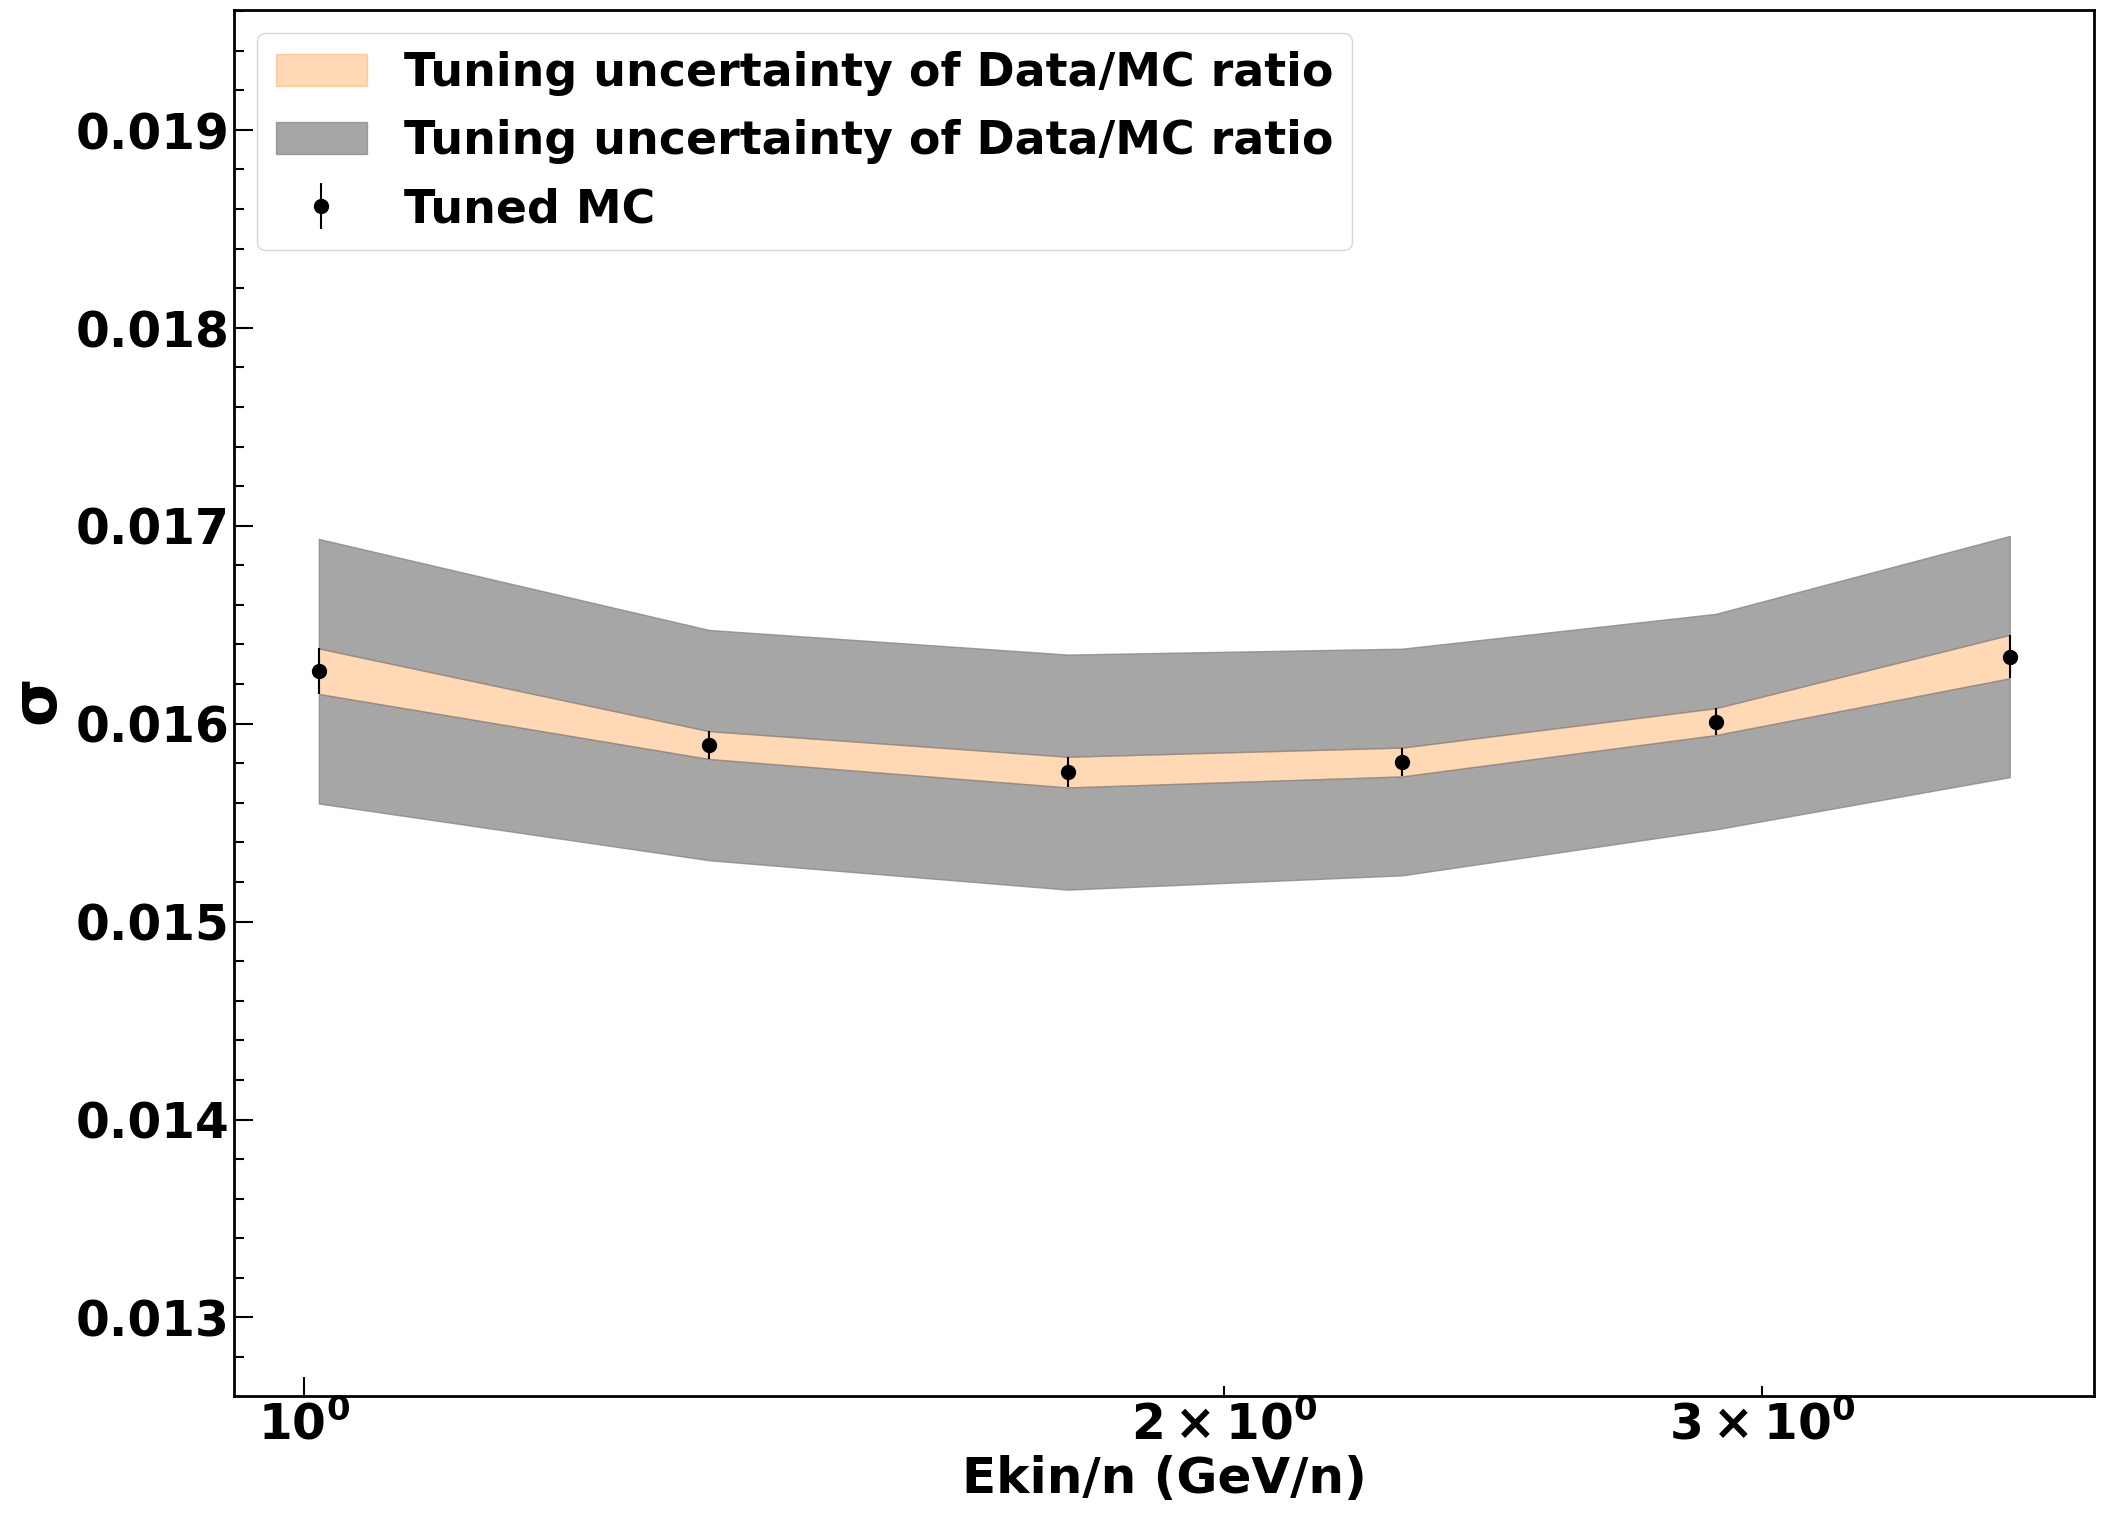

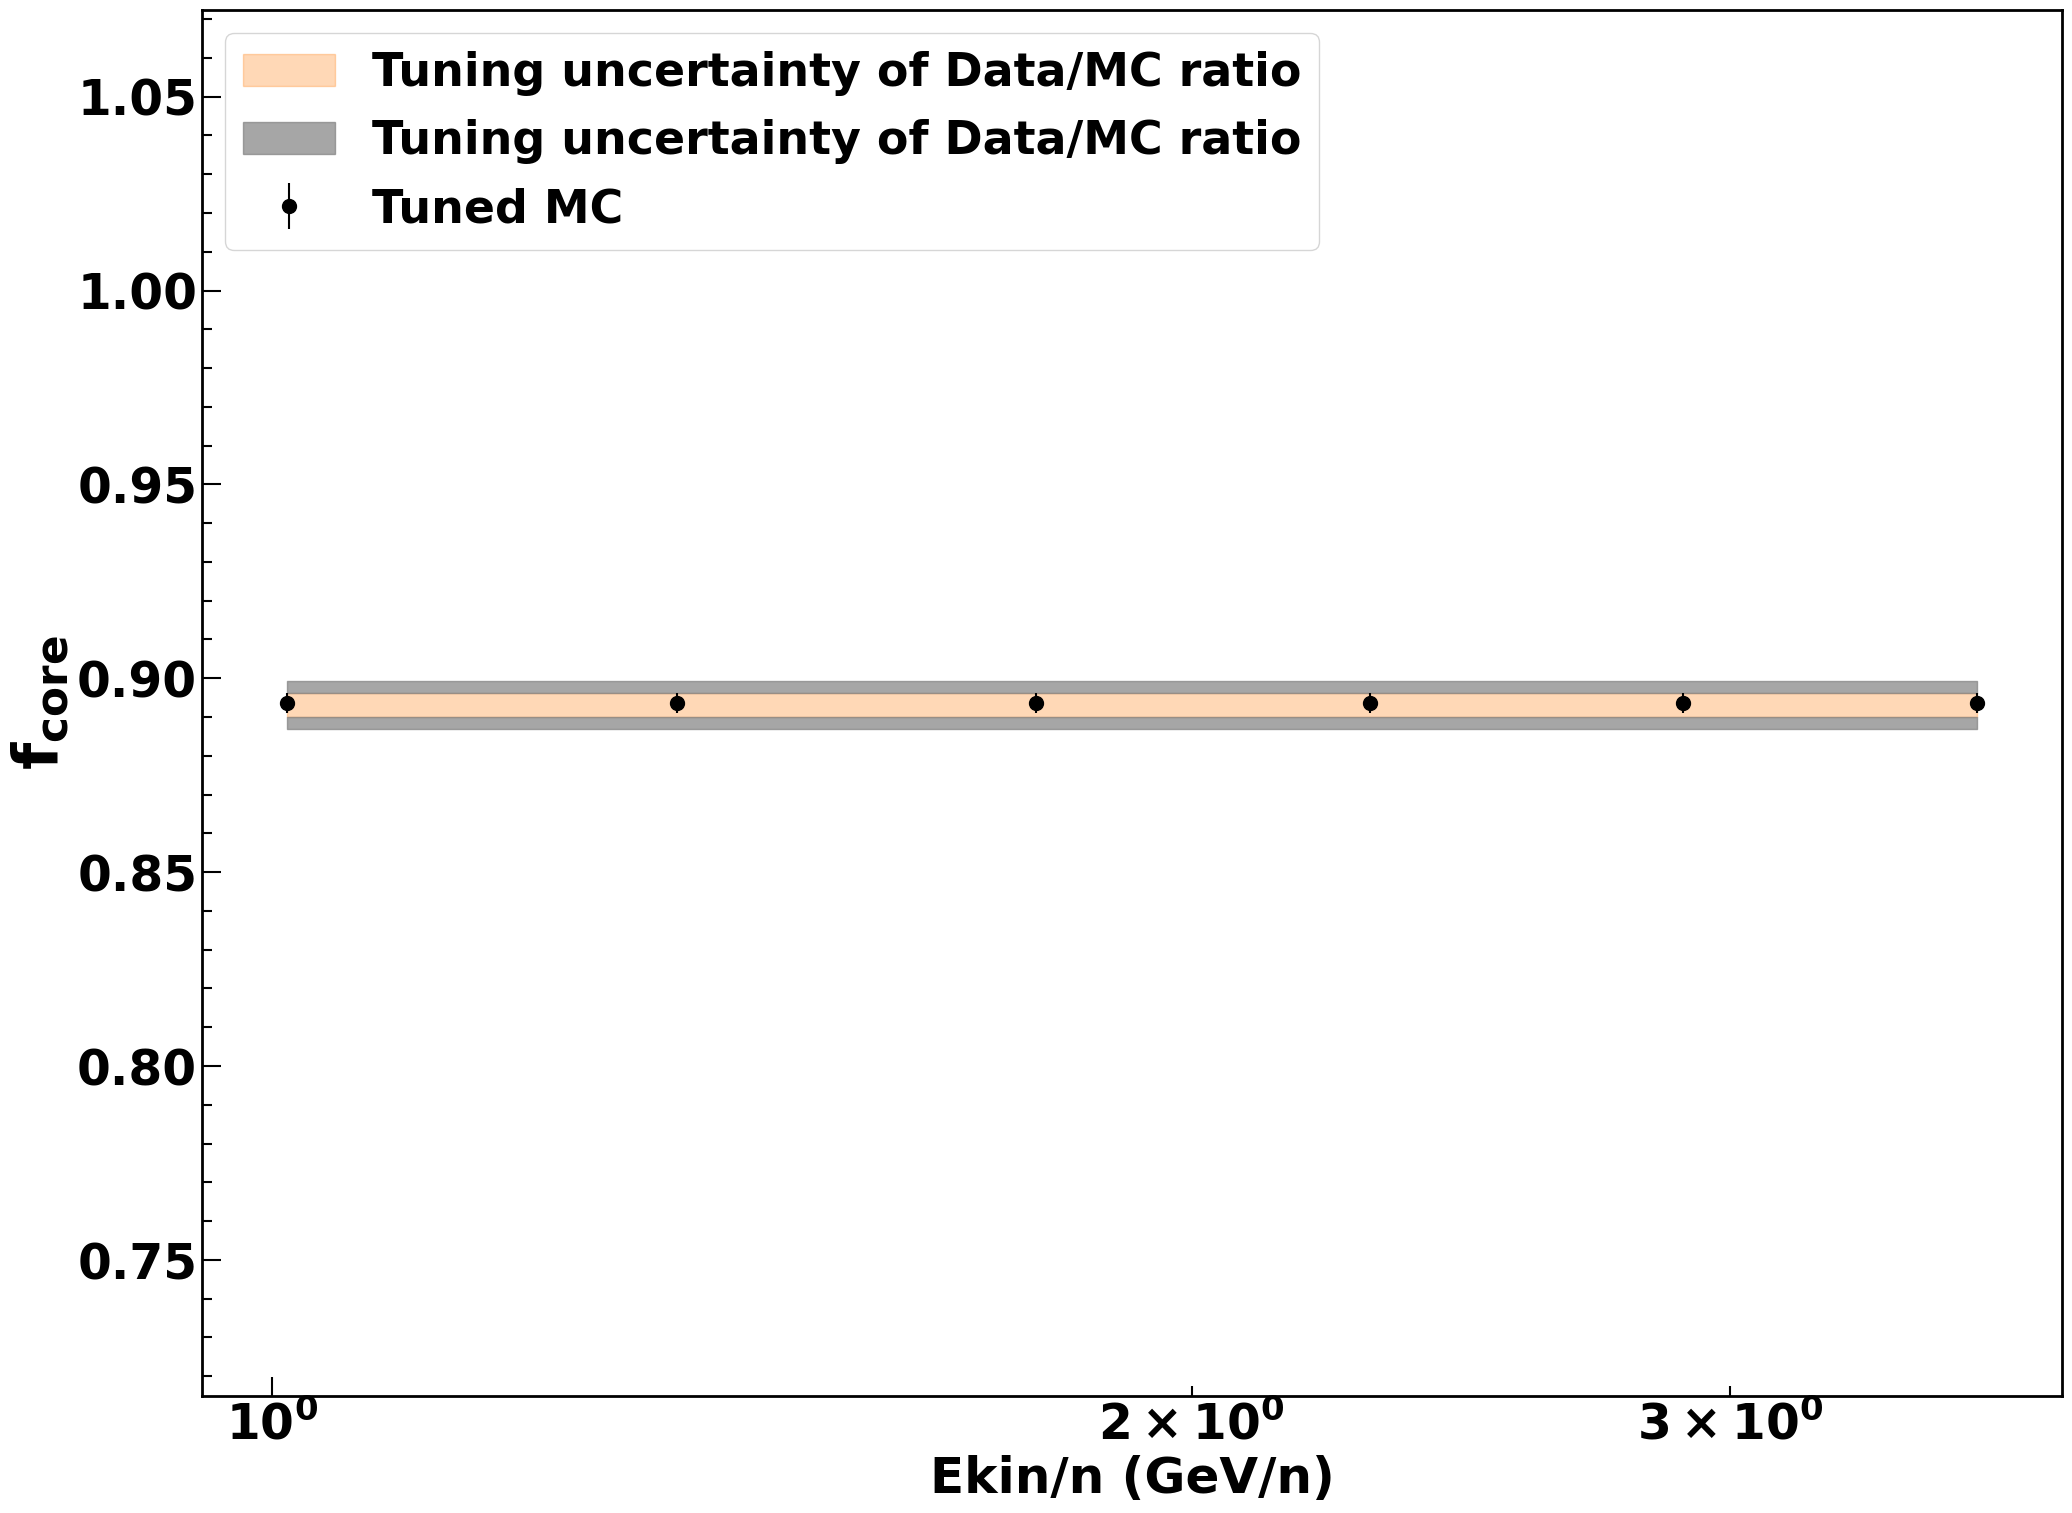

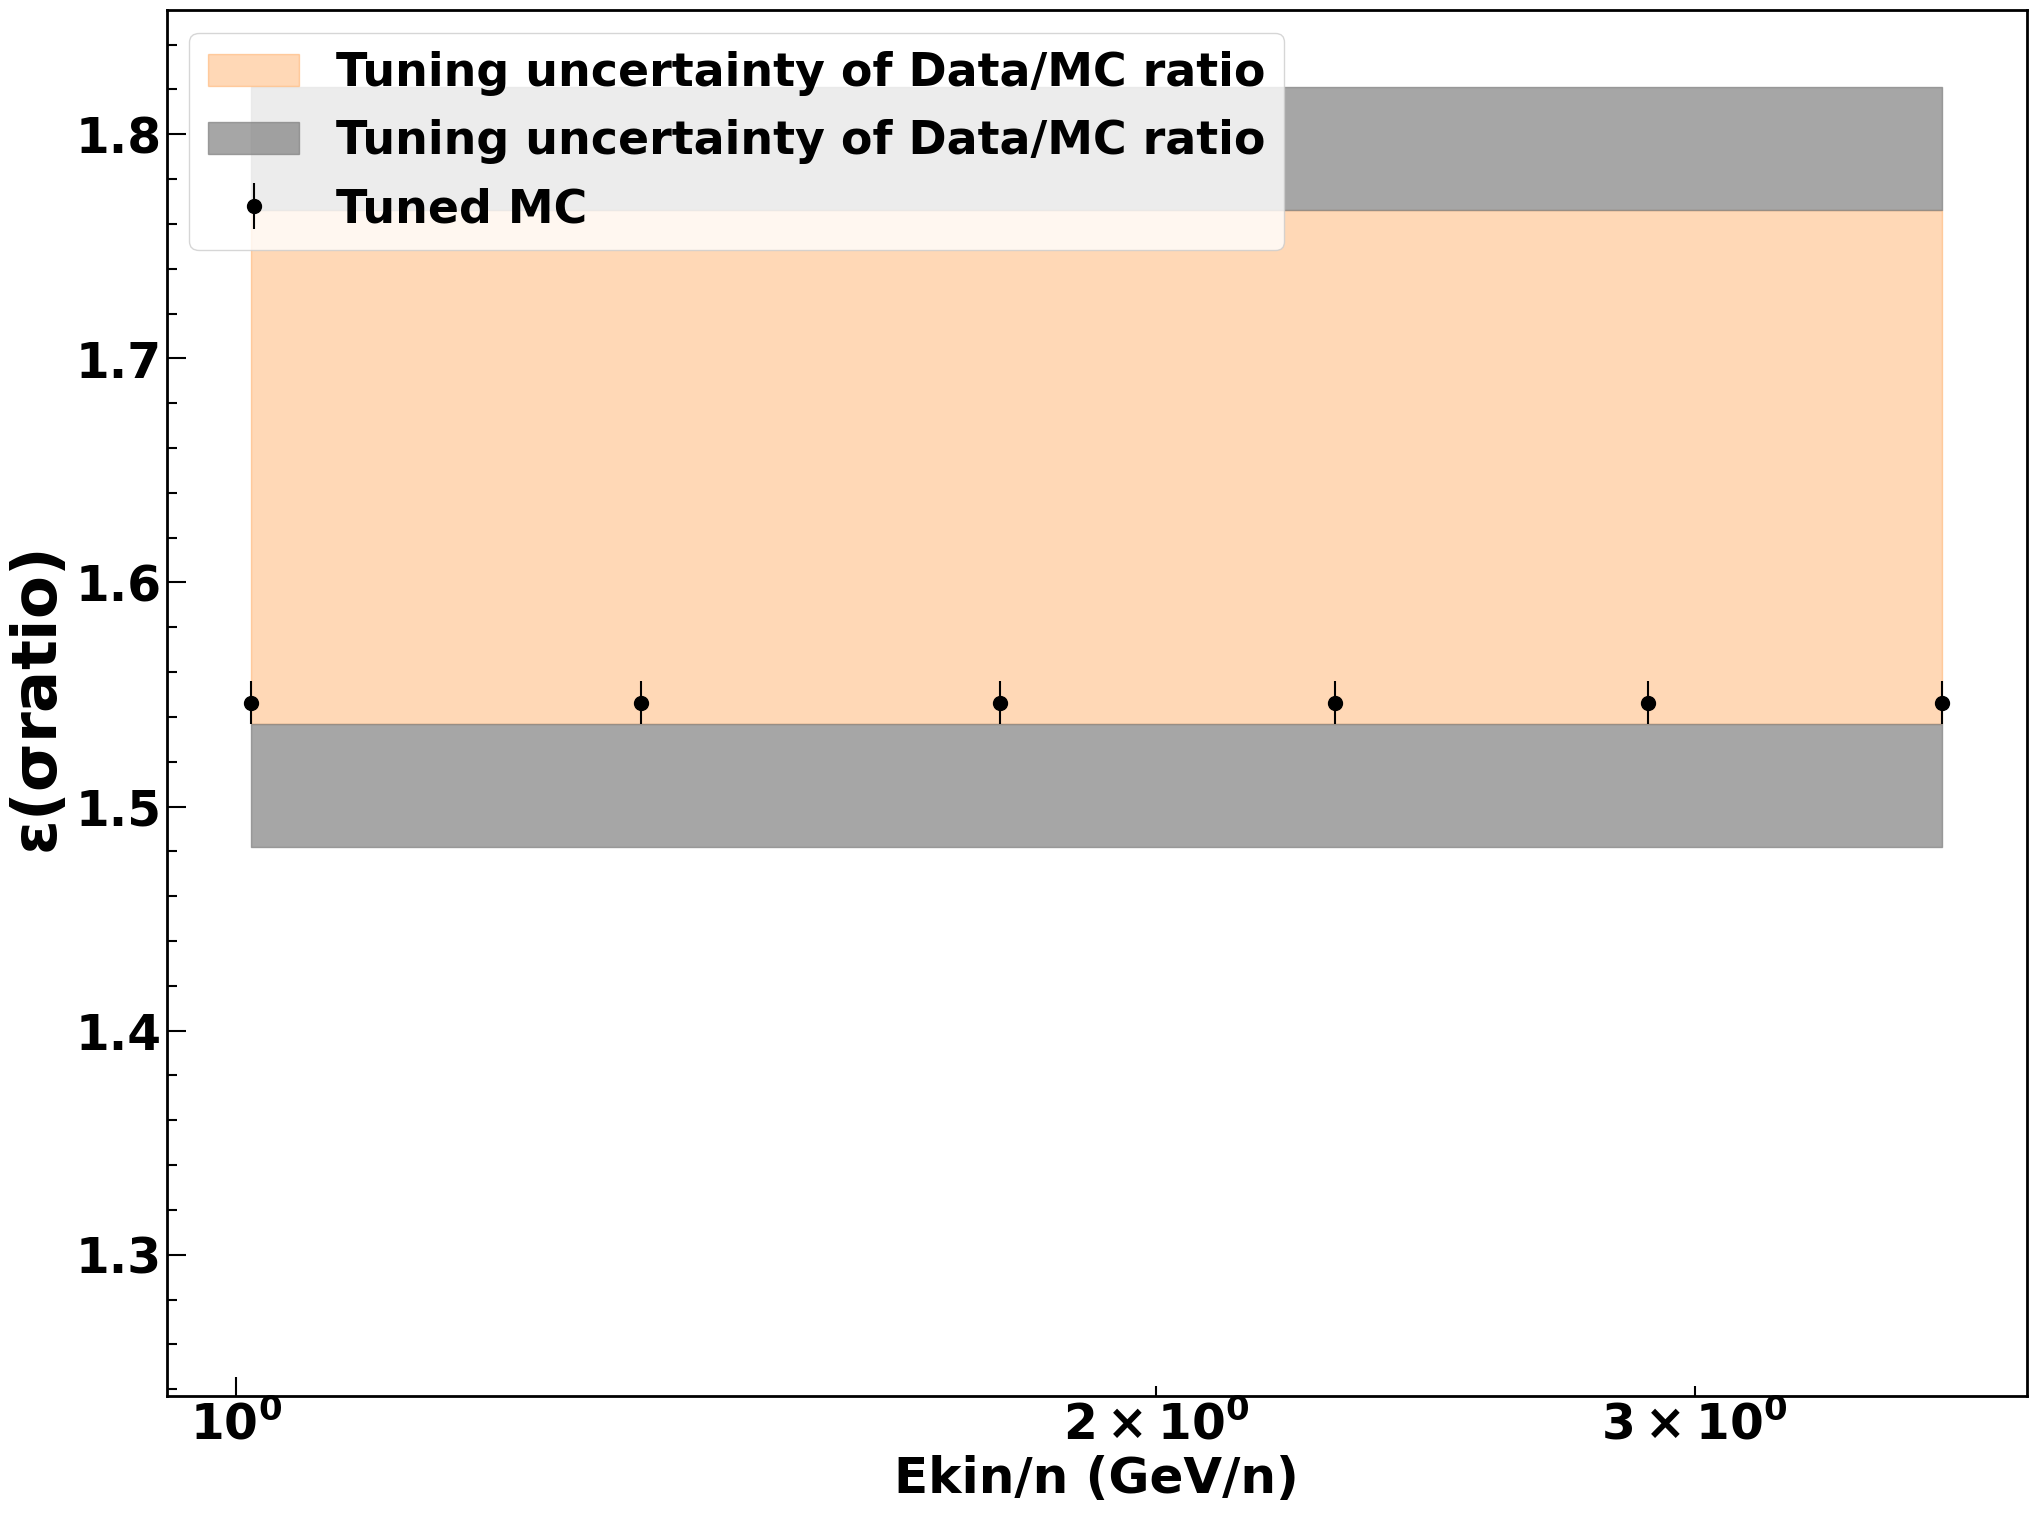

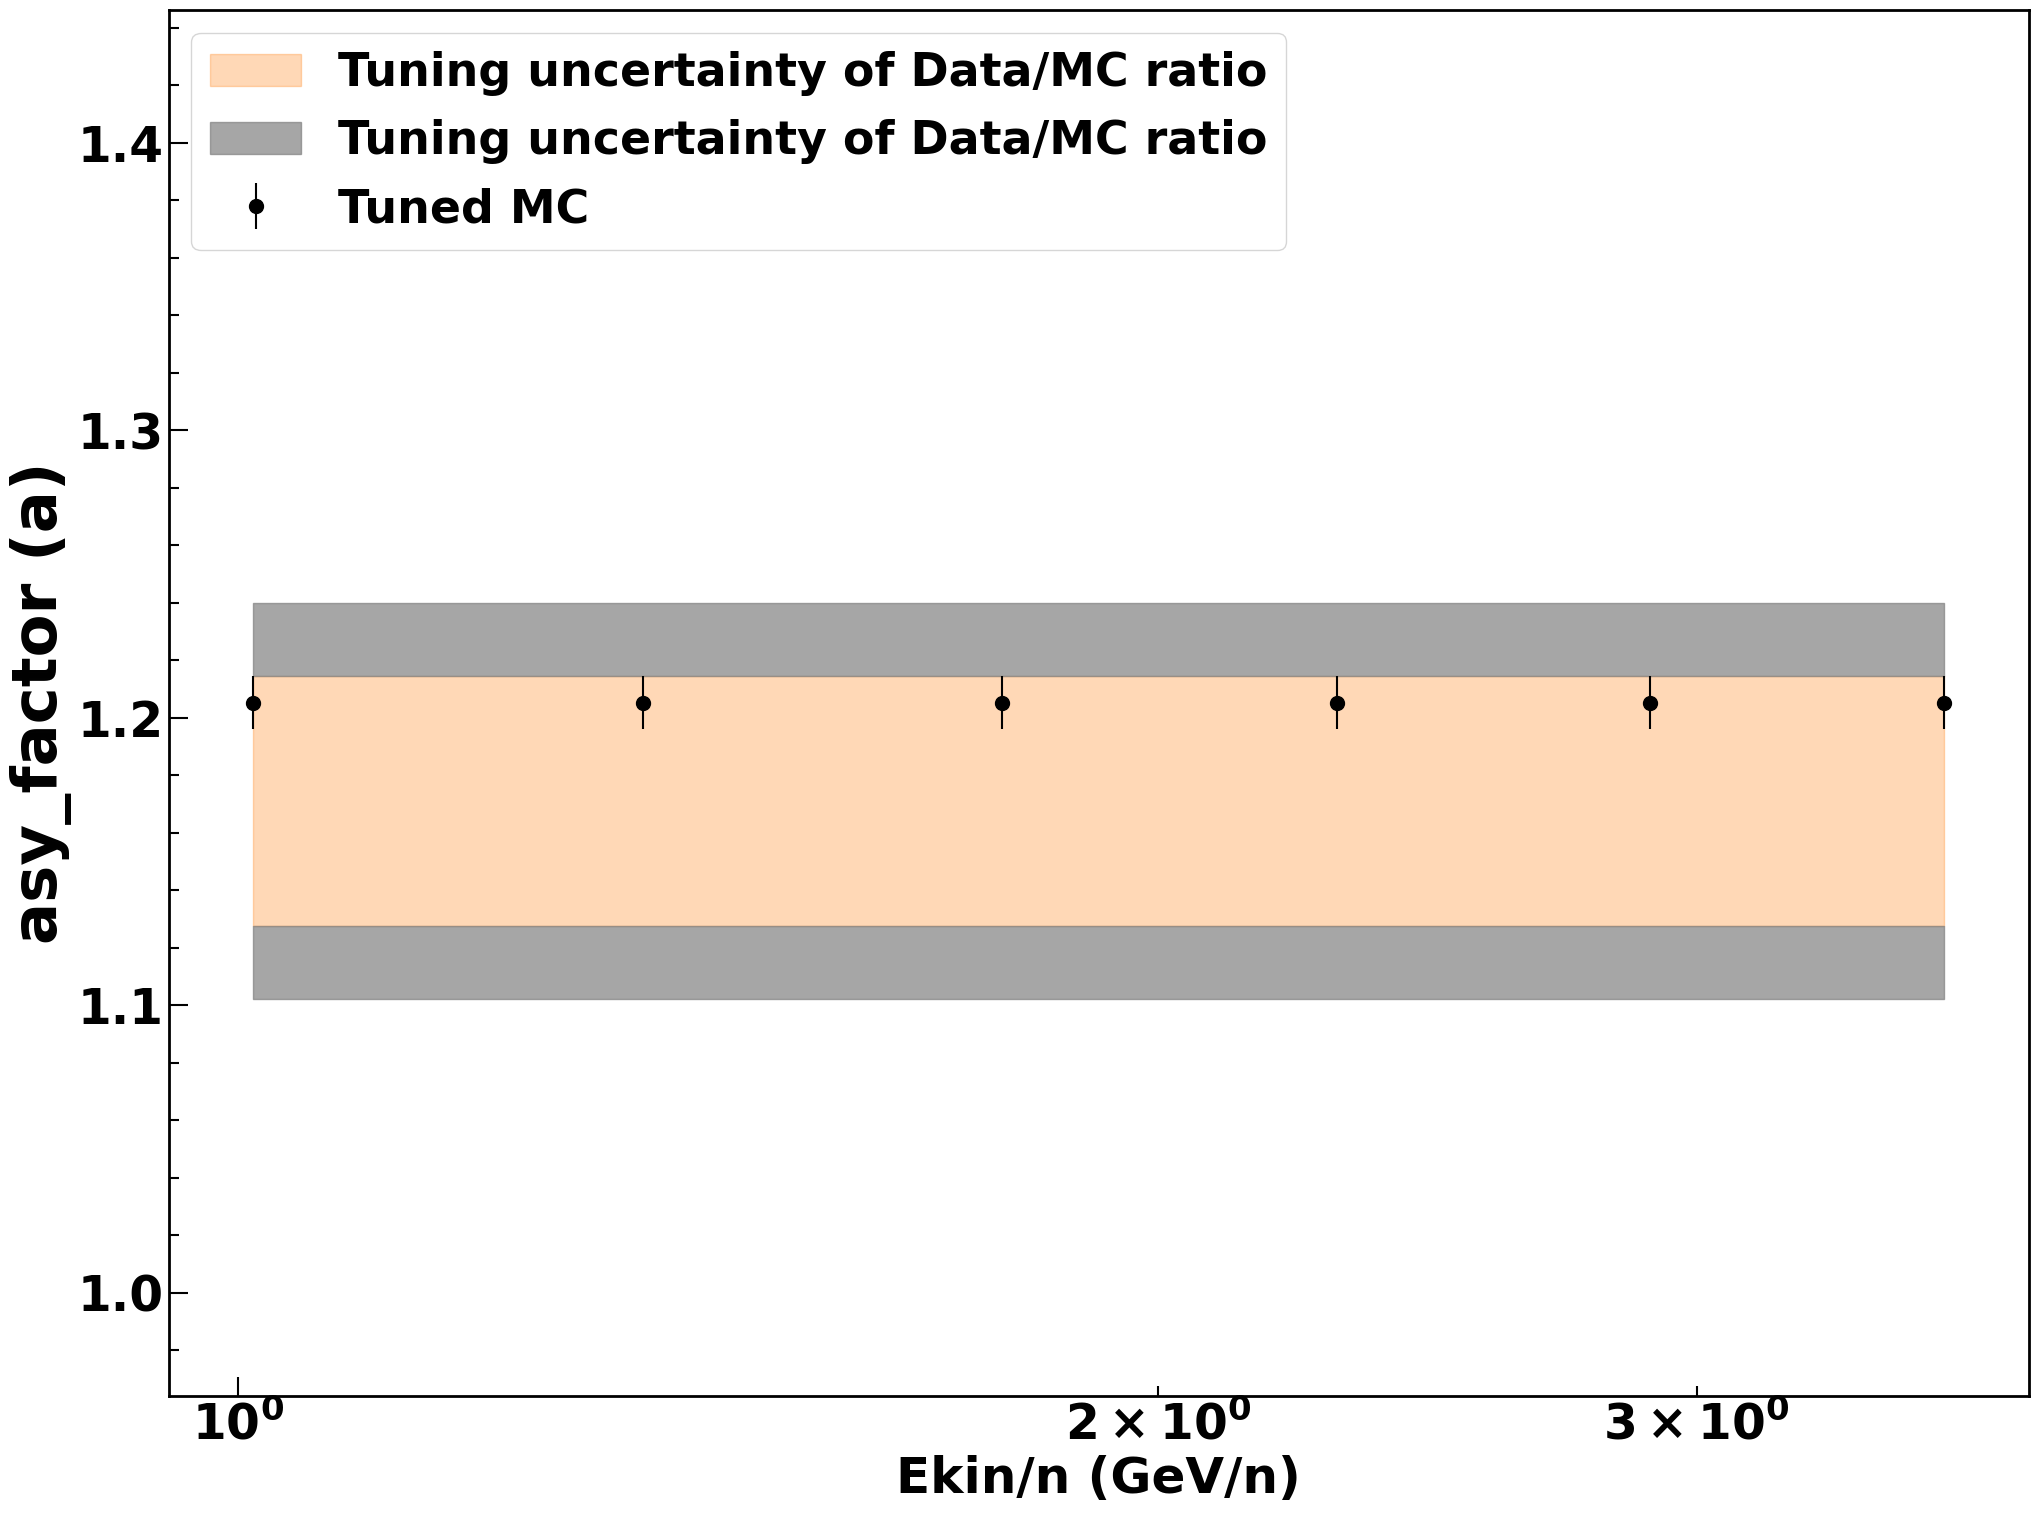

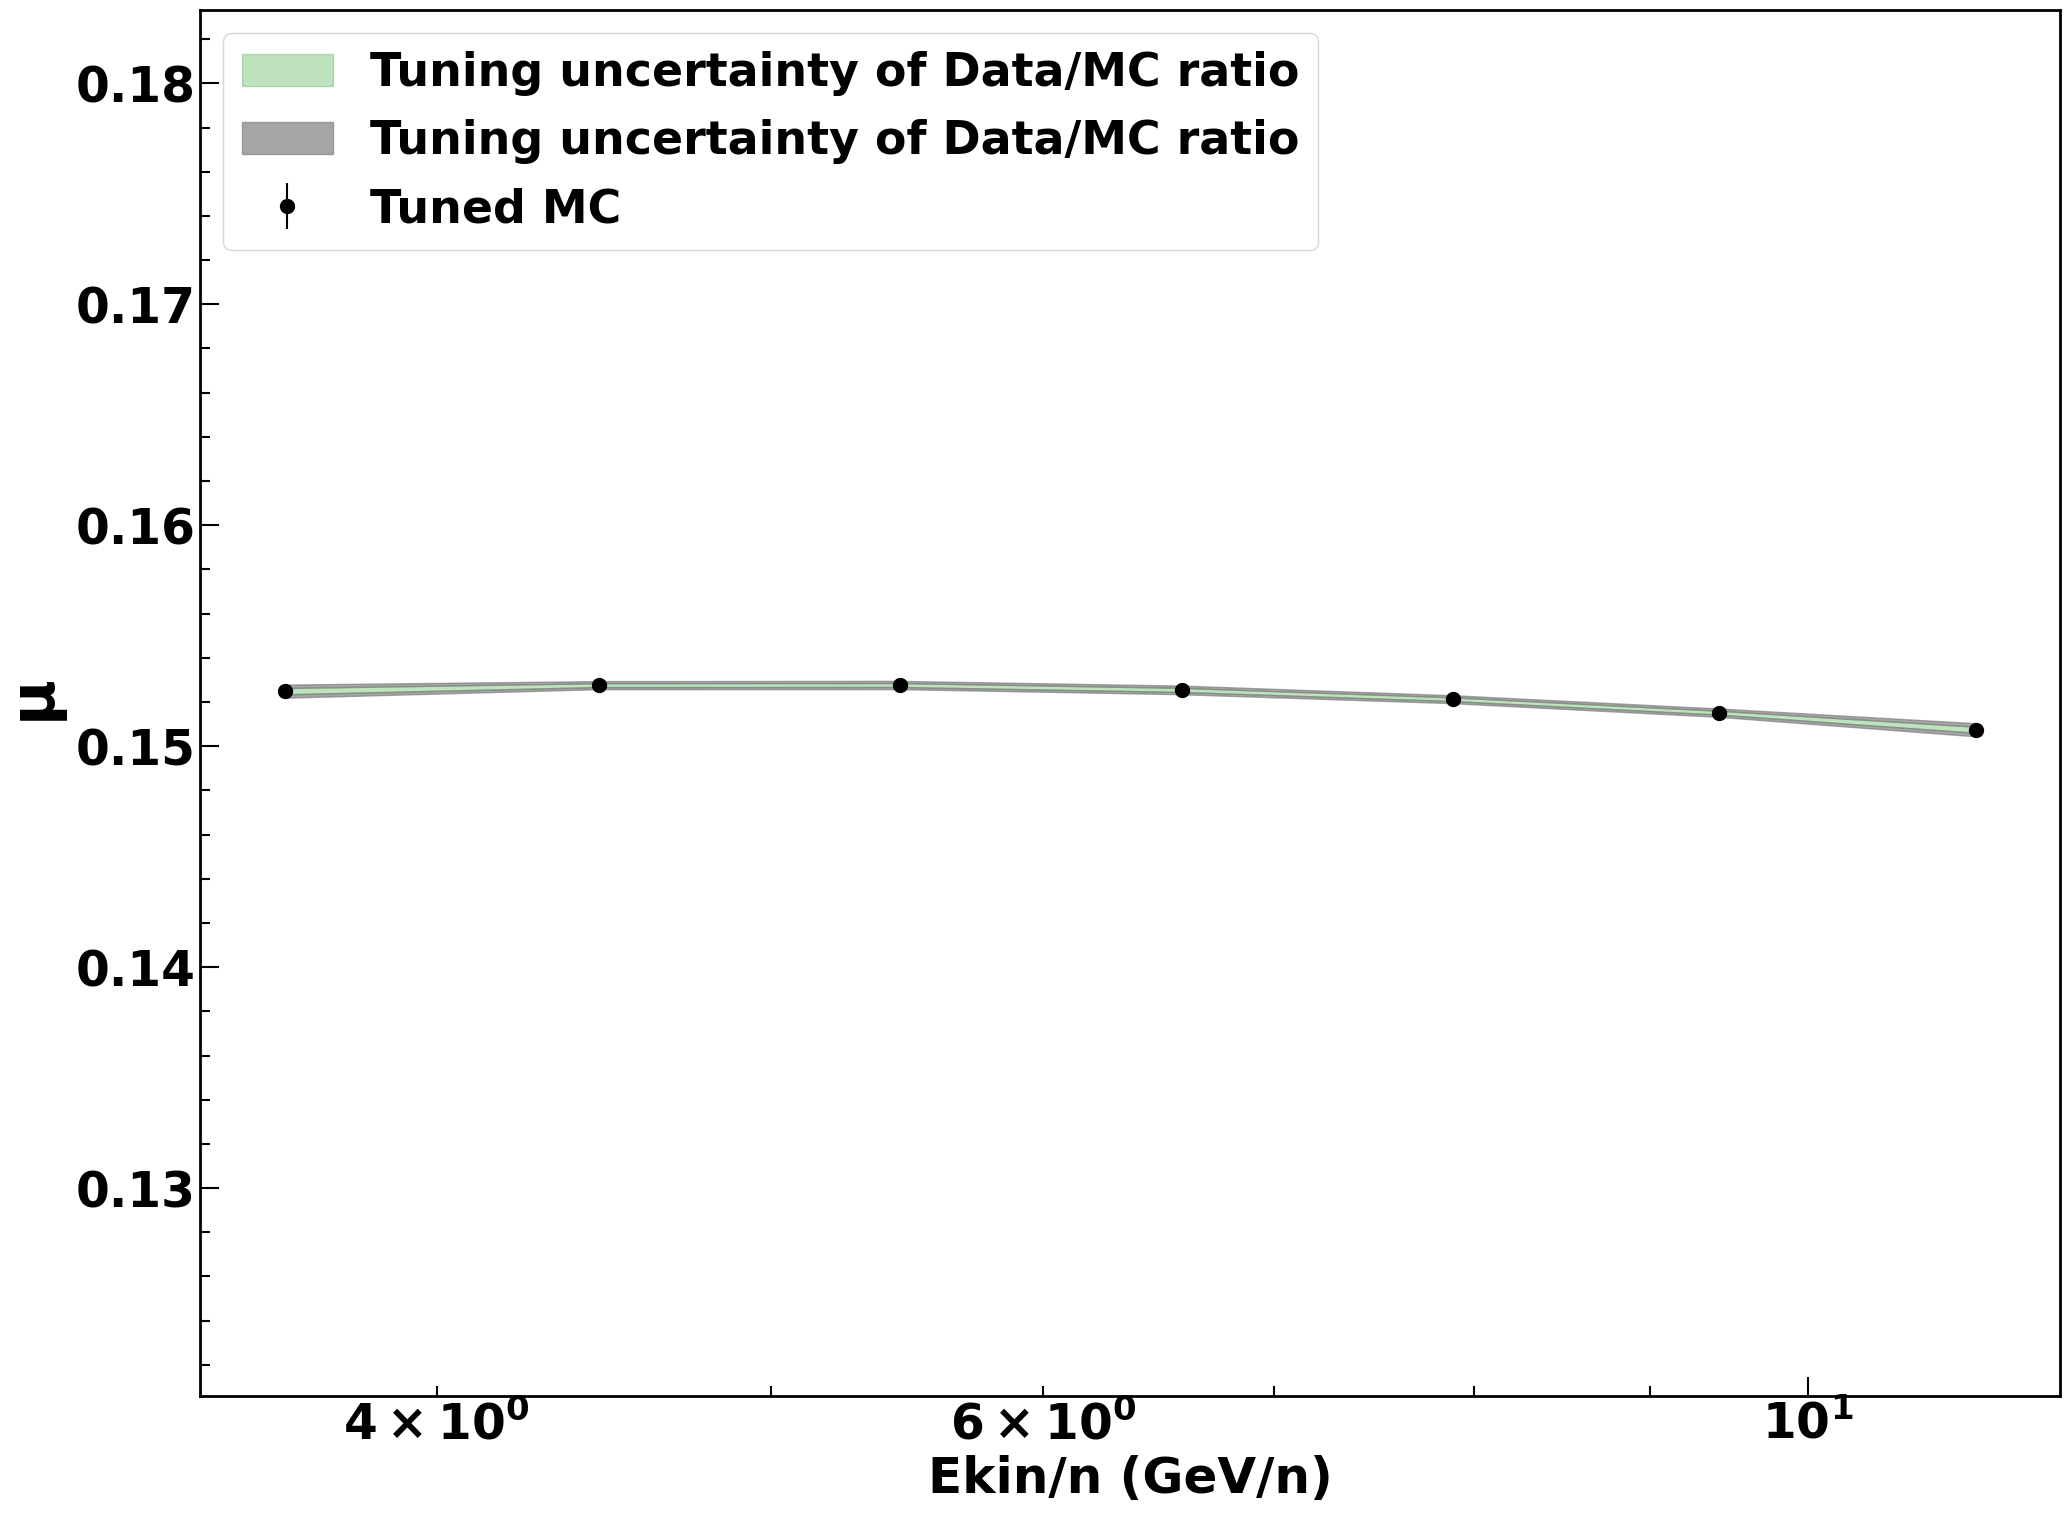

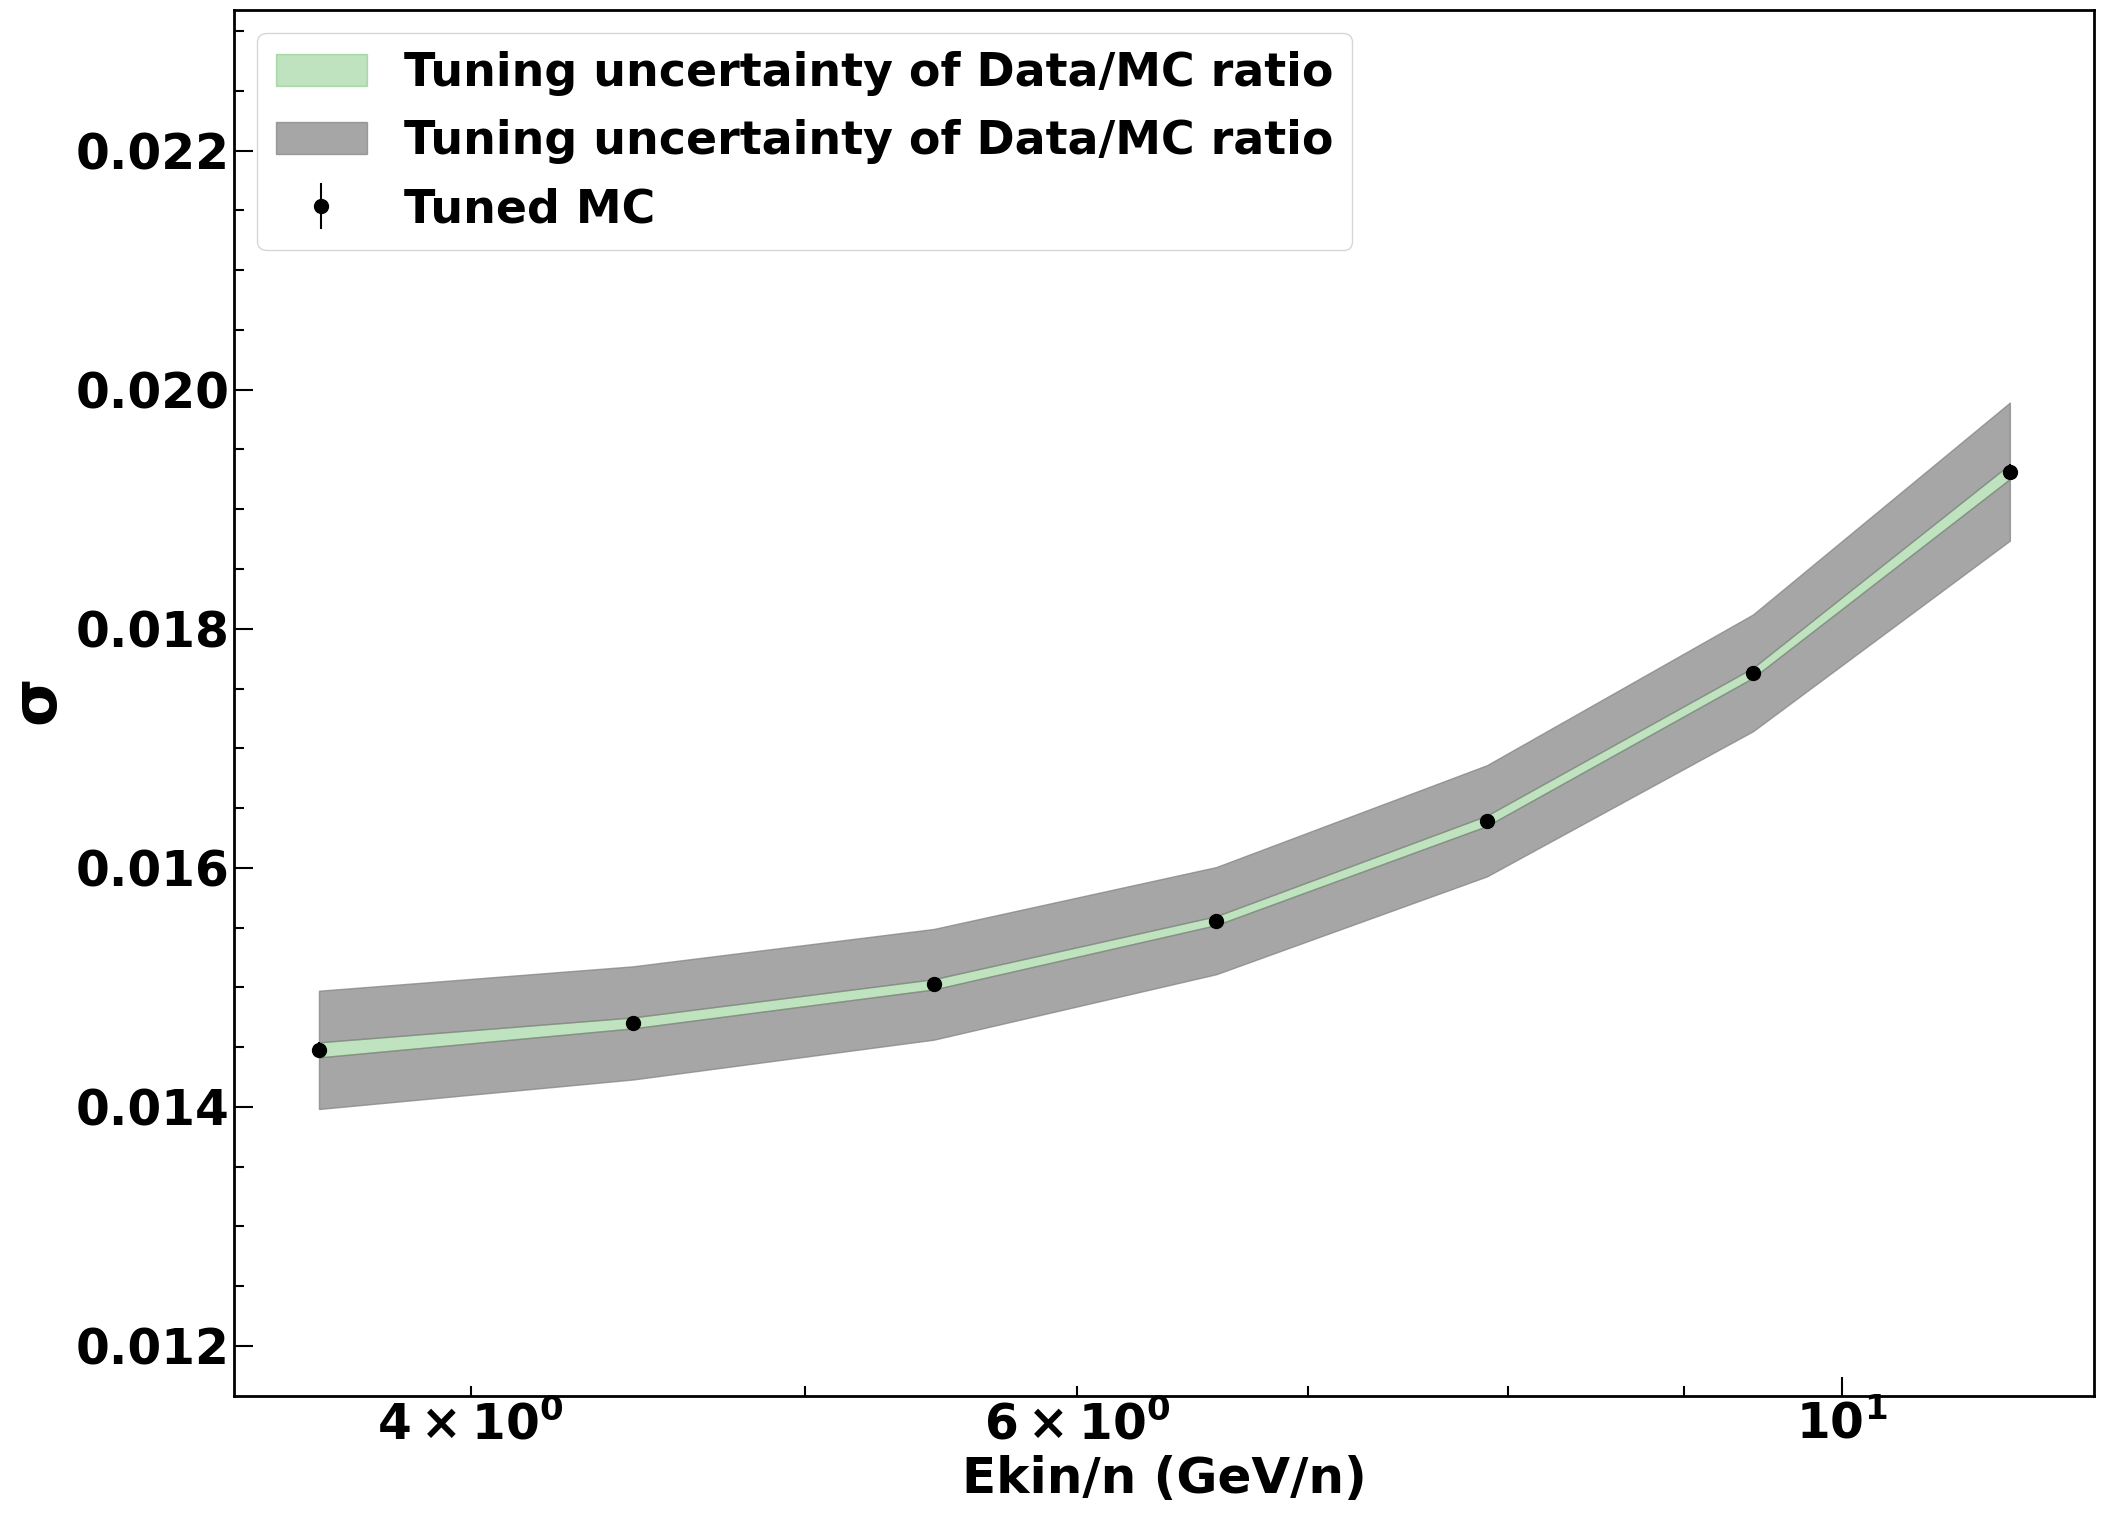

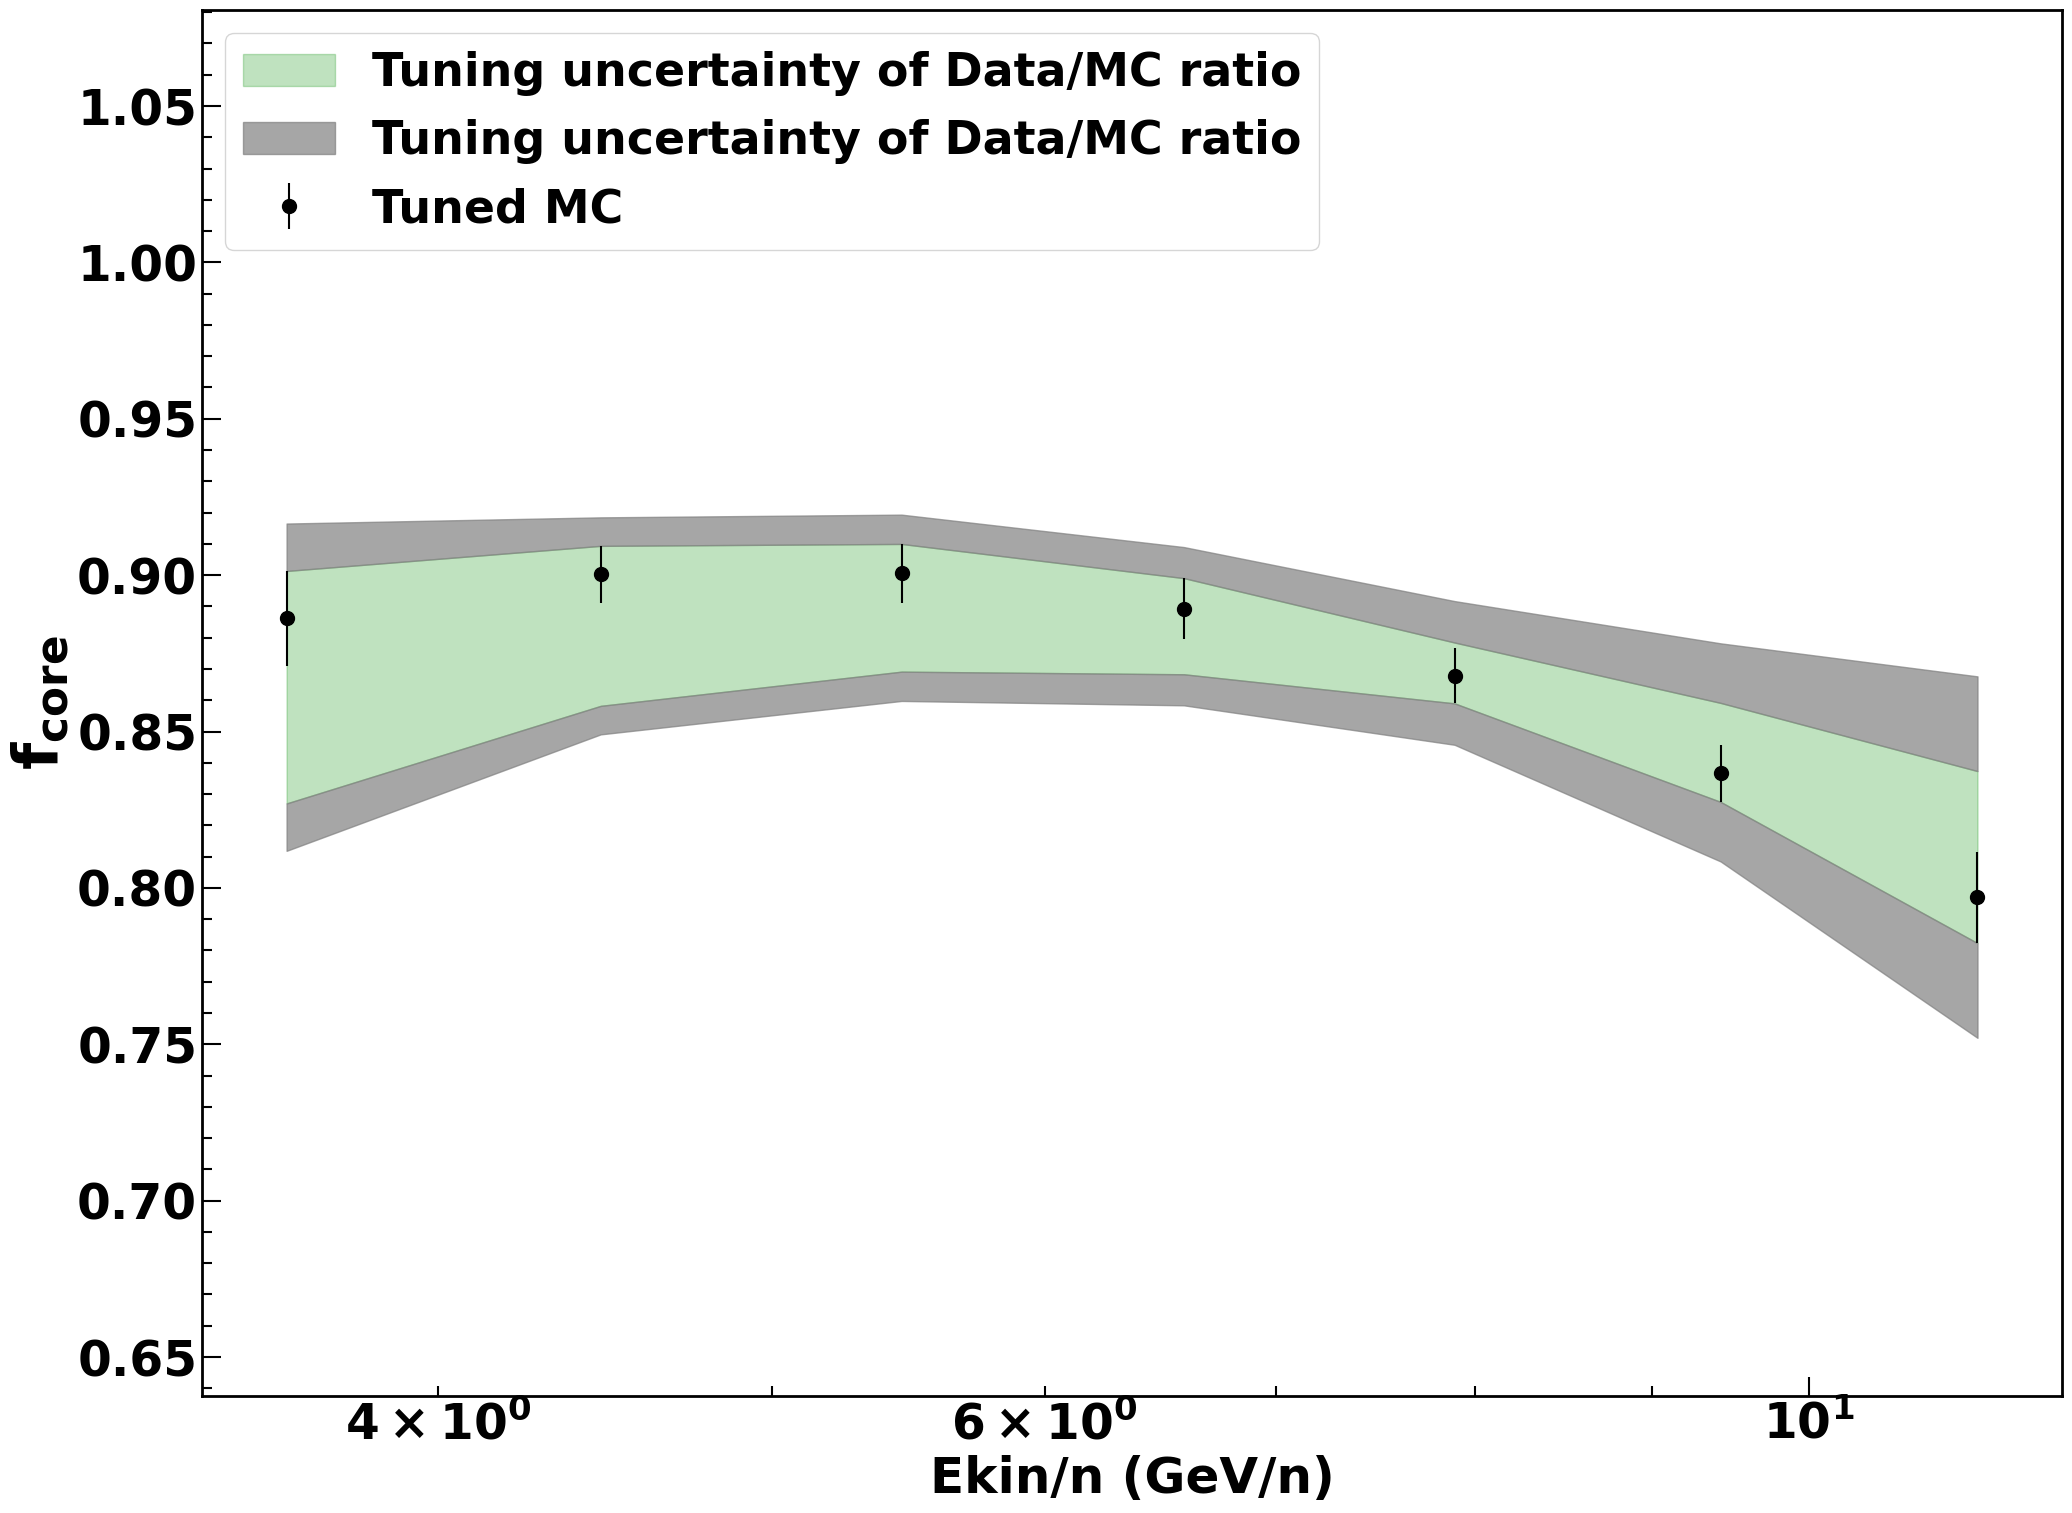

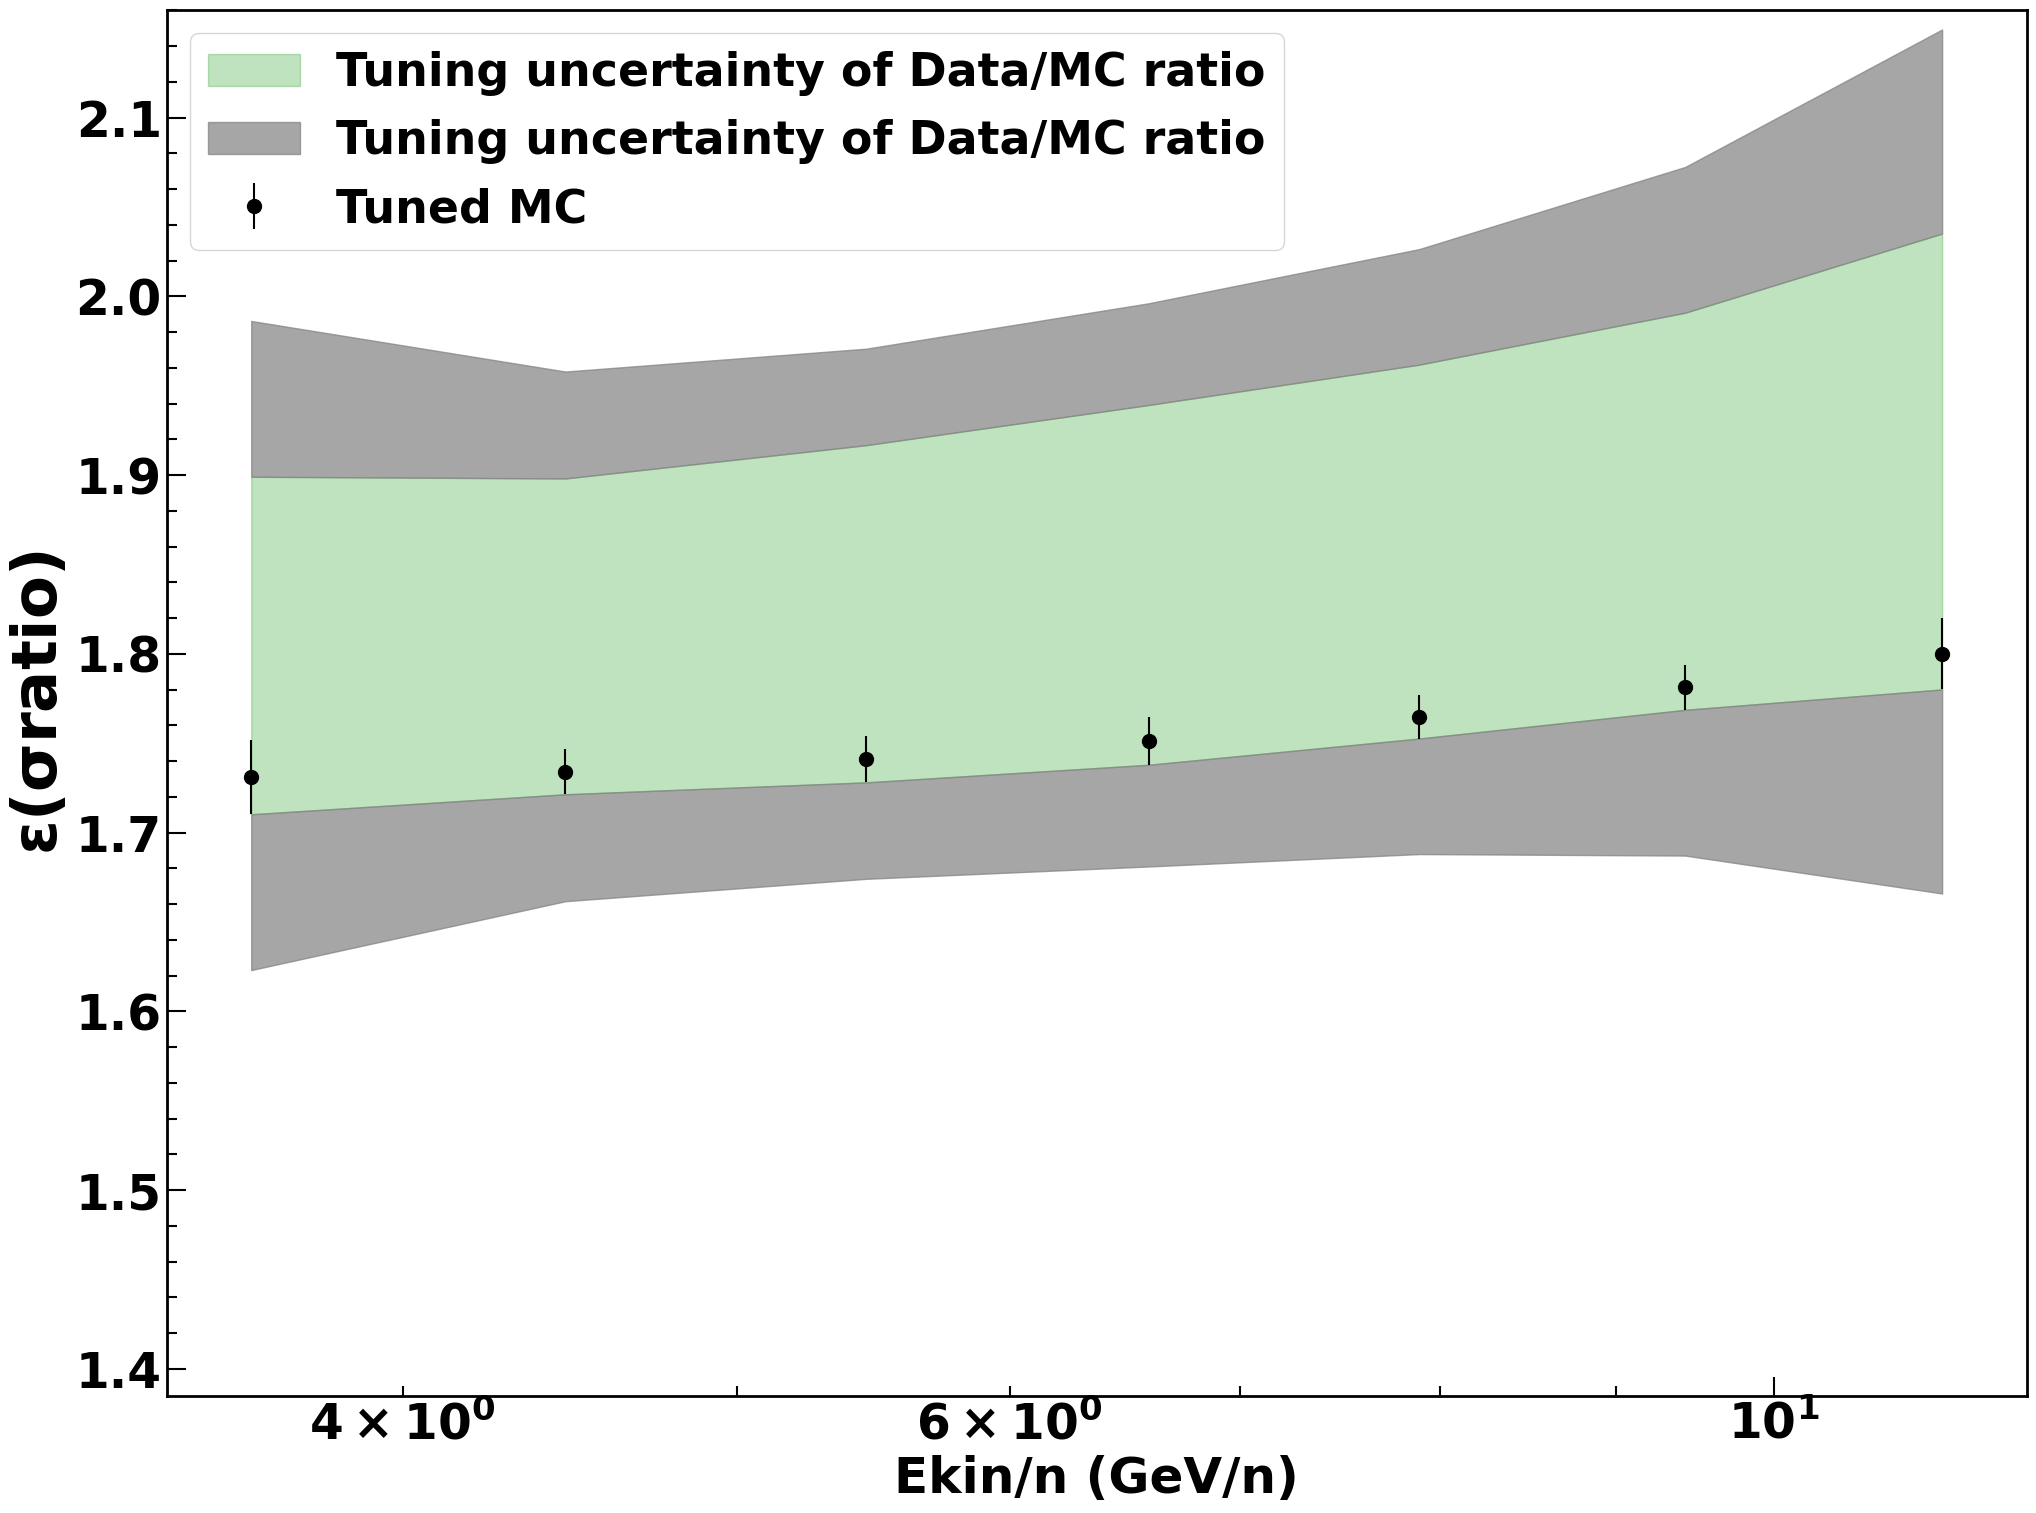

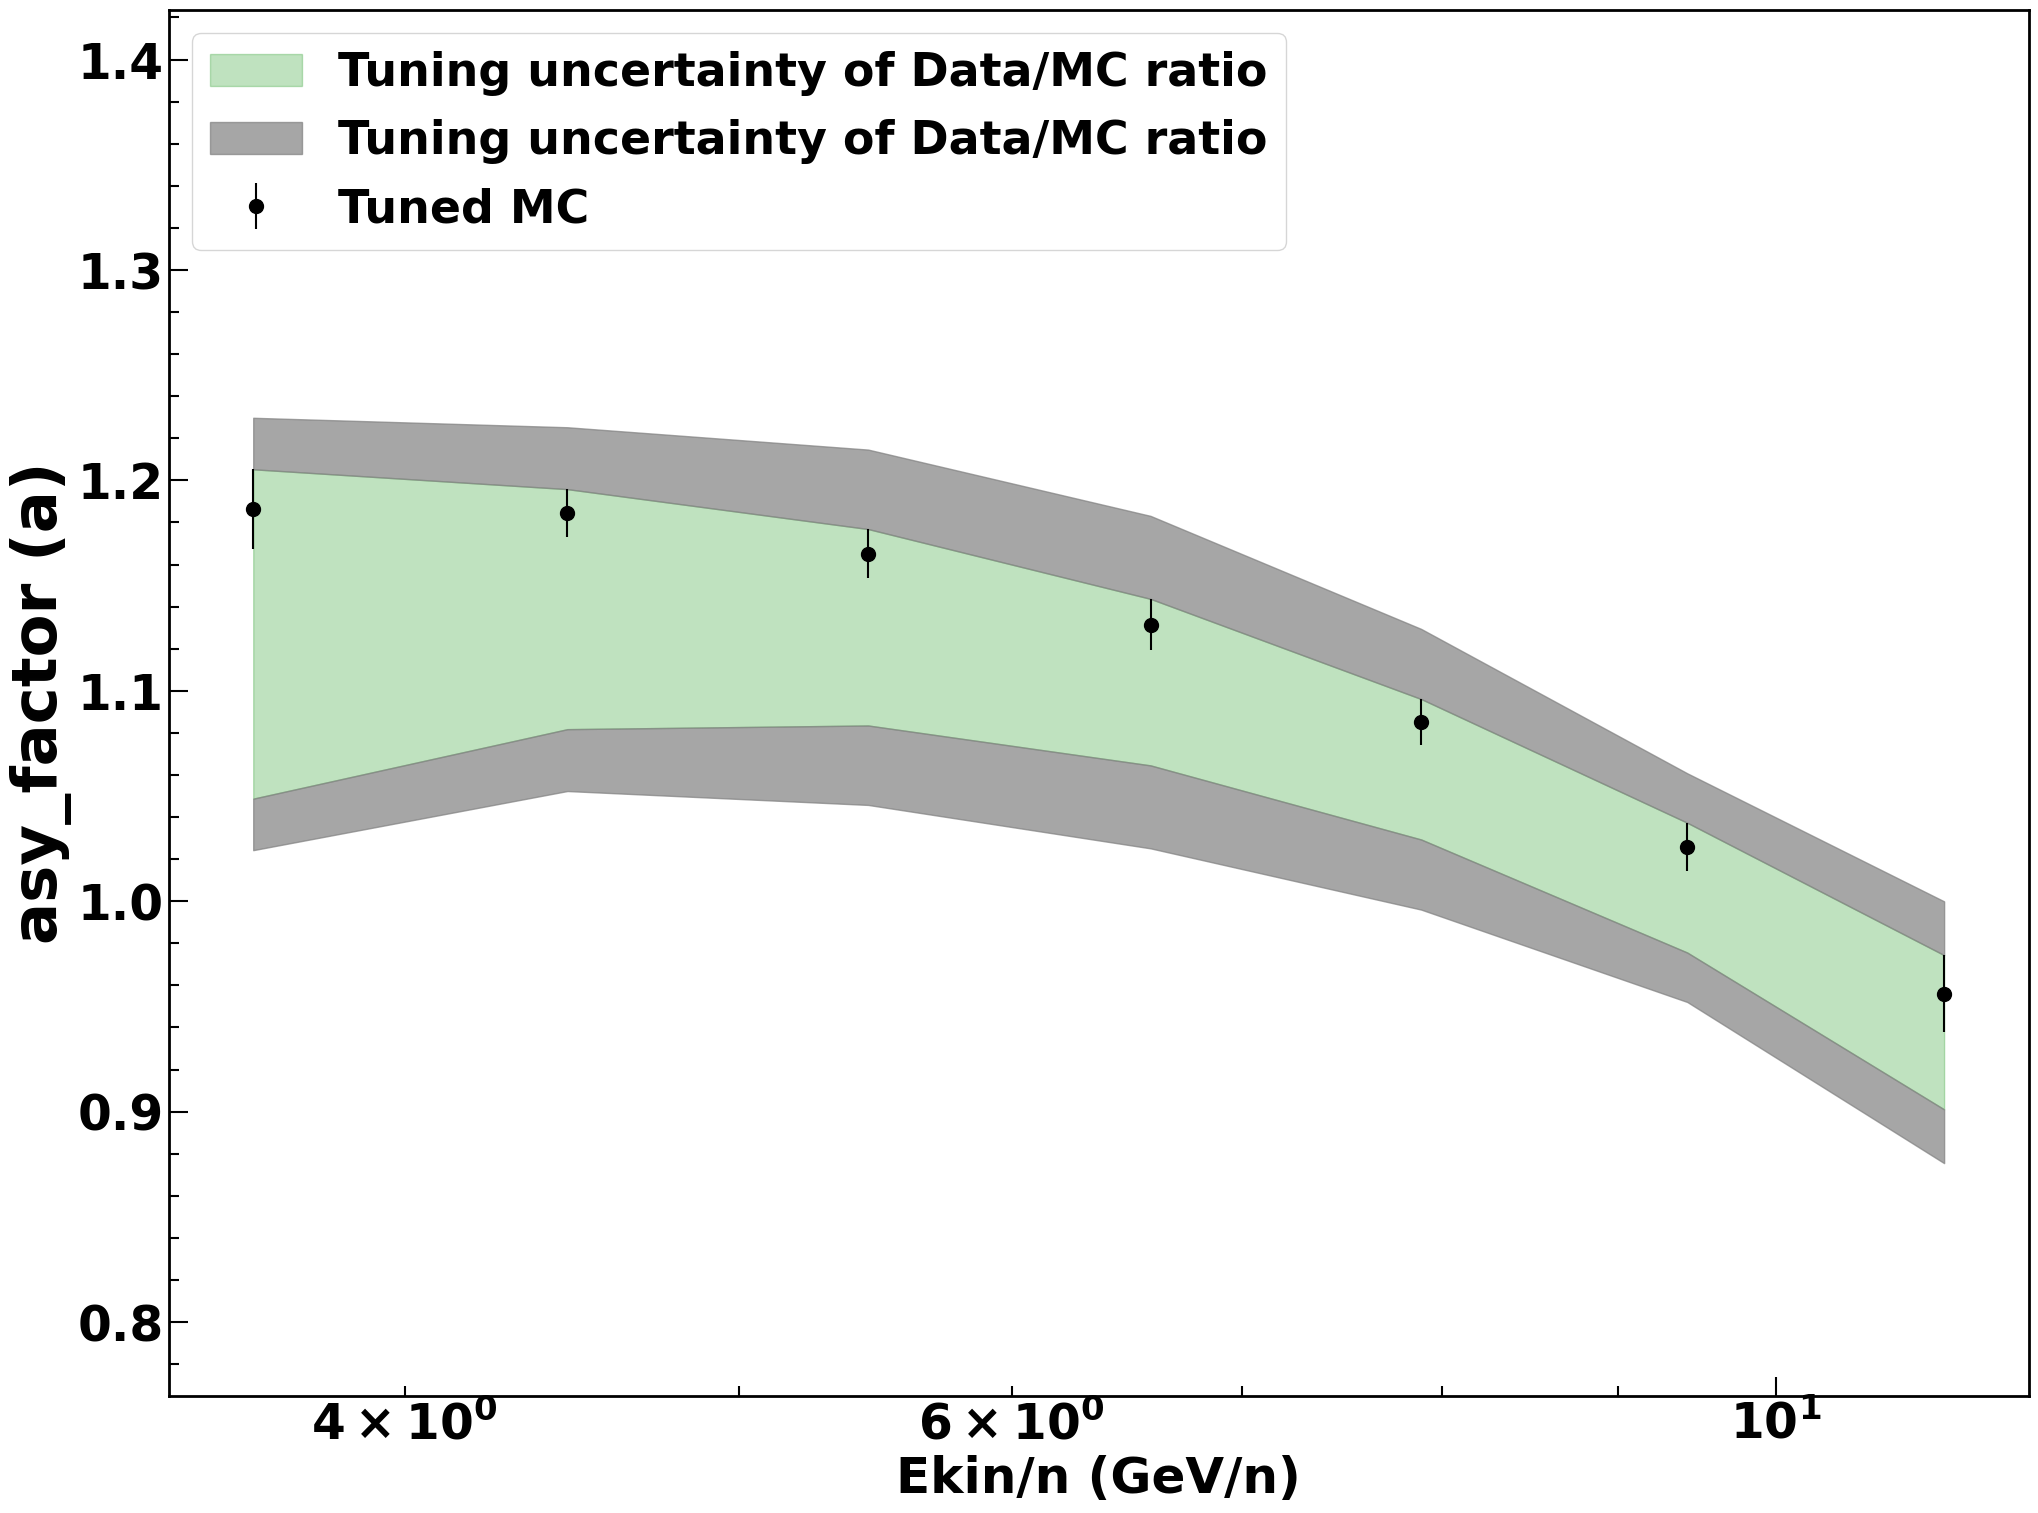

In [23]:
import pickle
from scipy.interpolate import  UnivariateSpline

xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
df_graph_parslim = {}
df_graph_parslim_ext = {}

graph_fitlow = {dec:{} for dec in detectors}
graph_fitup = {dec:{} for dec in detectors}
graph_fitlowmax = {dec:{} for dec in detectors}
graph_fitupmax = {dec:{} for dec in detectors}


filepathTuneMax = {'Tof':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCRigModify5Percent/',
             'NaF':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCRigModify5Percent/',
             'Agl':'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCRigModify5Percent/'}

filepathTune = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedBeta_Rebin'
graph_MaxScale = {dec:{} for dec in detectors}
graph_MaxScaleLow = {dec:{} for dec in detectors}
graph_MaxScaleUp = {dec:{} for dec in detectors}

graph_TunedBeta0 = {dec:{} for dec in detectors}
graphfitted_TunedBeta0 = {dec:{} for dec in detectors}
ylim_range_be7 = {'mean':[0.145, 0.16], 'sigma':[0.013, 0.021], 'sigma_ratio':[1.6, 2.0], 'asy_factor': [0.8, 1.3], 'fraccore':[0.7, 1.0], "norm":[0, 40]} 
splinefit_uncertainty = {dec:{} for dec in detectors}
splinefit_uncertaintymax = {dec:{} for dec in detectors}
graph_MaxScaleErr = {dec:{} for dec in detectors}
df_graph_parslim_max = {}
splinefit_uncertaintyRig = {dec:{} for dec in detectors}
for dec in ['Tof','NaF', 'Agl']:
    for par in parnames:
        
        fig, ax1 = plt.subplots(1, 1, figsize=(24, 18))  
        set_plot_style(ax1) 
        graph_fitlow[dec][par], graph_fitup[dec][par] = plot_errband_constraint(fig, ax1, df_graph_parslim, graph_parsUntuned[dec][par], graph_parsTuned[dec][par],  DETECTOR_COLOR[dec], par, polyfitp0[dec][par])
        #print(dec, par)
        #print(((graph_fitup[dec][par].yvalues - graph_fitlow[dec][par].yvalues)* 0.5)/((graph_fitlow[dec][par].yvalues + graph_fitup[dec][par].yvalues) *0.5))
        splinefit_uncertainty[dec][par] = get_uncertainty_spline(graph_fitlow[dec][par], graph_fitup[dec][par])
        
        
        df_maxscale = np.load(os.path.join(filepathTuneMax[dec], f'df_{par}_{itername}.npz'))
        graph_MaxScale[dec][par] = MGraph.from_file(df_maxscale, f'graph_{par}_{dec}')
        
        df_parT0 = np.load(os.path.join(filepathTune, f'df_{par}_{itername}.npz'))
        graph_TunedBeta0[dec][par] = MGraph.from_file(df_parT0, f'graph_{par}_{dec}')   
        graphfitted_TunedBeta0[dec][par] = GetFitValue(graph_TunedBeta0[dec][par], polyfitp0[dec][par], withsigma=False)
       
        plot_graph(fig, ax1, graphfitted_TunedBeta0[dec][par], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label='Tuned MC')
       
        graph_MaxScaleLow[dec][par], graph_MaxScaleUp[dec][par] = plot_errband_constraint(fig, ax1, df_graph_parslim_ext, graph_MaxScale[dec][par], graph_TunedBeta0[dec][par], 'grey', par, polyfitp0[dec][par], withsig=False)
        
        #graph_MaxScaleErr[dec][par] = getgrapherr(graph_MaxScale[dec][par],  par, polyfitp0[dec][par], withsig=False)
        graph_MaxScaleErr[dec][par] = getgrapherr_fromLowUp(graph_MaxScaleLow[dec][par], graph_MaxScaleUp[dec][par])
 
        ax1.fill_between(graph_fitlow[dec][par].xvalues, graph_fitlow[dec][par].yvalues, graph_fitup[dec][par].yvalues , color=DETECTOR_COLOR[dec], alpha=0.3, label=r'Tuning uncertainty of Data/MC ratio')
       
        ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 1.0 * graph_MaxScaleErr[dec][par].yvalues , graph_fitlow[dec][par].yvalues , color='grey', alpha=0.7, label=r'Tuning uncertainty of Data/MC ratio')
        ax1.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitup[dec][par].yvalues, 1.0 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues , color='grey', alpha=0.7)
    
        
        plt.subplots_adjust(hspace=.0)                                                                                                                                                                                                                                                                                                                                            
        ax1.set_xlabel("Ekin/n (GeV/n)")  
        ax1.set_ylim([0.8 * min(graphfitted_TunedBeta0[dec][par].yvalues), 1.2 *max(graphfitted_TunedBeta0[dec][par].yvalues)] )
        #ax1.set_ylim(ylim_range_be7[par])
        ax1.set_xscale('log')
        ax1.legend(loc='upper left', fontsize=33)
        ax1.set_ylabel(f'{par_names_axes[par]}', fontsize=fontsize1)
        #print(dec, par)
        #ax1.legend()
        #savefig_tofile(fig, plotfile, f'fitrange_{dec}_{par}', 1)
        graph_fitlowmax[dec][par] = MGraph(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 2 * graph_MaxScaleErr[dec][par].yvalues, np.zeros_like(graph_MaxScaleErr[dec][par].xvalues))
        graph_fitupmax[dec][par] = MGraph(graph_MaxScaleErr[dec][par].xvalues, graph_fitup[dec][par].yvalues + 2 * graph_MaxScaleErr[dec][par].yvalues, np.zeros_like(graph_MaxScaleErr[dec][par].xvalues))
        graph_fitlowmax[dec][par].add_to_file(df_graph_parslim_max, f'graph_{par}low_{dec}')
        graph_fitupmax[dec][par].add_to_file(df_graph_parslim_max, f'graph_{par}up_{dec}')
        splinefit_uncertaintymax[dec][par] = get_uncertainty_spline(graph_fitlowmax[dec][par], graph_fitupmax[dec][par])
        splinefit_uncertaintyRig[dec][par] = get_spline_from_graph(graph_MaxScaleErr[dec][par])
       
#with open('/home/manbing/Documents/Data/data_BeP8/splines_pars_uncertainty_rigSigma.pkl', 'wb') as file:
#    pickle.dump(splinefit_uncertaintyRig, file)
    
#with open('/home/manbing/Documents/Data/data_BeP8/splines_pars_uncertaintymax.pkl', 'wb') as file:
#    pickle.dump(splinefit_uncertaintymax, file)
    
#print(splinefit_uncertaintymax.items())
#with open('/home/manbing/Documents/Data/data_BeP8/splines_pars_uncertainty.pkl', 'rb') as file:
#    loaddic = pickle.load(file)
    #print(loaddic.items())
    
#np.savez(os.path.join('/home/manbing/Documents/Data/data_BeP8', 'graph_parslim_TunedUncertainty.npz'), **df_graph_parslim_max)




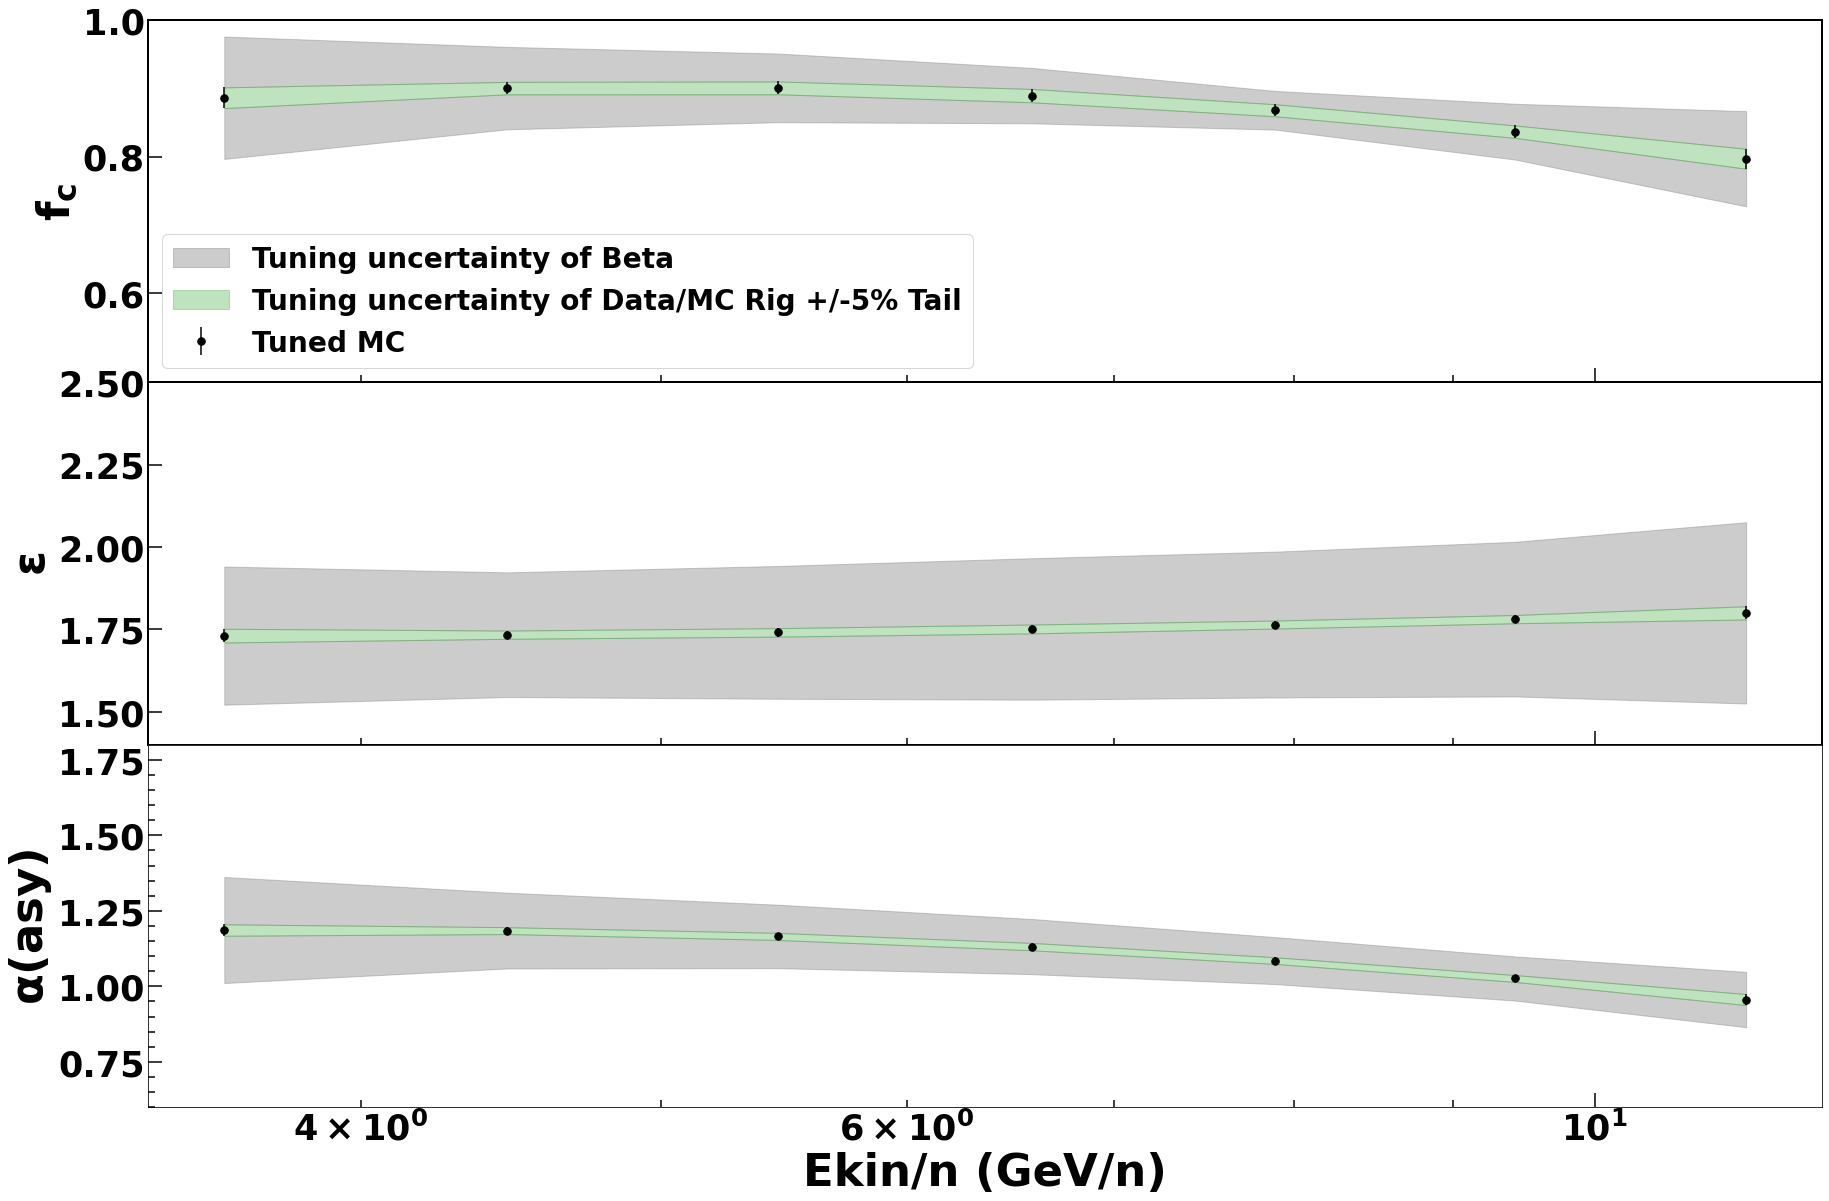

In [95]:
def plotparsonthis(axn, par, dec):
    plot_graph(fig, axn, graphfitted_TunedBeta0[dec][par], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize-5, label='Tuned MC')
    axn.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 2.0 *graph_MaxScaleErr[dec][par].yvalues , graph_fitlow[dec][par].yvalues , color='grey', alpha=0.4, label=r'Tuning uncertainty of Beta')
    axn.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitup[dec][par].yvalues, 2.0 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues , color='grey', alpha=0.4)   
    axn.fill_between(graph_fitlow[dec][par].xvalues, graph_fitlow[dec][par].yvalues, graph_fitup[dec][par].yvalues , color=DETECTOR_COLOR[dec], alpha=0.3, label=r'Tuning uncertainty of Data/MC Rig +/-5% Tail')
    
    #axn.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 2.2 * graph_MaxScaleErr[dec][par].yvalues , graph_fitlow[dec][par].yvalues -  1.1 *graph_MaxScaleErr[dec][par].yvalues , color='grey', alpha=0.3, label=r'Tuning uncertainty due to energy dependence')
    #axn.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitup[dec][par].yvalues , 2.2 * graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues,  color='grey', alpha=0.3)
    axn.set_ylim([0.85 * min(graphfitted_TunedBeta0[dec][par].yvalues), 1.15 *max(graphfitted_TunedBeta0[dec][par].yvalues)] )
    #axn.fill_between(graph_MaxScaleLow[dec][par].xvalues, graph_MaxScaleLow[dec][par].yvalues, graph_MaxScaleUp[dec][par].yvalues , color='blue', alpha=0.3, label=r'uncertainty from MC $\mathrm{\sigma_{\beta}}$ at R>200GV')
    
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios':[0.33, 0.33, 0.33]}, figsize=(30, 20))   
dec = 'Agl'
#plot_graph(fig, ax1, graphfitted_TunedBeta0[dec][par1], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize-5)

#ax1.fill_between(graph_MaxScaleLow[dec][par1].xvalues, graph_MaxScaleLow[dec][par1].yvalues, graph_MaxScaleUp[dec][par1].yvalues, color='blue', alpha=0.3, label='tunning uncertainty 1')
#ax1.fill_between(graph_fitlow[dec][par1].xvalues, graph_fitlow[dec][par1].yvalues, graph_fitup[dec][par1].yvalues*1.003 , color='green', alpha=0.3, label='tunning uncertainty 2')


plotparsonthis(ax1, 'fraccore', dec)
plotparsonthis(ax2, 'sigma_ratio', dec)
plotparsonthis(ax3, 'asy_factor', dec)

ax1.set_xscale('log')
ax1.legend(loc='lower left', fontsize=28)
#ax2.legend(loc='lower right', fontsize=fontsize1-5)
ax2.set_xscale('log')
ax3.set_xscale('log')

ax1.set_ylabel(r'$\mathrm{f_{c}}$', fontsize=fontsize1)
ax2.set_ylabel(r'$\mathrm{\epsilon}$', fontsize=fontsize1)
ax3.set_ylabel(r'$\mathrm{\alpha(asy)}$', fontsize=fontsize1)
ax1.set_ylim([0.47, 1.0])
ax2.set_ylim([1.4, 2.5])
ax3.set_ylim([0.6, 1.8])

ax1.sharex(ax3)   
ax2.sharex(ax3)
    
for label in ax1.get_xticklabels():
    label.set_visible(False)
# Repeat the process for ax2
for label in ax2.get_xticklabels():
    label.set_visible(False)

set_plot_defaultstyle(ax1)                                                                                                                                                                                 
set_plot_defaultstyle(ax2)  
set_plot_defaultstyle(ax3) 
plt.subplots_adjust(hspace=.05)

ax3.set_xlabel('Ekin/n (GeV/n)', fontsize=fontsize1)
savefig_tofile(fig, plotfile, f'Pars_tailpars_iter0_{dec}', 1)


In [1]:
def plotparsonthis(axn, par, dec):
    plot_graph(fig, axn, graphfitted_TunedBeta0[dec][par], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize-5, label='Tuned MC')
    axn.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - 2*graph_MaxScaleErr[dec][par].yvalues , graph_fitlow[dec][par].yvalues , color='grey', alpha=0.3, label=r'uncertainty from energy dependence')
    axn.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitup[dec][par].yvalues, 2* graph_MaxScaleErr[dec][par].yvalues +  graph_fitup[dec][par].yvalues , color='grey', alpha=0.3)   
    axn.fill_between(graph_fitlow[dec][par].xvalues, graph_fitlow[dec][par].yvalues, graph_fitup[dec][par].yvalues , color=DETECTOR_COLOR[dec], alpha=0.3, label=r'uncertainty from tuning $\mathrm{\sigma_{\beta}}$')
    axn.set_ylim([0.85 * min(graphfitted_TunedBeta0[dec][par].yvalues), 1.15 *max(graphfitted_TunedBeta0[dec][par].yvalues)] )
    #axn.fill_between(graph_MaxScaleLow[dec][par].xvalues, graph_MaxScaleLow[dec][par].yvalues, graph_MaxScaleUp[dec][par].yvalues , color='blue', alpha=0.3, label=r'uncertainty from MC $\mathrm{\sigma_{\beta}}$ at R>200GV')
    
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios':[0.33, 0.33, 0.33]}, figsize=(30, 20))   
set_plot_style(ax1) 
set_plot_style(ax2)  
plt.subplots_adjust(hspace=.0)     

par1 = 'fraccore'
dec = 'NaF'
#plot_graph(fig, ax1, graphfitted_TunedBeta0[dec][par1], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize-5)

#ax1.fill_between(graph_MaxScaleLow[dec][par1].xvalues, graph_MaxScaleLow[dec][par1].yvalues, graph_MaxScaleUp[dec][par1].yvalues, color='blue', alpha=0.3, label='tunning uncertainty 1')
#ax1.fill_between(graph_fitlow[dec][par1].xvalues, graph_fitlow[dec][par1].yvalues, graph_fitup[dec][par1].yvalues*1.003 , color='green', alpha=0.3, label='tunning uncertainty 2')


plotparsonthis(ax1, 'fraccore', dec)
plotparsonthis(ax2, 'sigma_ratio', dec)
plotparsonthis(ax3, 'asy_factor', dec)

ax1.set_xscale('log')
ax1.legend(loc='lower left', fontsize=fontsize1-10)
#ax2.legend(loc='lower right', fontsize=fontsize1-5)
ax2.set_xscale('log')
ax3.set_xscale('log')

ax1.set_ylabel(r'$\mathrm{f_{c}}$', fontsize=fontsize1)
ax2.set_ylabel(r'$\mathrm{\epsilon}$', fontsize=fontsize1)
ax3.set_ylabel(r'$\mathrm{\alpha(asy)}$', fontsize=fontsize1)
ax1.set_ylim([0.65, 0.95])
ax2.set_ylim([1.3, 2.0])
ax3.set_ylim([0.8, 1.3])

ax3.set_xlabel('Ekin/n (GeV/n)', fontsize=fontsize1)
savefig_tofile(fig, plotfile, f'Pars_tailpars_iter0_{dec}', 1)


NameError: name 'plt' is not defined

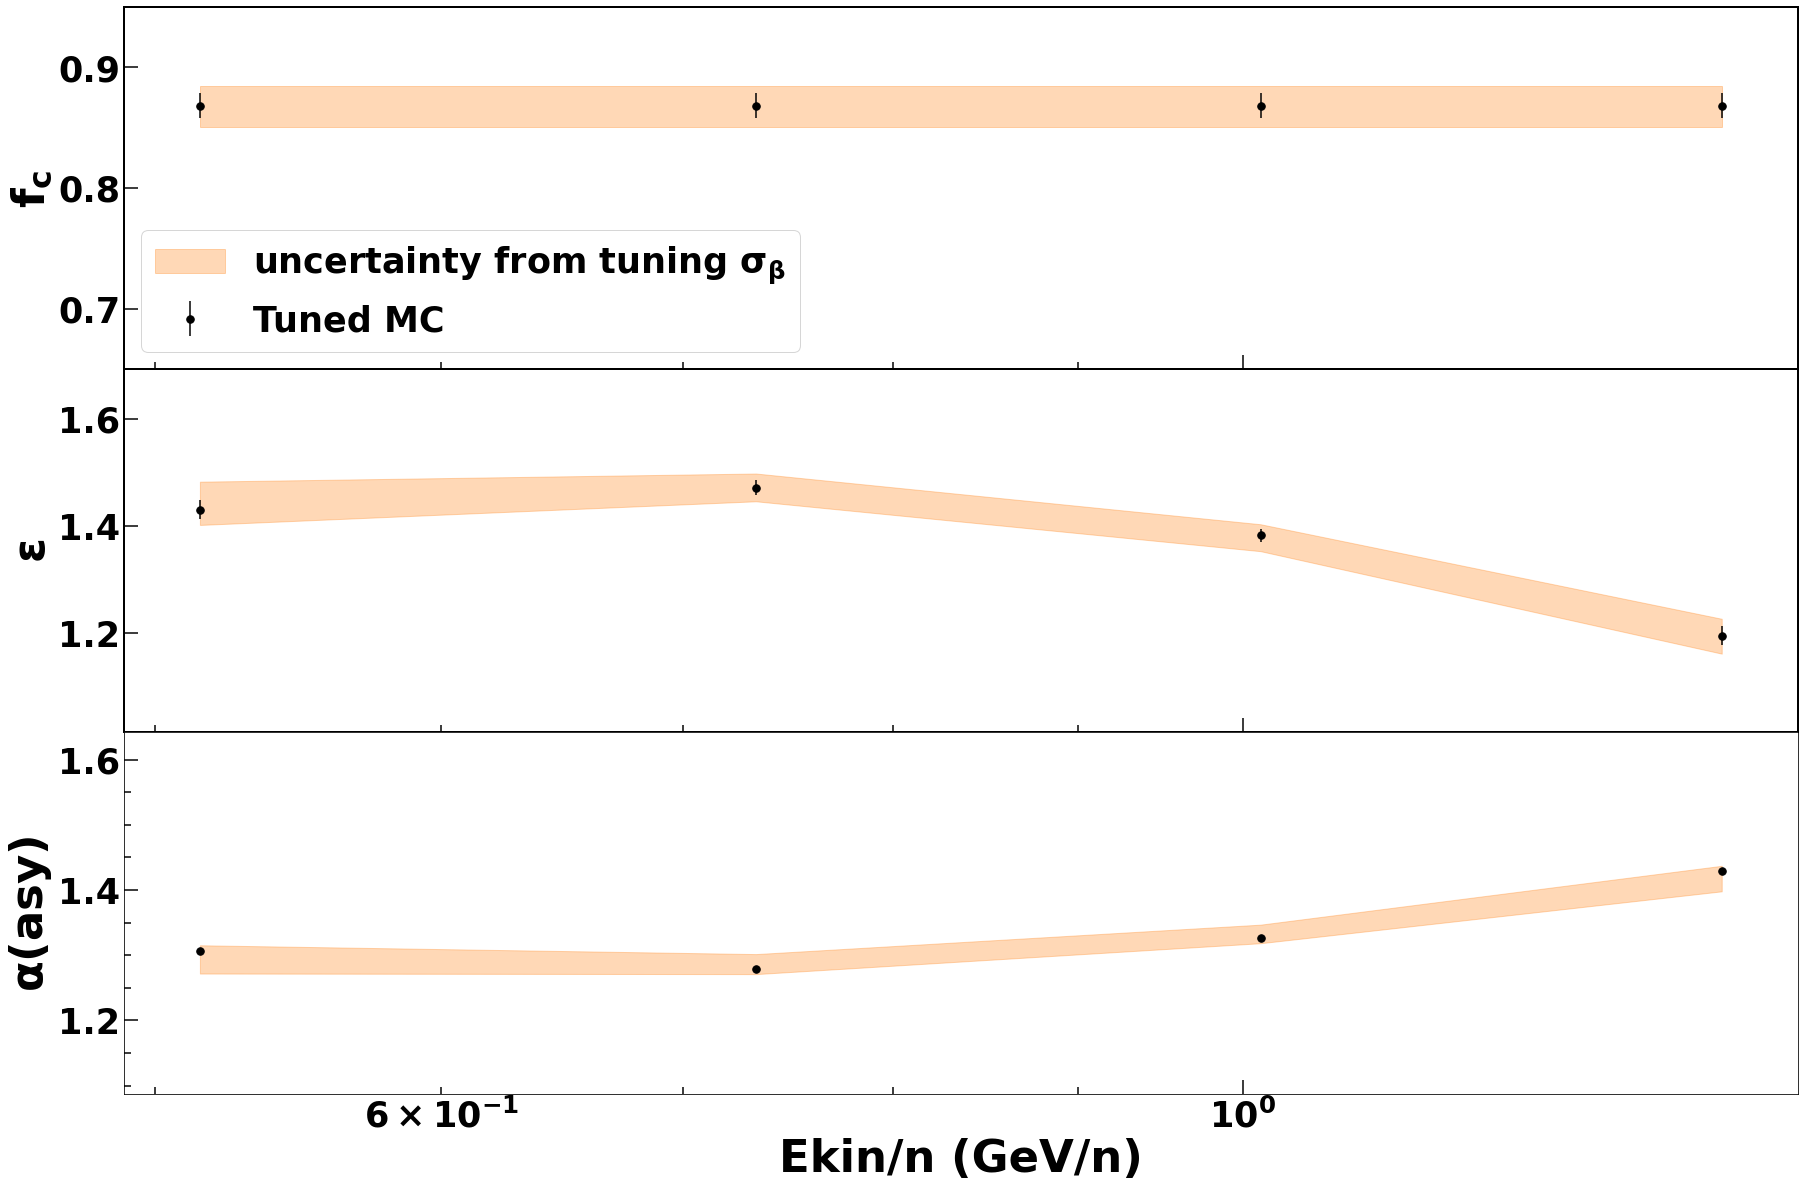

In [35]:
def plotparsonthis(axn, par, dec):
    plot_graph(fig, axn, graphfitted_TunedBeta0[dec][par], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize-5, label='Tuned MC')
    #axn.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitlow[dec][par].yvalues - graph_MaxScaleErr[dec][par].yvalues , graph_fitlow[dec][par].yvalues , color='grey', alpha=0.3, label=r'')
    #axn.fill_between(graph_MaxScaleErr[dec][par].xvalues, graph_fitup[dec][par].yvalues, graph_MaxScaleErr[dec][par].yvalues + graph_fitup[dec][par].yvalues , color='grey', alpha=0.3)   
    #axn.fill_between(graph_fitlow[dec][par].xvalues, graph_fitlow[dec][par].yvalues, graph_fitup[dec][par].yvalues , color=DETECTOR_COLOR[dec], alpha=0.3, label=r'uncertainty from tuning $\mathrm{\sigma_{\beta}}$')
    axn.fill_between(graph_fitlow[dec][par].xvalues, graph_fitlow[dec][par].yvalues, graph_fitup[dec][par].yvalues , color=DETECTOR_COLOR[dec], alpha=0.3, label=r'Tuning uncertainty of Data/MC ratio')
    axn.set_ylim([0.85 * min(graphfitted_TunedBeta0[dec][par].yvalues), 1.15 *max(graphfitted_TunedBeta0[dec][par].yvalues)] )
    #axn.fill_between(graph_MaxScaleLow[dec][par].xvalues, graph_MaxScaleLow[dec][par].yvalues, graph_MaxScaleUp[dec][par].yvalues , color='blue', alpha=0.3, label=r'uncertainty from MC $\mathrm{\sigma_{\beta}}$ at R>200GV')
    
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios':[0.33, 0.33, 0.33]}, figsize=(30, 20))   
set_plot_style(ax1) 
set_plot_style(ax2)  
plt.subplots_adjust(hspace=.0)     

par1 = 'fraccore'
dec = 'Tof'
#plot_graph(fig, ax1, graphfitted_TunedBeta0[dec][par1], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize-5)

#ax1.fill_between(graph_MaxScaleLow[dec][par1].xvalues, graph_MaxScaleLow[dec][par1].yvalues, graph_MaxScaleUp[dec][par1].yvalues, color='blue', alpha=0.3, label='tunning uncertainty 1')
#ax1.fill_between(graph_fitlow[dec][par1].xvalues, graph_fitlow[dec][par1].yvalues, graph_fitup[dec][par1].yvalues*1.003 , color='green', alpha=0.3, label='tunning uncertainty 2')


plotparsonthis(ax1, 'fraccore', dec)
plotparsonthis(ax2, 'sigma_ratio', dec)
plotparsonthis(ax3, 'asy_factor', dec)

ax1.set_xscale('log')
ax1.legend(loc='lower left', fontsize=fontsize1-10)
#ax2.legend(loc='lower right', fontsize=fontsize1-5)
ax2.set_xscale('log')
ax3.set_xscale('log')

ax1.set_ylabel(r'$\mathrm{f_{c}}$', fontsize=fontsize1)
ax2.set_ylabel(r'$\mathrm{\epsilon}$', fontsize=fontsize1)
ax3.set_ylabel(r'$\mathrm{\alpha(asy)}$', fontsize=fontsize1)
ax1.set_ylim([0.65, 0.95])
#ax2.set_ylim([1.55, 2.0])
#ax3.set_ylim([0.8, 1.3])

ax3.set_xlabel('Ekin/n (GeV/n)', fontsize=fontsize1)
savefig_tofile(fig, plotfile, f'Pars_tailpars_iter0_{dec}', 1)



xvalues			yvalues			yerrs
3.61425			0.01431263695473087			0.0
4.45875			0.014592692546719048			0.0
5.4516			0.01491622128867454			0.0
6.58395			0.015444955992932285			0.0
7.88955			0.01624124715802118			0.0
9.425			0.01745566443632217			0.0
11.190249999999999			0.019062796726223075			0.0


xvalues			yvalues			yerrs
3.61425			0.014622641169163581			0.0
4.45875			0.014824803347186633			0.0
5.4516			0.015135802748600026			0.0
6.58395			0.015652362689157137			0.0
7.88955			0.016521730448032835			0.0
9.425			0.017813197660797035			0.0
11.190249999999999			0.019653760685437262			0.0

up - low: [0.00031    0.00023211 0.00021958 0.00020741 0.00028048 0.00035753
 0.00059096]
Agl sigma


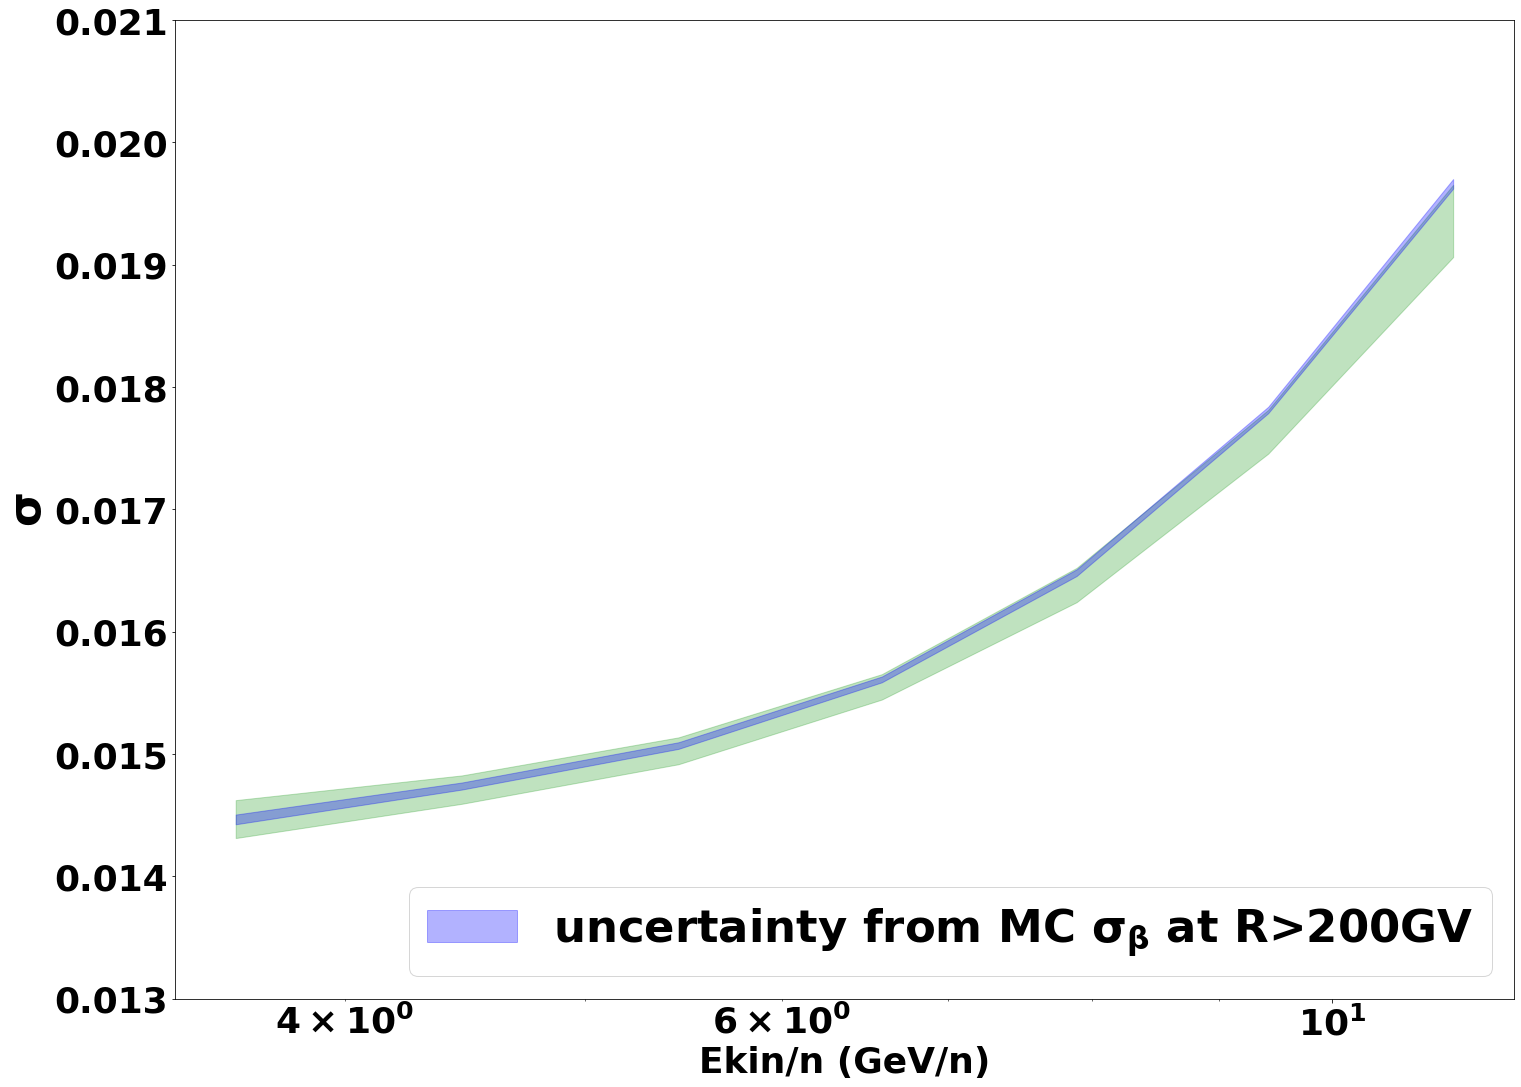

In [30]:
dec = 'Agl'
par = 'sigma'
filepathTuneMax = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCTunedMax_Rebin'
df_sigma_maxscale = np.load(os.path.join(filepathTuneMax, f'df_{par}_{n_iter}.npz'))
graph_sigmaMaxScale = MGraph.from_file(df_sigma_maxscale, f'graph_{par}_{dec}')
#ax1.fill_between(graph_fitlow[dec][par].xvalues, graph_fitlow[dec][par].yvalues, graph_fitup[dec][par].yvalues , color=DETECTOR_COLOR[dec], alpha=0.3)
fig, ax1 = plt.subplots(1, 1, figsize=(24, 18)) 
#plot_graph(fig, ax1, graph_sigmaMaxScale, color='blue', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label='uncertainty MC')
print(graph_fitlow[dec][par])
print(graph_fitup[dec][par])
graph_fitlow[dec][par], graph_fitup[dec][par] = plot_errband_constraint(fig, ax1, df_graph_parslim, graph_parsUntuned[dec][par], graph_parsTuned[dec][par],  DETECTOR_COLOR[dec], par, polyfitp0[dec][par])
ax1.fill_between(graph_fitlow[dec][par].xvalues, graph_fitlow[dec][par].yvalues, graph_fitup[dec][par].yvalues , color=DETECTOR_COLOR[dec], alpha=0.3)
ax1.fill_between(graph_MaxScaleLow[dec][par].xvalues, graph_MaxScaleLow[dec][par].yvalues, graph_MaxScaleUp[dec][par].yvalues , color='blue', alpha=0.3, label=r'uncertainty from MC $\mathrm{\sigma_{\beta}}$ at R>200GV')
#ax1.fill_between(graph_fitlow[dec][par].xvalues, graph_sigmaMaxScale[dec][par].yvalues, graph_sigmaMaxScale[dec][par].yvalues+abs(graph_sigmaMaxScale.yerrs) , color='blue', alpha=0.3)
plt.subplots_adjust(hspace=.0)                                                                                                                                             
ax1.set_xlabel("Ekin/n (GeV/n)")     
ax1.set_ylim(ylim_range_be7[par])
#ax1.set_ylabel(r'$\mathrm{\mu}$', fontsize=fontsize1)
ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=fontsize1)
ax1.set_ylabel(f'{par_names_axes[par]}', fontsize=fontsize1)
print(dec, par)
plotfile = '/home/manbing/Documents/lithiumanalysis/slides/isotopes_2411'
savefig_tofile(fig, plotfile, f'fitrange_{dec}_{par}_total', 1)


KeyError: 'NaF'

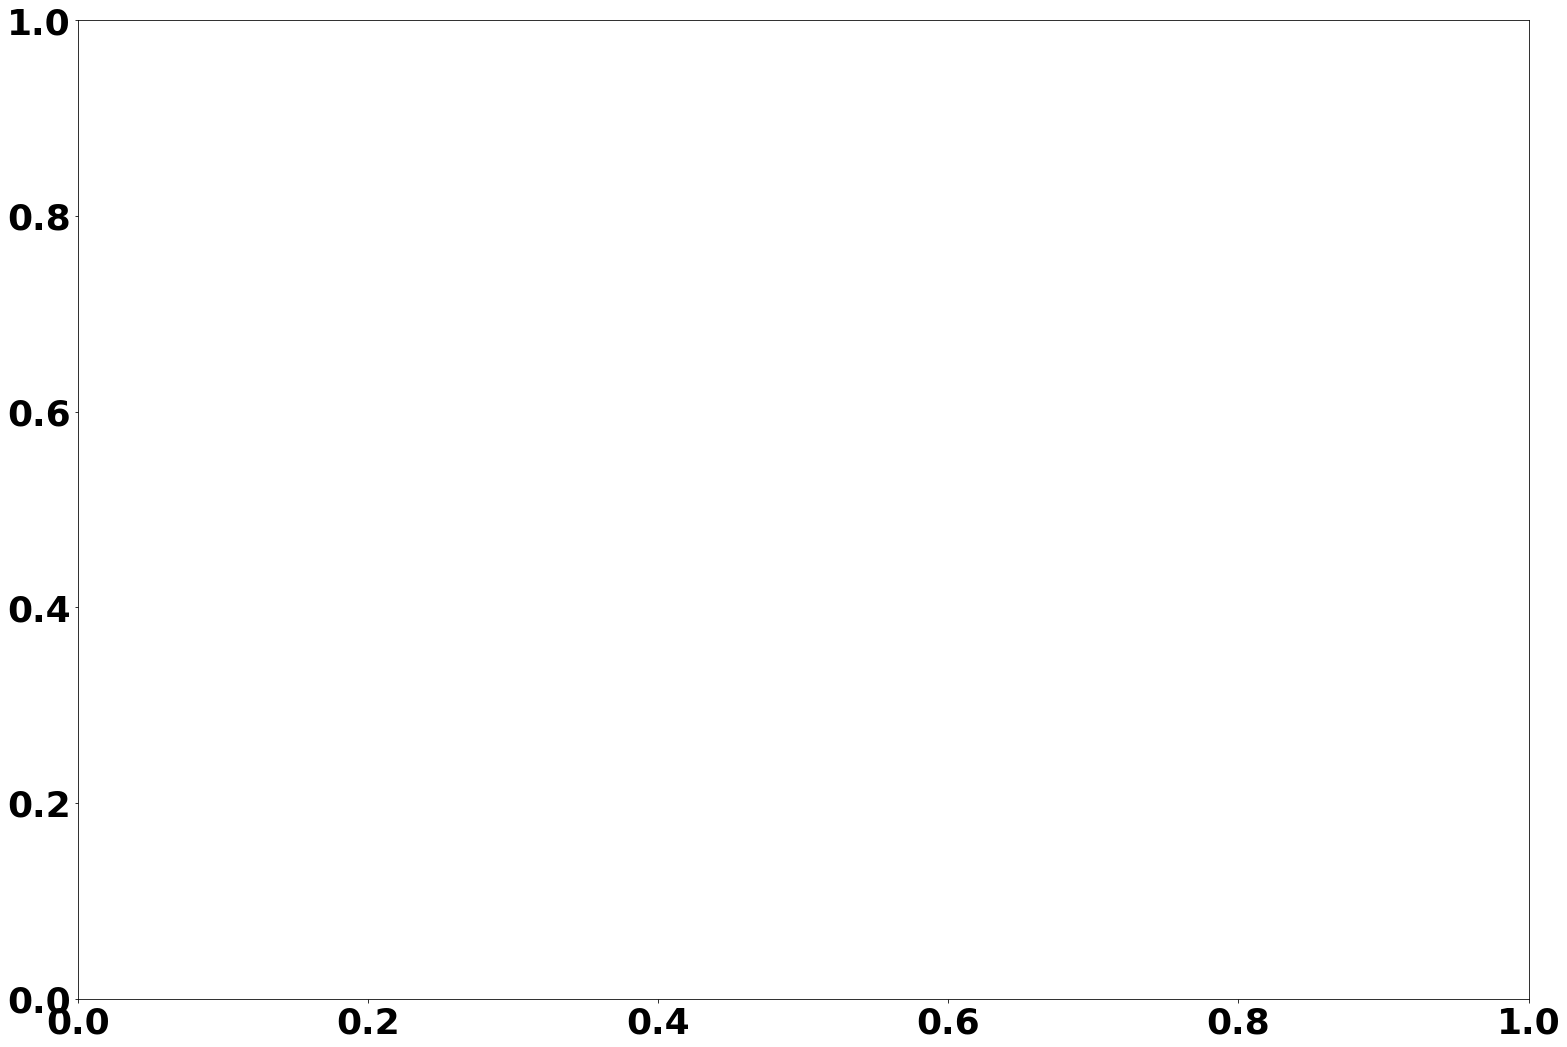

In [31]:
fig, ax1 = plt.subplots(1, 1, figsize=(26, 18)) 
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
df_graph_parslim = {}
for dec in detectors:
    graph_sigfitlow, graph_sigfitup = plot_errband_constraint(fig, ax1, df_graph_parslim, graph_sigmaU[dec], graph_sigmaT[dec], DETECTOR_COLOR[dec], 'sigma', p0_mean[dec])
    ax1.fill_between(graph_fitlow[dec]['sigma'].xvalues, graph_fitlow[dec]['sigma'].yvalues, graph_fitup[dec]['sigma'].yvalues , color=DETECTOR_COLOR[dec], alpha=0.3) 
    print(graph_sigfitup.yvalues - graph_sigfitlow.yvalues)
    

#pagl = np.array([-0.01055, 0.0485, -0.03083, 0.006571])
pagl = np.array([-0.09e-3, 30.13e-3, -20.32e-3, 4.643e-3])
ax1.plot(graph_sigma['Agl'].xvalues, poly(np.log(graph_sigma['Agl'].xvalues), *pagl), '--', color='red', label='fit data')

ax1.text(0.6, 0.9, r'$\mathrm{p_{0} = -0.0001 \pm 0.0002}$', fontsize=28,  verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='black')
ax1.text(0.6, 0.86, r'$\mathrm{p_{1} = 0.0301 \pm 0.0001}$', fontsize=28,  verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='black')
ax1.text(0.6, 0.82, r'$\mathrm{p_{2} = -0.0203 \pm 0.0001}$', fontsize=28,  verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='black')
ax1.text(0.6, 0.78, r'$\mathrm{p_{3} = -0.0046 \pm 0.0000}$', fontsize=28,  verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='black')

#pnaf = np.array([0.0179, -0.0026, 0.0016])
#ax2.plot(graph_sigma['NaF'].xvalues, poly(np.log(graph_sigma['NaF'].xvalues), *pnaf), '--', color='red')                                                                                                                                                                     
ax1.set_ylim([0.012, 0.022])
ax1.set_xlabel('Ekin/n (GeV/n)', fontsize=fontsize1)
ax1.set_ylabel(r'$\mathrm{\sigma}$', fontsize=fontsize1)
ax1.legend(loc='lower right', fontsize=fontsize1)
ax1.set_xscale('log')
ax1.text(xaxistext[dec], 0.98,  f"{DETECTOR_LABEL[dec]}", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=DETECTOR_COLOR[dec], fontweight="bold") 
savefig_tofile(fig, plotfile, 'fitData_constraint_sigma_Agl', 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Ekin/n (GeV/n)')

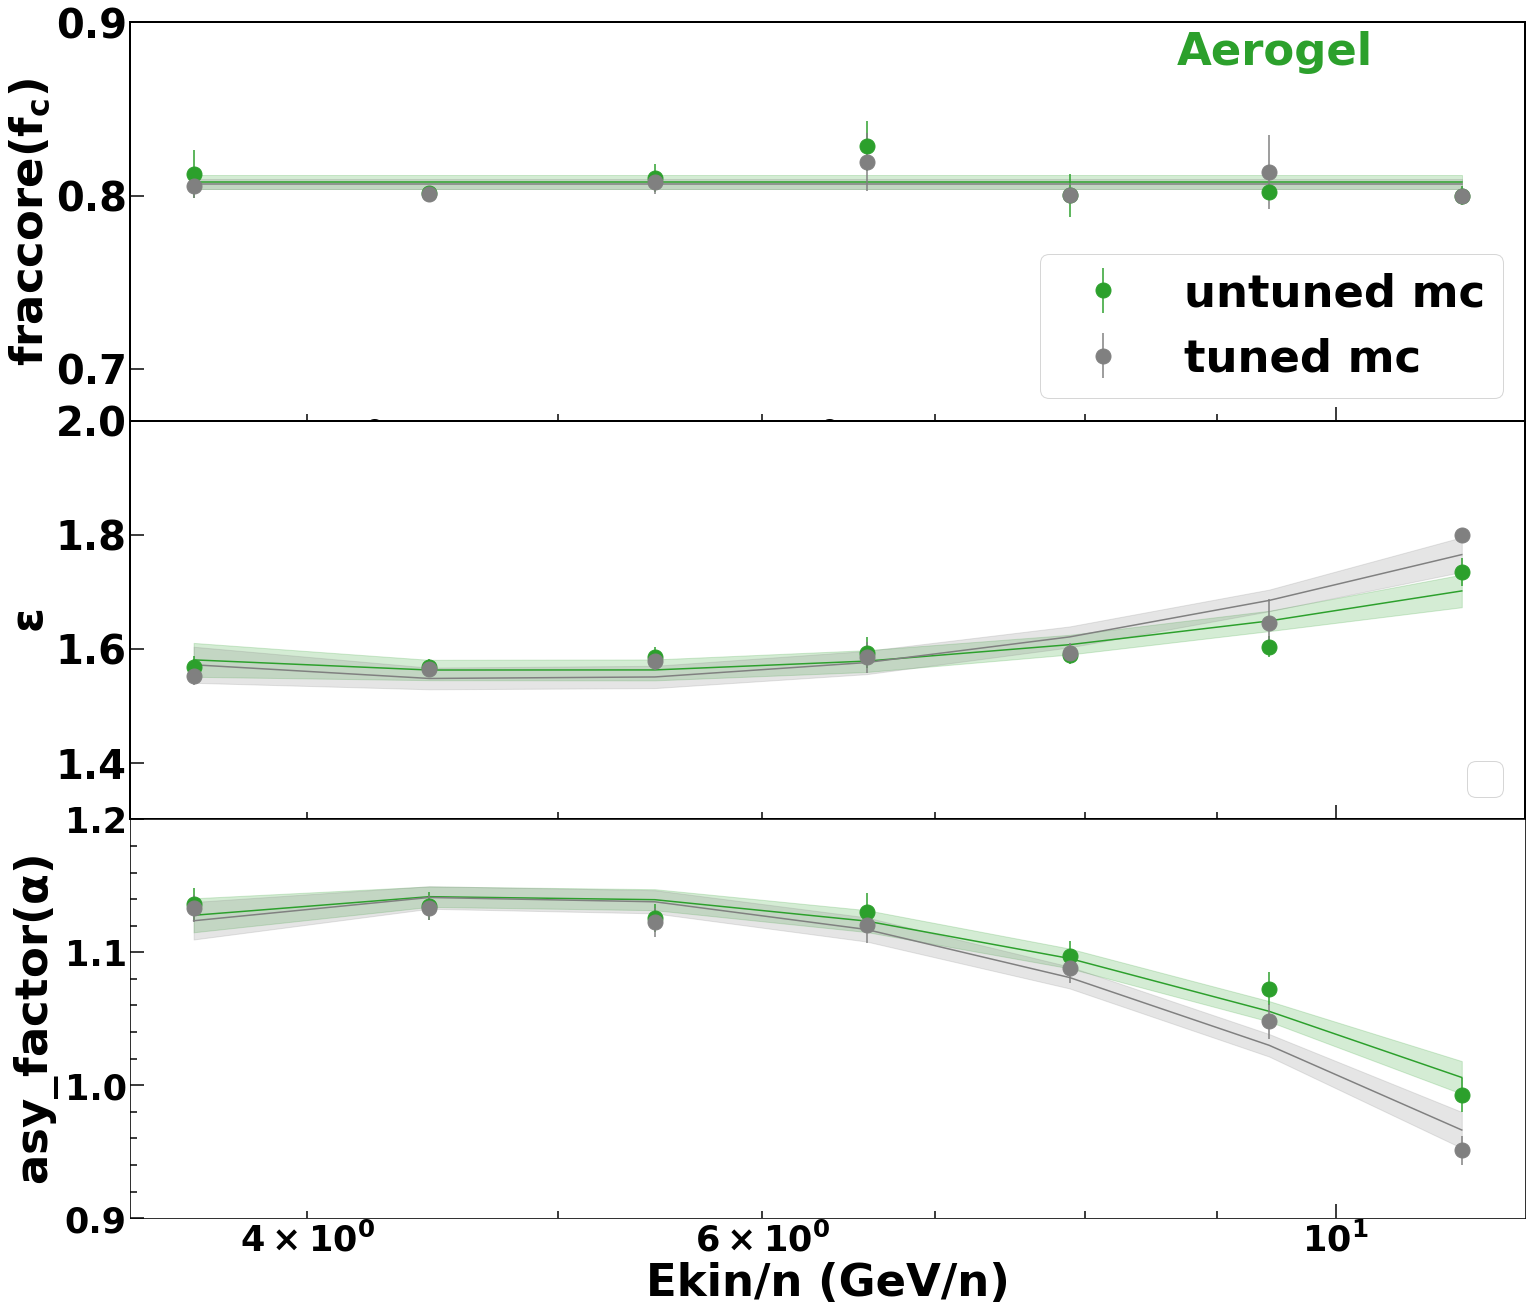

In [231]:

from tools.constants import ISOTOPES_MASS
from tools.massfit_tools import get_fitpdferrorband
import uncertainties                                                                                                                                                                                               
from uncertainties import unumpy                                                                                                                                                                                   
from uncertainties import ufloat  

n_iter = 'iter0'

filepathU = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMassUntuned_Rebin/fitBe7/'
filepathT = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMassTunedBetaHighR_Rebin/fitBe7/'

df_fraccoreU = np.load(os.path.join(filepathU, f'df_fraccore_{n_iter}.npz'))
df_fraccoreT = np.load(os.path.join(filepathT, f'df_fraccore_{n_iter}.npz'))
df_sigmaratioU = np.load(os.path.join(filepathU, f'df_sigma_ratio_{n_iter}.npz'))
df_sigmaratioT = np.load(os.path.join(filepathT, f'df_sigma_ratio_{n_iter}.npz'))
df_alphaU = np.load(os.path.join(filepathU, f'df_asy_factor_{n_iter}.npz'))
df_alphaT = np.load(os.path.join(filepathT, f'df_asy_factor_{n_iter}.npz'))

graph_fraccoreU = {}
graph_fraccoreT = {}

graph_sigmaratioU = {}
graph_sigmaratioT = {}

graph_alphaU = {}
graph_alphaT = {}

for dec in detectors:
    graph_fraccoreU[dec] = MGraph.from_file(df_fraccoreU, f'graph_fraccore_{dec}')
    graph_fraccoreT[dec] = MGraph.from_file(df_fraccoreT, f'graph_fraccore_{dec}')
    graph_sigmaratioU[dec] = MGraph.from_file(df_sigmaratioU, f'graph_sigma_ratio_{dec}')
    graph_sigmaratioT[dec] = MGraph.from_file(df_sigmaratioT, f'graph_sigma_ratio_{dec}')
    graph_alphaU[dec] = MGraph.from_file(df_alphaU, f'graph_asy_factor_{dec}')
    graph_alphaT[dec] = MGraph.from_file(df_alphaT, f'graph_asy_factor_{dec}')

slicevalue_trueratio ={'Tof':[0.3, 1.2], 'NaF':[0.9, 6.0], 'Agl':[3.5, 12.0]}
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios':[0.33, 0.33, 0.33]}, figsize=(25, 22))                                                                     
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
p0_mean = {'Tof':[0.9], 'NaF':[0.8], "Agl":[0.8]}
p0_sigma = {'Tof':[1.0, 0.1, 0.1], 'NaF':[1.0], "Agl":[1.0, 0.1, 0.1]}

for dec in detectors: 
    plot_parswitherr(fig, ax1, graph_fraccoreU[dec], DETECTOR_COLOR[dec], p0_mean[dec], labelname='untuned mc')
    plot_parswitherr(fig, ax1, graph_fraccoreT[dec], 'grey', p0_mean[dec], labelname='tuned mc')
    plot_parswitherr(fig, ax2, graph_sigmaratioU[dec], DETECTOR_COLOR[dec], p0_sigma[dec])
    plot_parswitherr(fig, ax2, graph_sigmaratioT[dec], 'grey', p0_sigma[dec])
    plot_parswitherr(fig, ax3, graph_alphaU[dec], DETECTOR_COLOR[dec], p0_sigma[dec])
    plot_parswitherr(fig, ax3, graph_alphaT[dec], 'grey', p0_sigma[dec])
    ax1.text(xaxistext[dec], 0.98,  f"{DETECTOR_LABEL[dec]}", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=DETECTOR_COLOR[dec], fontweight="bold")      
    
set_plot_style(ax1) 
set_plot_style(ax2)  
equation_text = r'$\mathrm{\mu = p_{0} + p_{1} \cdot x + p_{2} \cdot x^{2} , x = \log(E)}$'
#ax1.text(0.03, 0.15, equation_text, fontsize=35, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='black') 
equation_sig = r'$\mathrm{\sigma = p_{0} + p_{1} \cdot x + p_{2} \cdot x^{2} + (p_{3} \cdot x^{3}), x = \log(E)}$'
equation_sig = r'$\mathrm{\sigma = \sum_{i}p_{i}\cdot x^{i}, x = \log(E)}$'
#ax2.text(0.03, 0.18, equation_sig, fontsize=35, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color='black') 
plt.subplots_adjust(hspace=.0)                                                                                                                                                                   
#ax1.set_xticklabels([])                                                                                                                                                                          
ax1.set_xlabel("Ekin/n (GeV/n)") 
#ax1.set_xscale('log')
#ax1.fill_betweenx(np.linspace(0.75, 0.8, 100), 1.0, 4.0, alpha=0.1, color="tab:blue") 
#ax1.axhline(y=ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'], color='orange', linestyle='--') 

#ax1.axhline(y=1.0, color='orange', linestyle='--')  
#ax1.axhline(y=0.77869417, color='black', linestyle='--')  

ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=fontsize1)
ax2.legend(loc='lower right', fontsize=fontsize1)
ax2.set_xscale('log')
ax3.set_xscale('log')

ax1.set_ylabel(r'$\mathrm{fraccore (f_{c})}$', fontsize=fontsize1)
ax2.set_ylabel(r'$\mathrm{\epsilon}$', fontsize=fontsize1)
ax3.set_ylabel(r'$\mathrm{asy\_factor (\alpha)}$', fontsize=fontsize1)
ax1.set_ylim([0.67, 0.9])
ax2.set_ylim([1.3, 2.0])
ax3.set_ylim([0.9, 1.2])
ax3.set_xlabel('Ekin/n (GeV/n)', fontsize=fontsize1)
#savefig_tofile(fig, plotfile, 'mean_sigma_iter2', 1)




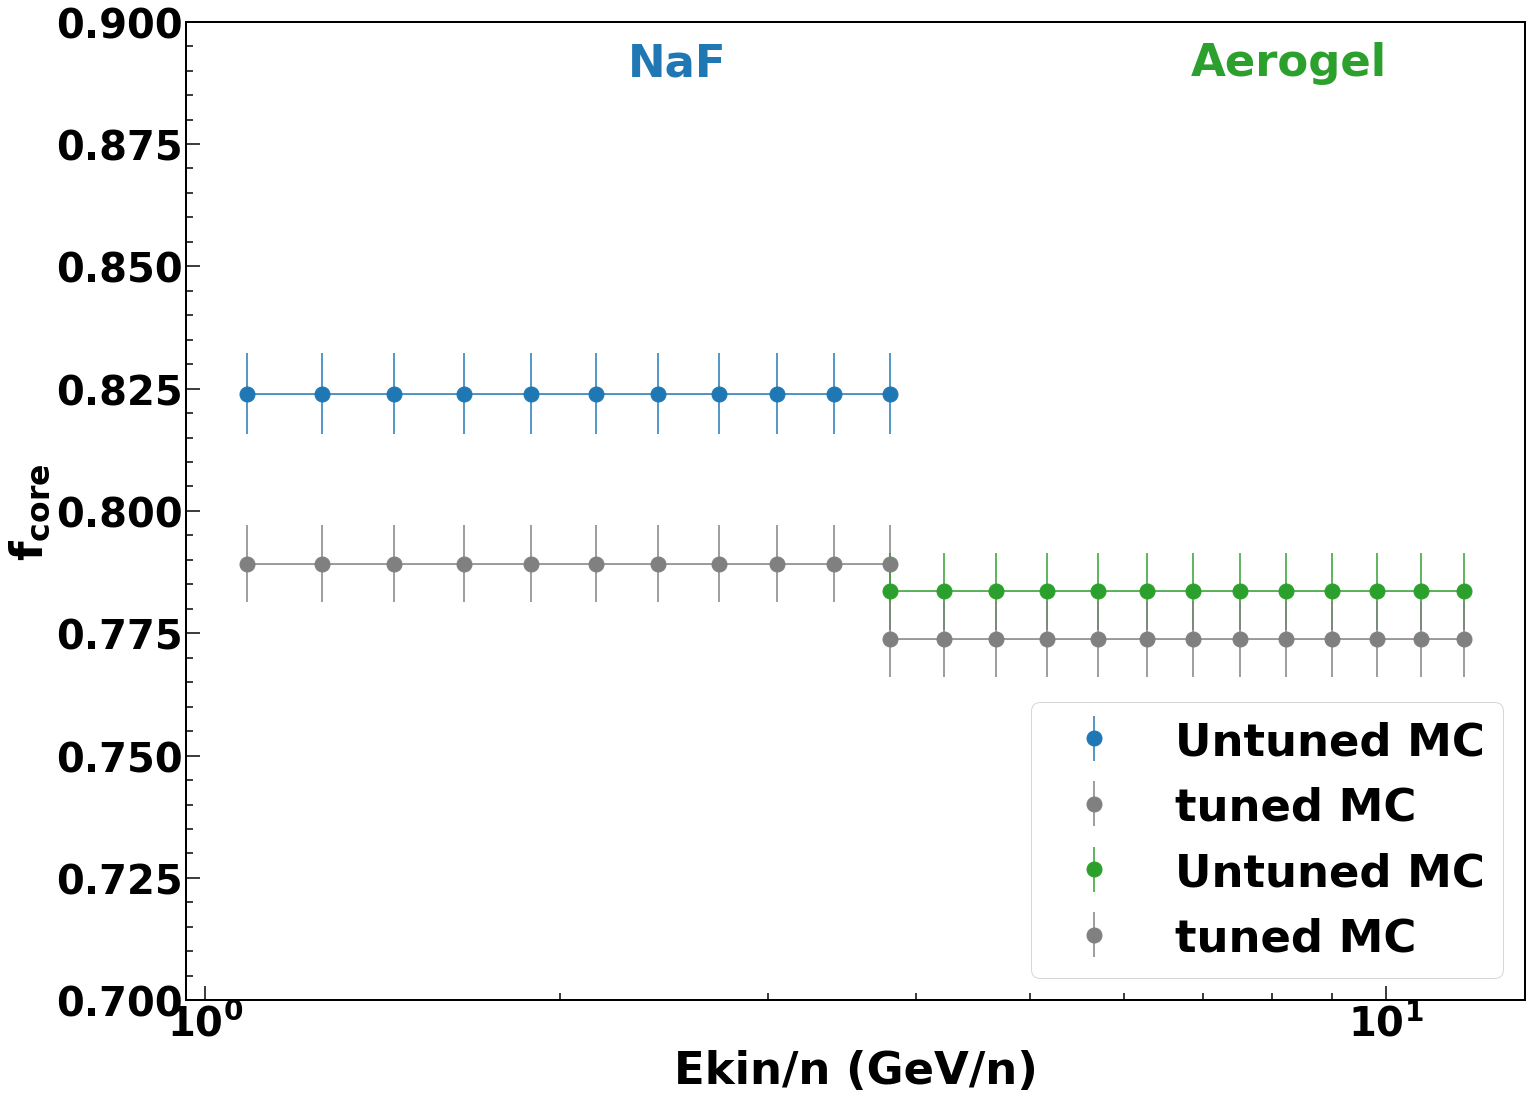

In [226]:
from tools.constants import ISOTOPES_MASS
from tools.massfit_tools import get_fitpdferrorband
import uncertainties                                                                                                                                                                                               
from uncertainties import unumpy                                                                                                                                                                                   
from uncertainties import ufloat    


parname = 'fraccore'
decs = ['NaF', 'Agl']

file_1Untuned = f'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMassUntuned/fitBe7/df_{parname}_iter2Be7.npz'
file_2Tuned = f'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMassTunedBetaHighR/fitBe7/df_{parname}_iter2Be7.npz'
df1Untuned = np.load(f'{file_1Untuned}')
df2Tuned = np.load(f'{file_2Tuned}')

graph1U = {}
graph2T = {}

for dec in decs:
    graph1U[dec] = MGraph.from_file(df1Untuned, f'graph_{parname}_{dec}')
    graph2T[dec] = MGraph.from_file(df2Tuned, f'graph_{parname}_{dec}')

slicevalue_trueratio ={'Tof':[0.3, 1.2], 'NaF':[0.9, 6.0], 'Agl':[3.5, 12.0]}
fig, ax1 = plt.subplots(1, 1, figsize=(24, 18))                                                                     
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
#p0 = {'Tof':[0.9], 'NaF':[0.8], "Agl":[0.8]}
p0 = {'Tof':[1.0, 0.1, 0.1], 'NaF':[1.0], "Agl":[1.0, 0.1, 0.1]}

for dec in decs: 
    plot_parswitherr(fig, ax1, graph1U[dec], DETECTOR_COLOR[dec], p0_mean[dec], labelname='Untuned MC')
    plot_parswitherr(fig, ax1, graph2T[dec], 'grey', p0_mean[dec], labelname='tuned MC')
    ax1.text(xaxistext[dec], 0.98,  f"{DETECTOR_LABEL[dec]}", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=DETECTOR_COLOR[dec], fontweight="bold")      
    
set_plot_style(ax1)                                                                                                                                  
ax1.set_xlabel("Ekin/n (GeV/n)") 
ax1.set_ylim(ylim_range_be7[parname])
ax1.set_xlabel('Ekin/n (GeV/n)', fontsize=fontsize1)
ax1.set_ylabel(f'{par_names_axes[parname]}', fontsize=fontsize1)
ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=fontsize1)
#savefig_tofile(fig, plotfile, 'mean_sigma_iter2', 1)




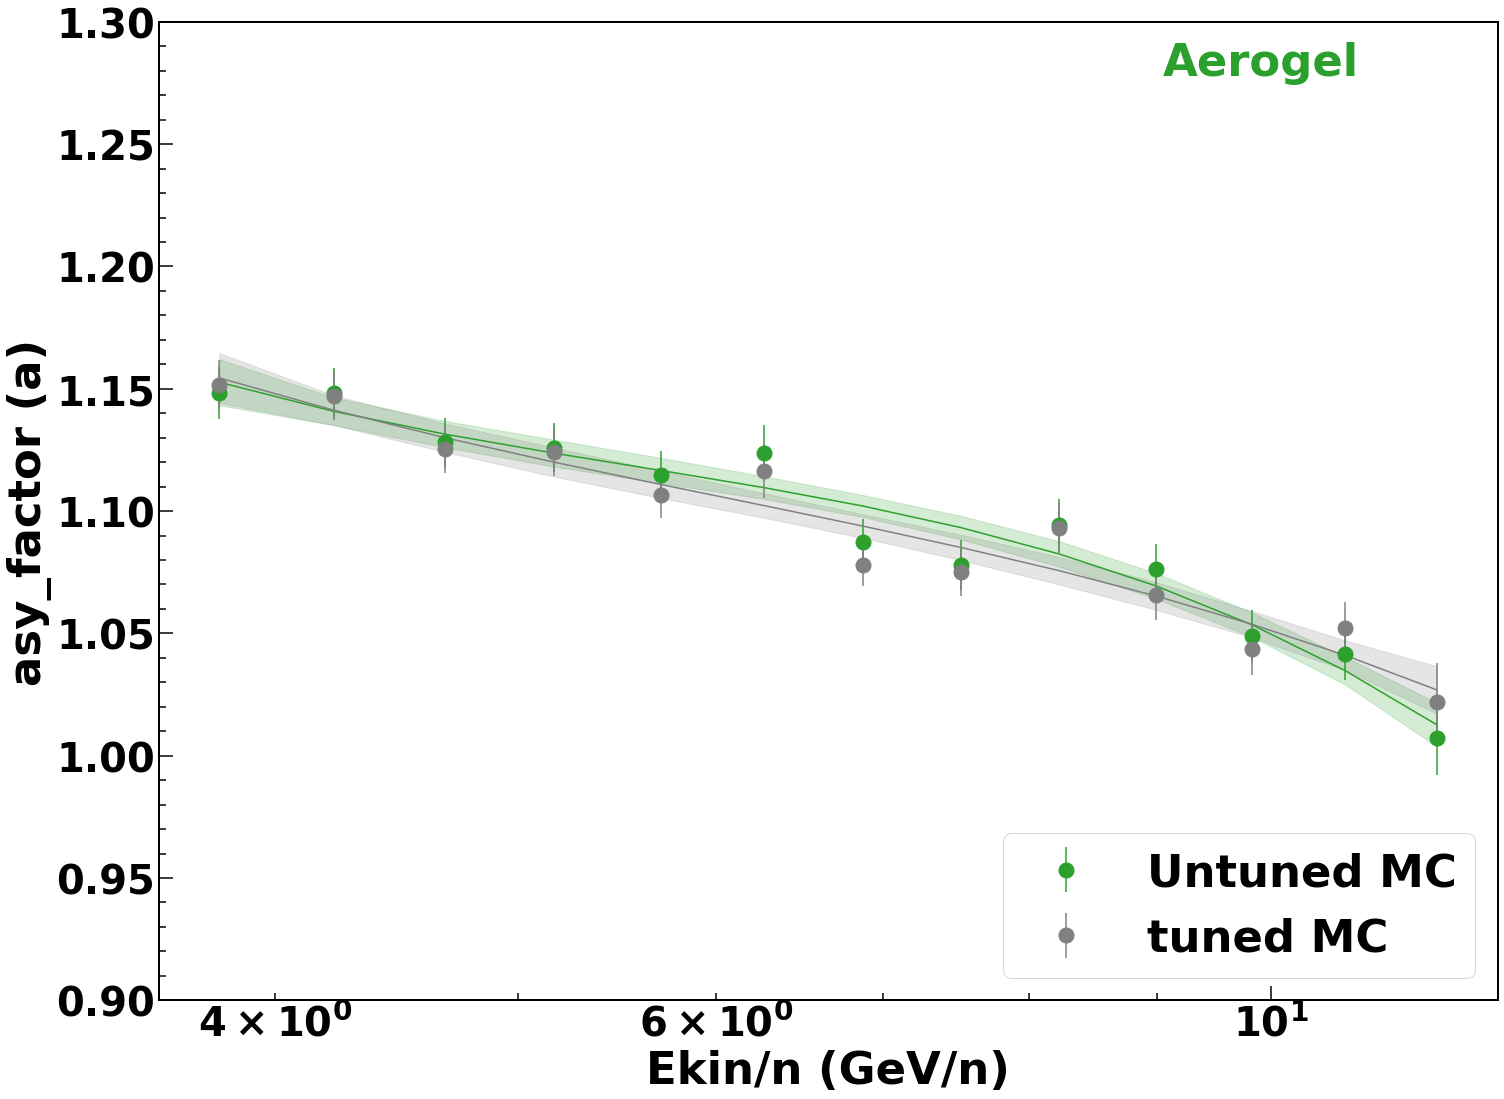

In [104]:
from tools.constants import ISOTOPES_MASS
from tools.massfit_tools import get_fitpdferrorband
import uncertainties                                                                                                                                                                                               
from uncertainties import unumpy                                                                                                                                                                                   
from uncertainties import ufloat    


parname = 'asy_factor'
decs = ['Agl']

file_1Untuned = f'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMassUntuned/fitBe7/df_{parname}_iter2Be7.npz'
file_2Tuned = f'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMassTunedBetaHighR/fitBe7/df_{parname}_iter2Be7.npz'
df1Untuned = np.load(f'{file_1Untuned}')
df2Tuned = np.load(f'{file_2Tuned}')

graph1U = {}
graph2T = {}

for dec in decs:
    graph1U[dec] = MGraph.from_file(df1Untuned, f'graph_{parname}_{dec}')
    graph2T[dec] = MGraph.from_file(df2Tuned, f'graph_{parname}_{dec}')

slicevalue_trueratio ={'Tof':[0.3, 1.2], 'NaF':[0.9, 6.0], 'Agl':[3.5, 12.0]}
fig, ax1 = plt.subplots(1, 1, figsize=(24, 18))                                                                     
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
#p0 = {'Tof':[0.9], 'NaF':[0.8], "Agl":[0.8]}
p0 = {'Tof':[1.0, 0.1, 0.1], 'NaF':[1.0], "Agl":[1.0, 0.1, 0.1]}

for dec in decs: 
    plot_parswitherr(fig, ax1, graph1U[dec], DETECTOR_COLOR[dec], p0_mean[dec], labelname='Untuned MC')
    plot_parswitherr(fig, ax1, graph2T[dec], 'grey', p0_mean[dec], labelname='tuned MC')
    ax1.text(xaxistext[dec], 0.98,  f"{DETECTOR_LABEL[dec]}", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=DETECTOR_COLOR[dec], fontweight="bold")      
    
set_plot_style(ax1)                                                                                                                                  
ax1.set_xlabel("Ekin/n (GeV/n)") 
ax1.set_ylim(ylim_range_be7[parname])
ax1.set_xlabel('Ekin/n (GeV/n)', fontsize=fontsize1)
ax1.set_ylabel(f'{par_names_axes[parname]}', fontsize=fontsize1)
ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=fontsize1)
#savefig_tofile(fig, plotfile, 'mean_sigma_iter2', 1)




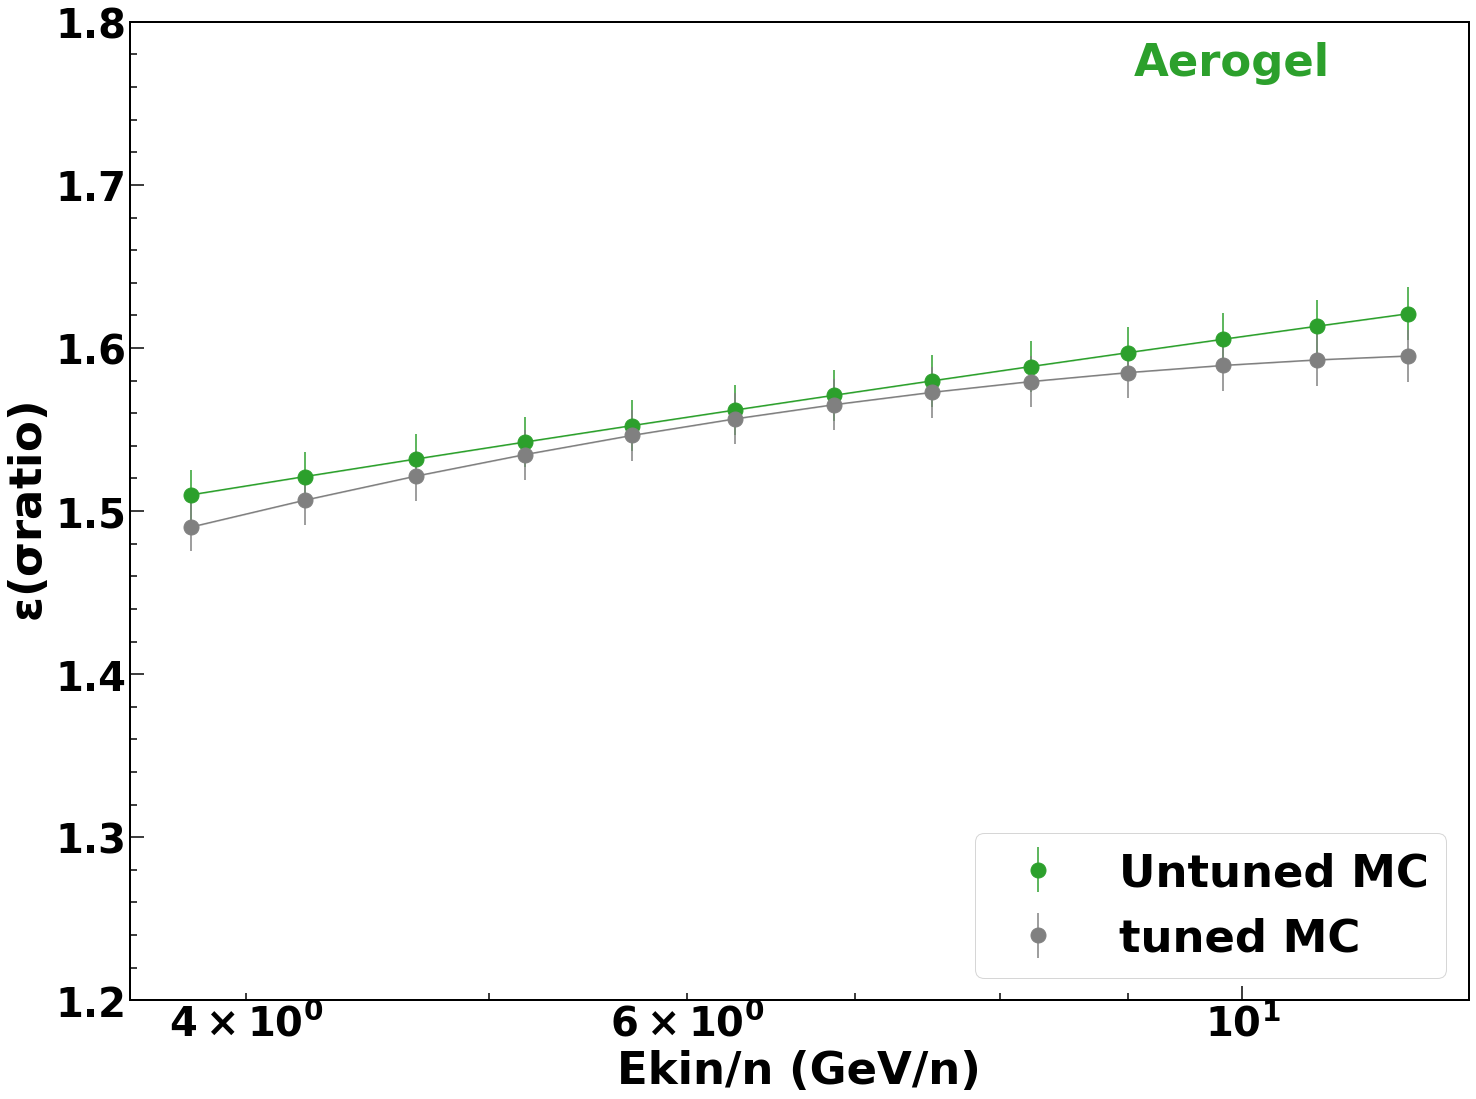

In [105]:
from tools.constants import ISOTOPES_MASS
from tools.massfit_tools import get_fitpdferrorband
import uncertainties                                                                                                                                                                                               
from uncertainties import unumpy                                                                                                                                                                                   
from uncertainties import ufloat    


parname = 'sigma_ratio'
decs = ['Agl']

file_1Untuned = f'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMassUntuned/fitBe7/df_{parname}_iter2Be7.npz'
file_2Tuned = f'/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMassTunedBetaHighR/fitBe7/df_{parname}_iter2Be7.npz'
df1Untuned = np.load(f'{file_1Untuned}')
df2Tuned = np.load(f'{file_2Tuned}')

graph1U = {}
graph2T = {}

for dec in decs:
    graph1U[dec] = MGraph.from_file(df1Untuned, f'graph_{parname}_{dec}')
    graph2T[dec] = MGraph.from_file(df2Tuned, f'graph_{parname}_{dec}')

slicevalue_trueratio ={'Tof':[0.3, 1.2], 'NaF':[0.9, 6.0], 'Agl':[3.5, 12.0]}
fig, ax1 = plt.subplots(1, 1, figsize=(24, 18))                                                                     
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
#p0 = {'Tof':[0.9], 'NaF':[0.8], "Agl":[0.8]}
p0 = {'Tof':[1.0, 0.1, 0.1], 'NaF':[1.0], "Agl":[1.0, 0.1, 0.1]}

for dec in decs: 
    plot_parswitherr(fig, ax1, graph1U[dec], DETECTOR_COLOR[dec], p0_mean[dec], labelname='Untuned MC')
    plot_parswitherr(fig, ax1, graph2T[dec], 'grey', p0_mean[dec], labelname='tuned MC')
    ax1.text(xaxistext[dec], 0.98,  f"{DETECTOR_LABEL[dec]}", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=DETECTOR_COLOR[dec], fontweight="bold")      
    
set_plot_style(ax1)                                                                                                                                  
ax1.set_xlabel("Ekin/n (GeV/n)") 
ax1.set_ylim(ylim_range_be7[parname])
ax1.set_xlabel('Ekin/n (GeV/n)', fontsize=fontsize1)
ax1.set_ylabel(f'{par_names_axes[parname]}', fontsize=fontsize1)
ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=fontsize1)
#savefig_tofile(fig, plotfile, 'mean_sigma_iter2', 1)




In [ ]:
massratiobe9 = {}
massratiobe10 = {}
graph_massratio_be9 = {}
graph_massratio_be10 = {}
graph_massratio_be9_gausfit = {}
graph_massratio_be10_gausfit = {}

filepath = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMassTunedBetaHighR/'
#filepath = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMassUntuned/'
filename = filepath + 'df_ratio_mean_iter2.npz'

slicevalue_trueratio ={'Tof':[0.3, 0.9], 'NaF':[1.0, 4.1], 'Agl':[4.0, 12.0]}
slicevalue_recratio ={'Tof':[0.3, 0.9], 'NaF':[1.0, 4.0], 'Agl':[4.0, 12.0]}

from tools.constants import ISOTOPES_MASS

df_measured_ratio = np.load(f'{filename}')
graph_massratio_be9_fromfit = {}
graph_massratio_be10_fromfit = {}
for dec in detectors:
    graph_massratio_be9_fromfit[dec] = MGraph.from_file(df_measured_ratio, f"graph_mass_sigma_9to7_{dec}")
    graph_massratio_be10_fromfit[dec] = MGraph.from_file(df_measured_ratio, f"graph_mass_sigma_10to7_{dec}")
    
for dec in detectors:
    graph_massratio_be9_fromfit[dec].yvalues = graph_massratio_be9_fromfit[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'])
    
fig, ax1 = plt.subplots(1, 1, figsize= (22, 16))
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
p0_dec = {'Tof':[0.7, 0.1, 0.1], 'NaF':[0.7, 0.1, 0.1], "Agl":[0.7, 0.1, 0.1]}
for dec in detectors:
    #graph_massratio_be9_fromfit[dec] = slice_graph_by_value(graph_massratio_be9_fromfit[dec], slicevalue_recratio[dec])
    plot_graph(fig, ax1, graph_massratio_be9_fromfit[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=21)   
    ax1.text(xaxistext[dec], 0.98, f"{dec}", fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      
    popt, pcov = curve_fit(poly, np.log(graph_massratio_be9_fromfit[dec].xvalues), graph_massratio_be9_fromfit[dec].yvalues, p0 = p0_dec[dec])  
    print(dec, "be9: ", popt, pcov)
    ax1.plot(graph_massratio_be9_fromfit[dec].xvalues, poly(np.log(graph_massratio_be9_fromfit[dec].xvalues), *popt), "-", color='black')                                                                          
                                                                                                                                                                                                                                                         
set_plot_defaultstyle(ax1)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
plt.subplots_adjust(hspace=.0)                                                                                                                                                                   
#ax1.set_xticklabels([])                                                                                                                                                                          
ax1.set_xlabel("Ekin/n (GeV/n)", fontsize=50) 
#ax1.set_xscale('log')
ax1.fill_betweenx(np.linspace(0.99, 1.01, 100), 1.0, 4.0, alpha=0.1, color="tab:blue") 
#ax1.axhline(y=ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'], color='orange', linestyle='--') 

ax1.axhline(y=1.0, color='orange', linestyle='--')  
#ax1.axhline(y=0.77869417, color='black', linestyle='--')  

ax1.set_ylim([0.99, 1.01])
ax1.set_ylabel(r'$\mathrm{k_{\mu9}}$', fontsize=50)
ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=35)
plotfile = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate0410/plots_0410'
savefig_tofile(fig, plotfile, 'mass_meanbe9correction', 1)

